In [1]:
## Load packages
library(readxl)
library(stringr)
library(rentrez)
library(dplyr)
library(tidyr)
library(ggplot2)
library(cowplot)
library(gggenes)
library(ggtree)
library(Biostrings)
library(msa)
library(ape)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


ggtree v3.14.0 Learn more at https://yulab-smu.top/contribution-tree-data/

Please cite:

Guangchuang Yu, Tommy Tsan-Yuk Lam, Huachen Zhu, Yi Guan. Two methods
for mapping and visualizing associated data on phylogeny using ggtree.
Molecular Biology and Evolution. 2018, 35(12):3041-3043.
doi:10.1093/molbev/msy194


Attaching package: ‘ggtree’


The following object is masked from ‘package:tidyr’:

    expand


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    

In [2]:
# Adjust PATHs

## Location in directory
wd <- getwd()
subdir <- "/bin" # should be 'scripts' if location is ./bin/thisfile
if (endsWith(wd, subdir)) {
    wd <- str_remove(wd, subdir)
    setwd(wd)
}
cat('Directory: ', getwd())

## Conda environment
conda_env <- paste0('/home/',Sys.getenv('USER'),'/miniconda3/envs/arabinosylation-anti-crispr/bin')
PATH <- Sys.getenv('PATH')
if (!str_detect(PATH, conda_env)) {
    Sys.setenv('PATH' = paste(conda_env, PATH, sep = ':'))
}
Sys.getenv('PATH')

Directory:  /projects/health_sciences/bms/microbiology/fineranlab/arabinosylation-anti-CRISPR

[1] "/home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/bin:/opt/conda/bin:/opt/conda/condabin:/opt/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin"

In [3]:
# Load internal functions
source('bin/hmm_utils.R')
source('bin/utils.R')

In [4]:
# Define variables

## Input files 
in_tables <- 'docs/supplementary-tables.xlsx'
url_millard <- 'https://millardlab-inphared.s3.climb.ac.uk/1Jan2025_data.tsv.gz'
in_inphared <- 'data/inphared.tsv'

## Data storage
in_path <- "data/"
overview <- paste0(in_path, 'overview.csv')

imgvr <- list(
    'path' = '../data_copied-from-HCS/genome_databases/IMG_VR_2022-12-19_7/'
)
imgvr$proteins <- paste0(imgvr$path, 'IMGVR_all_proteins.faa')
imgvr$host_data <- paste0(imgvr$path, 'IMGVR_all_Host_information.tsv')
imgvr$seq_data <- paste0(imgvr$path, 'IMGVR_all_Sequence_information.tsv')

## Output files
out_path <- 'analysis/'
out_annotation <- 'analysis/annotation/'
dir.create(out_annotation, recursive=TRUE)
out_prediction <- 'analysis/prediction/'
dir.create(out_prediction)

Warning message in dir.create(out_annotation, recursive = TRUE):
“'analysis/annotation' already exists”
Warning message in dir.create(out_prediction):
“'analysis/prediction' already exists”


In [5]:
# Define colors
cols <- list()

cols$group <- c(
    'None' = 'grey80',
    'None (any predicted)' = 'grey50',
    'glucose' = 'seagreen',
    #'arabinose' = 'yellow',
    'No aat' = 'darkorange',
    'Single aat' = 'indianred',
    'Aat 1 & aat 2' = 'purple',
    'Multiple aat' = 'pink'
)

cols$modification <- c(
    'None'='grey80',
    #'None (any predicted)' = 'grey50',
    #'Generic'='grey30',
    'Glucosylation'='seagreen',
    'Arabinosylation'='orange'
)

cols$known_modification <- c(
    'None' = 'grey80',
    #'Unknown' = 'grey30',
    'glucose' = 'seagreen',
    #'arabinose' = 'yellow',
    '5ara-hdC' = 'darkorange',
    '5ara-ara-hdC' = 'indianred',
    '5ara-ara-ara-hdC' = 'purple'
)

cols$annotation <- c(
    'DNA pol' = 'grey60',
    'DNA clamp' = 'black',
    'dCTPase' = 'purple',
    'HMase' = 'cyan3',
    'dNMP kinase' = 'dodgerblue',
    'Thy syn' = 'navy', # aquamarine
    'Glu transfer' = 'seagreen',
    'Ara iso' = 'darkorange',
    'NTP transfer' = 'yellow',
    'Thy kin' = 'hotpink',
    'Aat' = 'indianred',
    'Other' = 'grey90'
)

cols$annotation <- c(
    'DNA pol' = 'grey50',
    'DNA clamp' = 'grey60',
    'dCTPase' = 'purple',
    'Pep U32' = 'cyan2',
    'Hydroxylase' = 'cyan3',
    'dNMP kinase' = 'dodgerblue',
    'Thy syn' = 'navy', # aquamarine
    'Glu transfer' = 'seagreen',
    'Ara iso' = 'darkorange',
    'pHep iso' = 'orange',
    'NTP transfer' = 'yellow',
    'Thy kin' = 'hotpink',
    'Aat' = 'indianred',
    'Other' = 'grey90'
)

In [6]:
# Download data
download.file(url_millard, in_inphared)

In [7]:
# Read data

## Supplementary tables
tables <- list()
for (i in excel_sheets(in_tables)) {
    print(paste('Reading table', i))
    tables[[i]] <- read_excel(in_tables, sheet = i)
    }

## Millard lab INPARED database overview
inphared <- readr::read_tsv(in_inphared)

[1] "Reading table phages"
[1] "Reading table annotation"
[1] "Reading table predicted_arabinosylating_phage"
[1] "Reading table S7_phage-genomes"
[1] "Reading table proteins"
[1] "Reading table S4_phages"
[1] "Reading table S1_bacteria"
[1] "Reading table S6_ara-hC-transferases"
[1] "Reading table S8_glucosylation-enzymes"
[1] "Reading table S9_DNA-modification-enzymes"


Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 32043 Columns: 27
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (18): Accession, Description, Classification, Molecule, Modification Dat...
dbl  (7): Genome Length (bp), molGC (%), Number CDS, Positive Strand (%), Ne...
lgl  (2): Jumbophage, Low Coding Capacity Warning

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
# Read file structure
collections <- c('training','test','test2')
fs <- list()
for (i in collections) {
    fs[[i]]$path <- paste0(in_path, i, '/')
    fs[[i]]$accession <- paste0(in_path, i, '/accession.txt')
    fs[[i]]$archive <- paste0(fs[[i]]$path, 'ncbi_dataset/', 'data/')
    for (ii in list.files(fs[[i]]$archive)) {
        key <- str_split(ii, '\\.')[[1]][[1]]
        fs[[i]][[key]] <- paste0(fs[[i]]$archive, ii)
    }
}
fs
all(file.exists(unlist(fs)))
which(!file.exists(unlist(fs)))

$training
$training$path
[1] "data/training/"

$training$accession
[1] "data/training/accession.txt"

$training$archive
[1] "data/training/ncbi_dataset/data/"

$training$annotation_report
[1] "data/training/ncbi_dataset/data/annotation_report.jsonl"

$training$biosample_report
[1] "data/training/ncbi_dataset/data/biosample_report.jsonl"

$training$cds
[1] "data/training/ncbi_dataset/data/cds.fna"

$training$data_report
[1] "data/training/ncbi_dataset/data/data_report.jsonl"

$training$dataset_catalog
[1] "data/training/ncbi_dataset/data/dataset_catalog.json"

$training$features
[1] "data/training/ncbi_dataset/data/features.gtf"

$training$genomic
[1] "data/training/ncbi_dataset/data/genomic.fna"

$training$metadata
[1] "data/training/ncbi_dataset/data/metadata.tsv"

$training$protein
[1] "data/training/ncbi_dataset/data/protein.faa"

$training$virus_dataset
[1] "data/training/ncbi_dataset/data/virus_dataset.md"


$test
$test$path
[1] "data/test/"

$test$accession
[1] "data/test/accession.txt"

$test$archive
[1] "data/test/ncbi_dataset/data/"

$test$annotation_report
[1] "data/test/ncbi_dataset/data/annotation_report.jsonl"

$test$biosample_report
[1] "data/test/ncbi_dataset/data/biosample_report.jsonl"

$test$cds
[1] "data/test/ncbi_dataset/data/cds.fna"

$test$data_report
[1] "data/test/ncbi_dataset/data/data_report.jsonl"

$test$dataset_catalog
[1] "data/test/ncbi_dataset/data/dataset_catalog.json"

$test$features
[1] "data/test/ncbi_dataset/data/features.gtf"

$test$genomic
[1] "data/test/ncbi_dataset/data/genomic.fna"

$test$metadata
[1] "data/test/ncbi_dataset/data/metadata.tsv"

$test$protein
[1] "data/test/ncbi_dataset/data/protein.faa"

$test$virus_dataset
[1] "data/test/ncbi_dataset/data/virus_dataset.md"


$test2
$test2$path
[1] "data/test2/"

$test2$accession
[1] "data/test2/accession.txt"

$test2$archive
[1] "data/test2/ncbi_dataset/data/"

$test2$annotation_report
[1] "data/test2/ncbi_dataset/data/annotation_report.jsonl"

$test2$biosample_report
[1] "data/test2/ncbi_dataset/data/biosample_report.jsonl"

$test2$cds
[1] "data/test2/ncbi_dataset/data/cds.fna"

$test2$data_report
[1] "data/test2/ncbi_dataset/data/data_report.jsonl"

$test2$dataset_catalog
[1] "data/test2/ncbi_dataset/data/dataset_catalog.json"

$test2$features
[1] "data/test2/ncbi_dataset/data/features.gtf"

$test2$genomic
[1] "data/test2/ncbi_dataset/data/genomic.fna"

$test2$metadata
[1] "data/test2/ncbi_dataset/data/metadata.tsv"

$test2$protein
[1] "data/test2/ncbi_dataset/data/protein.faa"

$test2$virus_dataset
[1] "data/test2/ncbi_dataset/data/virus_dataset.md"

[1] TRUE

integer(0)

In [9]:
# Read data

## Training data
training <- list(
    'metadata' = read.delim(fs$training$metadata),
    'features' = read.delim(fs$training$features),
    'protein' = readAAStringSet(fs$training$protein)
)
training$metadata$set <- 'training'
training$features$set <- 'training'
str(training, max.level = 1)

## Test data
test <- list(
    'metadata' = read.delim(fs$test$metadata),
    'features' = read.delim(fs$test$features),
    'protein' = readAAStringSet(fs$test$protein)
)
test$metadata$set <- 'test'
test$features$set <- 'test'
str(test, max.level = 1)

## Test2 data
test2 <- list(
    'metadata' = read.delim(fs$test2$metadata),
    'features' = read.delim(fs$test2$features),
    'protein' = readAAStringSet(fs$test2$protein)
)
test2$metadata$set <- 'test2'
test2$features$set <- 'test2'
str(test2, max.level = 1)

List of 3
 $ metadata:'data.frame':	35 obs. of  50 variables:
 $ features:'data.frame':	9641 obs. of  71 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


Warning message in scan(file = file, what = what, sep = sep, quote = quote, dec = dec, :
“EOF within quoted string”


List of 3
 $ metadata:'data.frame':	22718 obs. of  50 variables:
 $ features:'data.frame':	3318957 obs. of  71 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots
List of 3
 $ metadata:'data.frame':	43177 obs. of  50 variables:
 $ features:'data.frame':	2386025 obs. of  71 variables:
 $ protein :Formal class 'AAStringSet' [package "Biostrings"] with 5 slots


In [10]:
# Create combined dataset

## Create object
ds <- list(
    files = fs
)

## Genomes
ds$genomes <- rbind(
    training$metadata,
    test$metadata,
    test2$metadata
)
any(duplicated(ds$genomes$Accession))

## Features

## View
str(ds, max.level = 1)

[1] FALSE

List of 2
 $ files  :List of 3
 $ genomes:'data.frame':	65930 obs. of  50 variables:


In [11]:
object.size(ds) / 1e6

46.7 bytes

In [12]:
# Intersect with Millard list
table(ds$genomes$Completeness)
millard_acc <- inphared$Accession
ds$genomes$millard <- str_split(ds$genomes$Accession,'\\.',simplify=TRUE)[,1] %in% millard_acc
table(millard_acc %in% str_split(ds$genomes$Accession,'\\.',simplify=TRUE)[,1])
table(ds$genomes$millard)


COMPLETE  PARTIAL 
   33397    32533 


FALSE  TRUE 
  139 31904 


FALSE  TRUE 
34026 31904 

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


[1] 27256

Warning message:
“Removed 17328 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 17328 rows containing non-finite outside the scale range
(`stat_bin()`).”


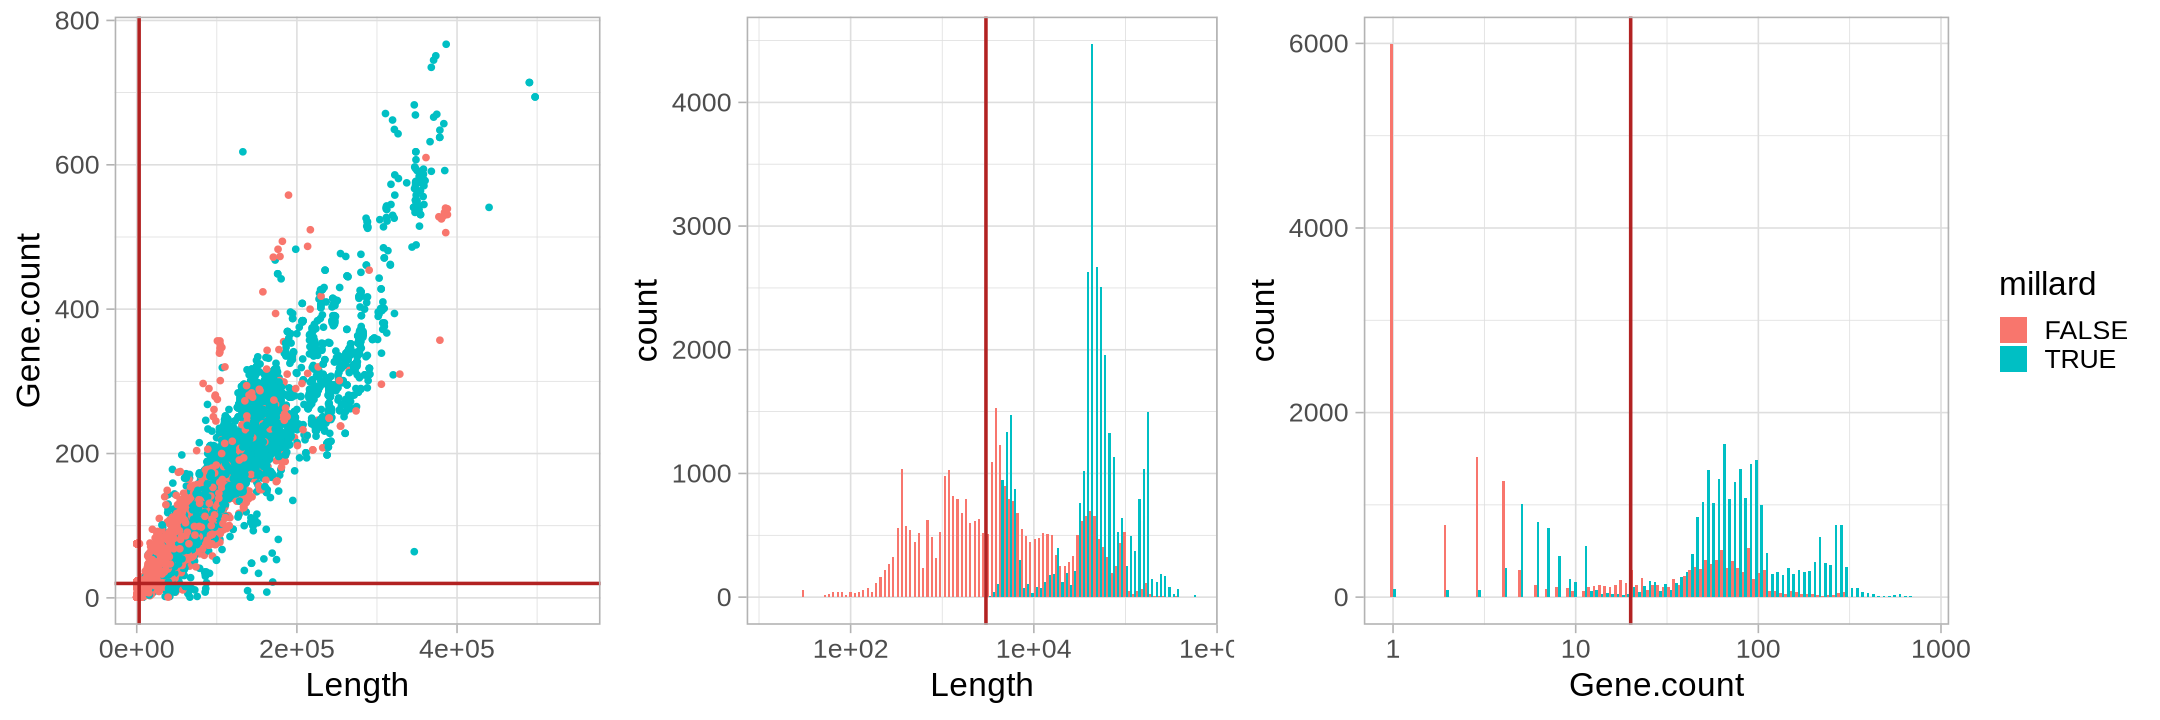

In [13]:
# Genome QC
options(repr.plot.width=18, repr.plot.height=6)

## Thresholds
min_genes <- 20
min_length <- 3000

## Plot
p1 <- ggplot(ds$genomes, aes(Length, Gene.count, col=millard)) +
  geom_point() +
  geom_hline(yintercept = min_genes, size=1, col='firebrick') +
  geom_vline(xintercept = min_length, size=1, col='firebrick') +
  theme_light(20) +
  guides(col = guide_none())

## Plot
p2 <- ggplot(ds$genomes, aes(Length, fill=millard)) +
  geom_histogram(bins = 100, position = 'dodge') +
  scale_x_continuous(trans='log10') +
  geom_vline(xintercept = min_length, size=1, col='firebrick') +
  theme_light(20) +
  guides(fill = guide_none())

## Plot
p3 <- ggplot(ds$genomes, aes(Gene.count, fill=millard)) +
  geom_histogram(bins = 100, position = 'dodge') +
  scale_x_continuous(trans='log10') +
  geom_vline(xintercept = min_genes, size=1, col='firebrick') +
  theme_light(20)

## Quantify
length(unique(ds$genomes$Virus.Name))

## Arrange
plot_grid(p1, p2, p3, nrow = 1, rel_widths = c(1,1,1.5))

In [14]:
# Filter

## Report
ds$genomes <- ds$genomes[which(ds$genomes$millard), ]
ds$genomes <- ds$genomes[which(ds$genomes$Length > min_length), ]
ds$genomes <- ds$genomes[which(ds$genomes$Gene.count > min_genes), ]
ds$genomes <- ds$genomes[which(!duplicated(ds$genomes$Virus.Name)), ]

## Check for introduced NAs
any(is.na(ds$genomes$Accession))

## View
str(ds$genomes, max.level = 0)

[1] FALSE

'data.frame':	18893 obs. of  51 variables:


[1] 18893

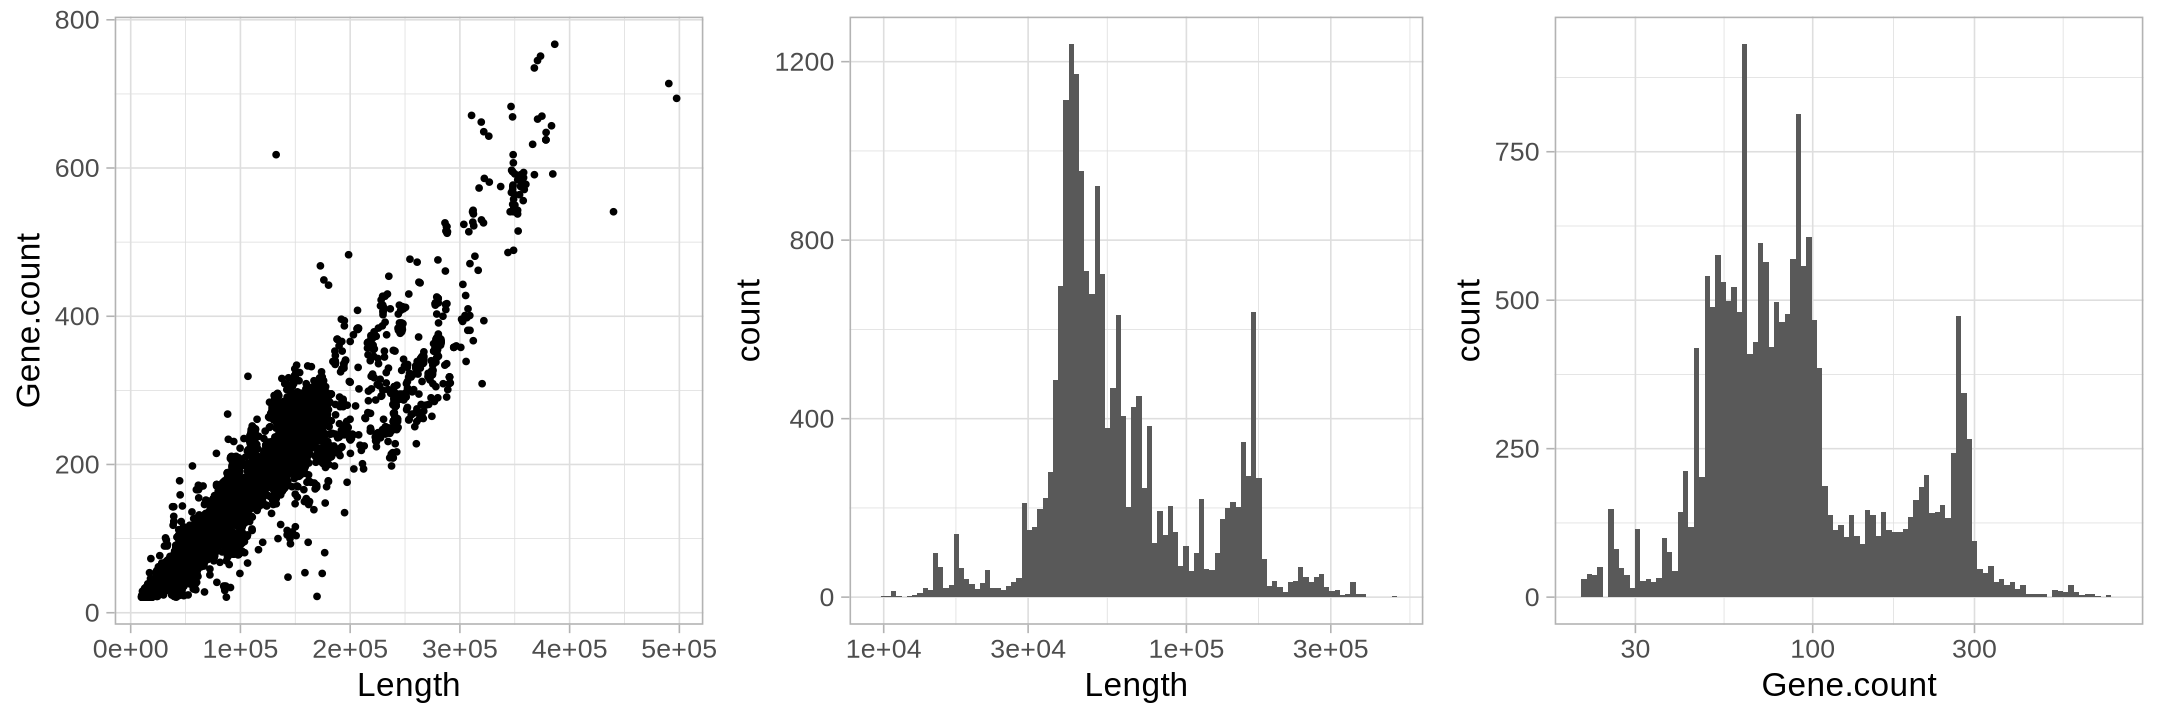

In [15]:
# Genome QC
options(repr.plot.width=18, repr.plot.height=6)

## Plot
p1 <- ggplot(ds$genomes, aes(Length, Gene.count)) +
  geom_point() +
  theme_light(20)

## Plot
p2 <- ggplot(ds$genomes, aes(Length)) +
  geom_histogram(bins = 100) +
  scale_x_continuous(trans='log10') +
  theme_light(20)

## Plot
p3 <- ggplot(ds$genomes, aes(Gene.count)) +
  geom_histogram(bins = 100) +
  scale_x_continuous(trans='log10') +
  theme_light(20)

## Quantify
length(unique(ds$genomes$Virus.Name))

## Arrange
plot_grid(p1, p2, p3, nrow = 1, rel_widths = c(1,1,1))

In [16]:
# Combine GTF

## Combine
ds$features <- rbind(
    training$features,
    test$features,
    test2$features
)

## Create keys
ds$features$protein_key <- paste(
    ds$features$Gene.CDS.Protein.FASTA.Sequence.ID, 
    ds$features$Gene.CDS.Protein.FASTA.Title
)
ds$features$acc_protein_key <- paste(sep='__',
    ds$features$Accession, ds$features$protein_key
)

## Add protein sequences
ds$features$protein_seq <- NA

### Training
index_a <- ds$features$set == 'training'
index_b <- match(ds$features$protein_key[index_a], names(training$protein))
ds$features$protein_seq[index_a] <- as.character(training$protein)[index_b]

## View
str(ds$features, max.level = 0)
length(unique(ds$features$Accession))
table(ds$features$Accession %in% ds$genomes$Accession)

## Filter
ds$features <- ds$features[which(ds$features$Accession %in% ds$genomes$Accession), ]

## View
str(ds$features, max.level = 0)

'data.frame':	5714623 obs. of  74 variables:


[1] 65930


  FALSE    TRUE 
2293869 3420754 

'data.frame':	3420754 obs. of  74 variables:


In [17]:
## Duplicated genes
ds$features$is_unique <- !duplicated(ds$features$Gene.CDS.Protein.FASTA.Accession)
table(ds$features$is_unique, ds$features$set)

       
           test   test2 training
  FALSE   43794 1367630      229
  TRUE  1999689       0     9412

In [18]:
# Modify genome metadata
options(repr.plot.width=10, repr.plot.height=5)

## Variables
genus_size <- 30

## Extract host genus
ds$genomes$genus <- case_when(
    ds$genomes$Host.Name == 'human metagenome' ~ "Metagenome",
    ds$genomes$Host.Name == 'Homo sapiens' ~ "Metagenome",
    ds$genomes$Host.Name == 'Bos taurus' ~ "Metagenome",
    ds$genomes$Host.Name == 'Sus scrofa' ~ "Metagenome",
    str_detect(ds$genomes$Host.Name, 'Aves') ~ "Metagenome",
    str_detect(ds$genomes$Host.Name, 'Apis') ~ "Metagenome",
    str_detect(ds$genomes$Host.Name, 'Bombyx') ~ "Metagenome",
    str_detect(ds$genomes$Host.Name, '\\[Arthrobacter') ~ "Arthrobacter",
    str_detect(ds$genomes$Host.Name, '\\[Clostridium') ~ "Clostridium",
    str_detect(ds$genomes$Host.Name, '\\[Ruminococcus') ~ "Ruminococcus",
    ds$genomes$Host.Name == '' ~ "Unknown",
    .default = ds$genomes$Host.Name
)
ds$genomes$genus <- str_split(ds$genomes$genus, ' ', simplify=TRUE)[,1]

## Manually correct artifacts
ds$genomes$genus[which(ds$genomes$genus == '[Brevibacterium]')] <- 'Brevibacterium'

## Order genus
length(unique(ds$genomes$genus)) # Too many to plot
index <- sort(table(ds$genomes$genus), decreasing=TRUE)
ds$genomes$genus <- factor(ds$genomes$genus, names(index))

## Create cleaned genus
ds$genomes$genus_cleaned <- as.character(ds$genomes$genus)
ds$genomes$genus_cleaned[ds$genomes$genus %in% names(index[which(index < genus_size)])] <- 'Other'
index <- sort(table(ds$genomes$genus_cleaned), decreasing=TRUE)
genus_levels <- names(index)
genus_levels <- c(genus_levels[which(genus_levels != 'Other')],'Other')
ds$genomes$genus_cleaned <- factor(ds$genomes$genus_cleaned, genus_levels)

## Add millard lab entries
index <- match(str_split(ds$genomes$Accession,'\\.',simplify=TRUE)[,1], inphared$Accession)
ds$genomes$Host_Genus <- inphared$Host[index]
ds$genomes$Phage_Genus <- inphared$Genus[index]
ds$genomes$Phage_Family <- inphared$Family[index]
ds$genomes$Phage_Class <- inphared$Class[index]

### Order & clean host genus
index <- sort(table(ds$genomes$Host_Genus), decreasing=TRUE)
ds$genomes$Host_Genus <- factor(ds$genomes$Host_Genus, names(index))
ds$genomes$genus_cleaned <- as.character(ds$genomes$Host_Genus)
ds$genomes$genus_cleaned[ds$genomes$Host_Genus %in% names(index[which(index < genus_size)])] <- 'Other'
index <- sort(table(ds$genomes$genus_cleaned), decreasing=TRUE)
genus_levels <- names(index)
genus_levels <- c(genus_levels[which(genus_levels != 'Other')],'Other')
ds$genomes$genus_cleaned <- factor(ds$genomes$genus_cleaned, genus_levels)

#### Order & clean phage family
index <- sort(table(ds$genomes$Phage_Family), decreasing=TRUE)
ds$genomes$Phage_Family <- factor(ds$genomes$Phage_Family, names(index))
ds$genomes$Phage_Family <- as.character(ds$genomes$Phage_Family)
ds$genomes$Phage_Family[ds$genomes$Phage_Family %in% names(index[which(index < 50)])] <- 'Other'
index <- sort(table(ds$genomes$Phage_Family), decreasing=TRUE)
genus_levels <- names(index)
genus_levels <- c(genus_levels[which(genus_levels != 'Other')],'Other')
ds$genomes$Phage_Family <- factor(ds$genomes$Phage_Family, genus_levels)

[1] 360

In [19]:
object.size(ds) / 1e6
object.size(ds$features) / 1e6
object.size(ds$genomes) / 1e6
object.size(training) / 1e6
object.size(test) / 1e6
object.size(test2) / 1e6

2990.3 bytes

2962.3 bytes

28 bytes

11.9 bytes

3908.2 bytes

2806.3 bytes

`summarise()` has grouped output by 'set', 'genus_cleaned', 'Phage_Family'. You
can override using the `.groups` argument.


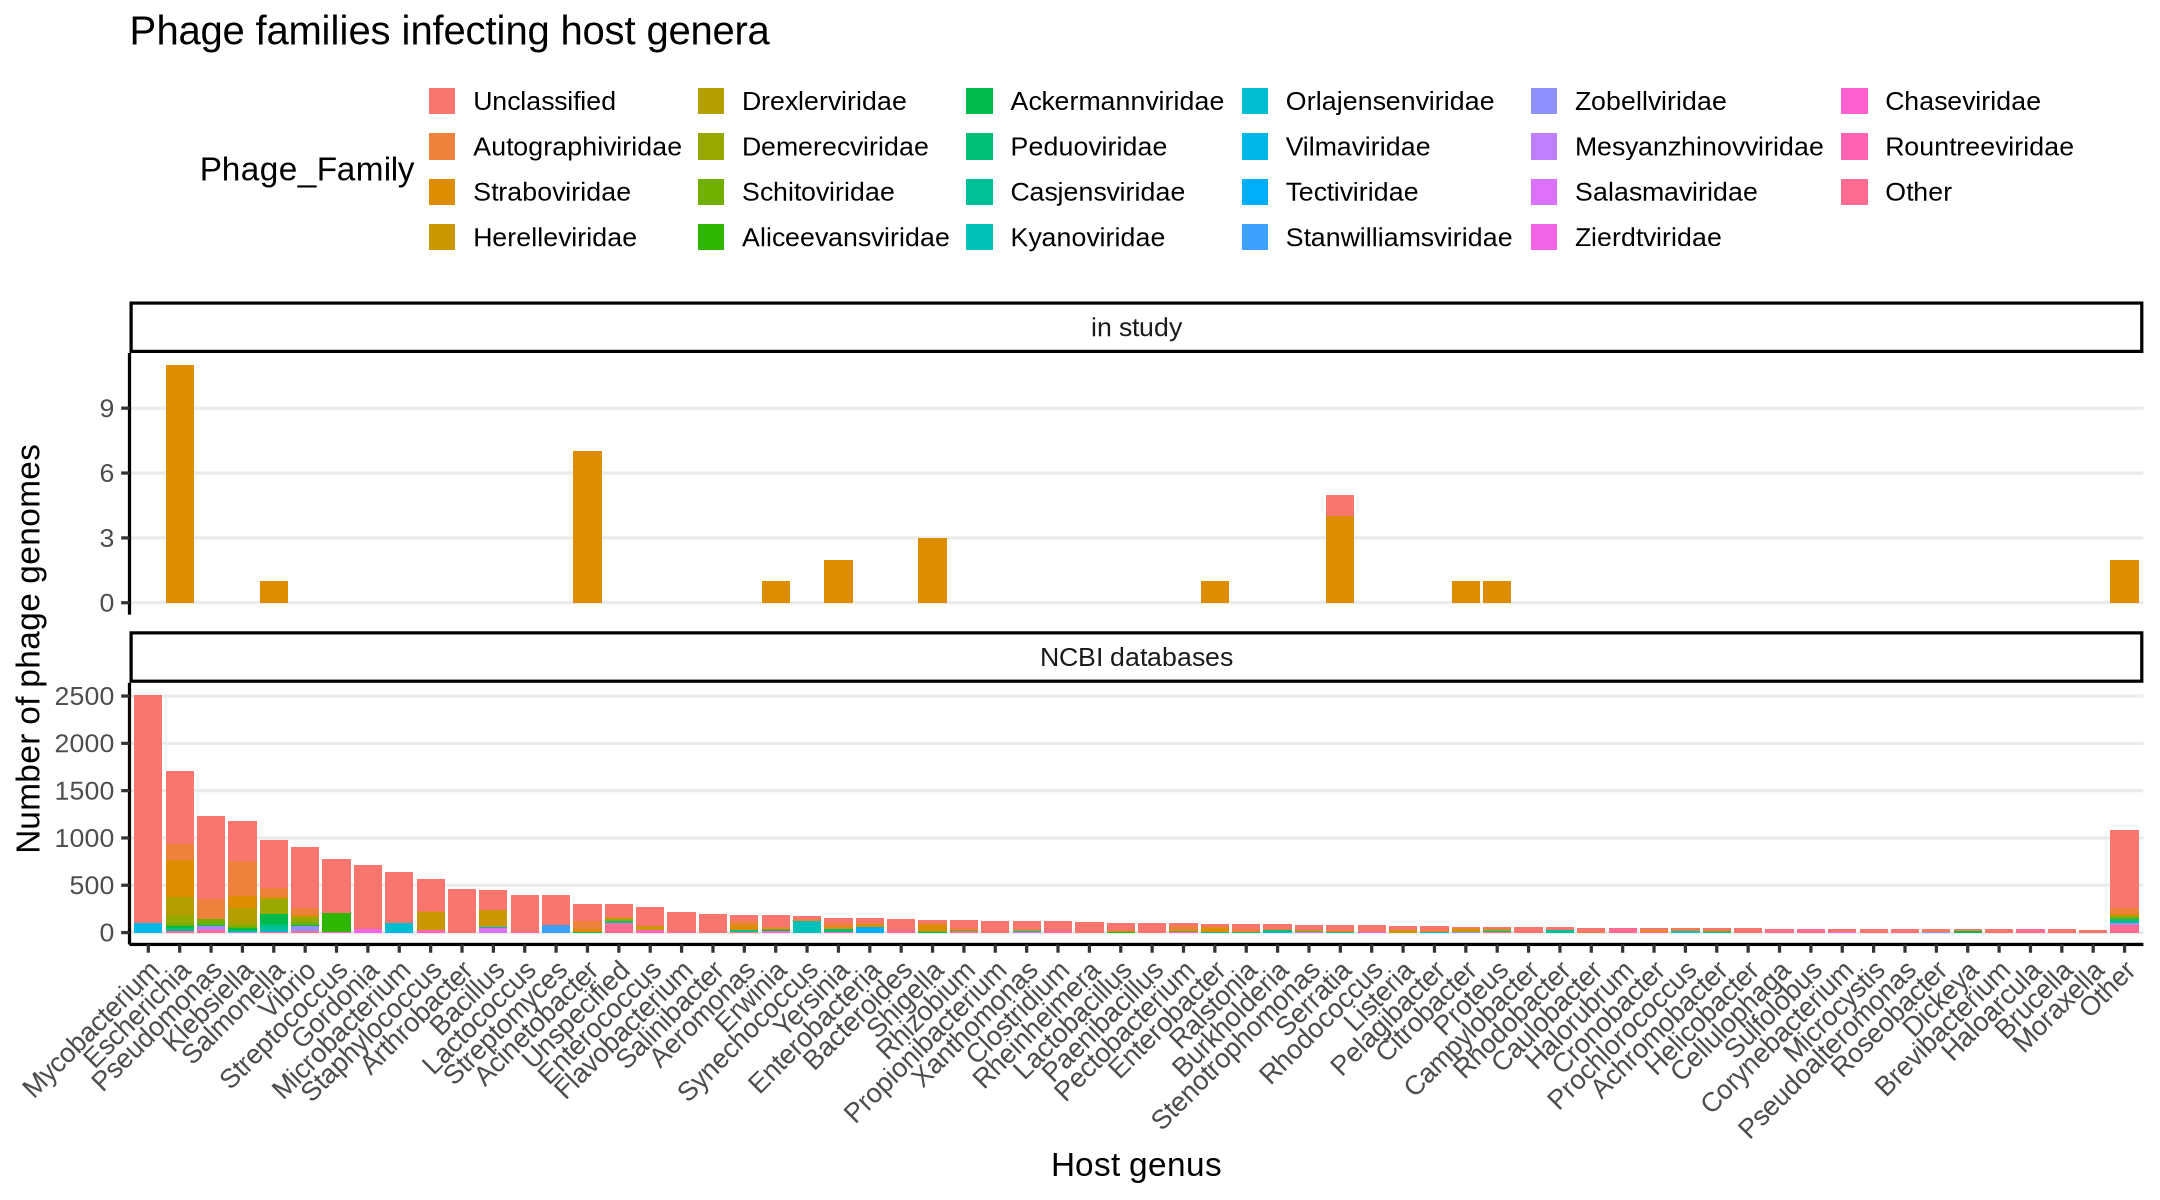

In [20]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=10)

## Select
df <- ds$genomes
df$N <- 1

## Summarize
df <- df %>% group_by(set, genus_cleaned, Phage_Family, Source.database) %>% summarize(total = sum(N))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training')] <- 'in study'
df$facet[df$set %in% c('test','test2','validation')] <- 'NCBI databases'
df$set <- factor(df$set, c('training','validation','test','test2'))

## Plot
ggplot(df, aes(genus_cleaned, total, fill=Phage_Family)) +
  geom_col() +
  facet_wrap(~facet, nrow = 2, scales = 'free_y') +
#  scale_fill_manual(values=c('cyan3','black')) +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  guides(
      fill = guide_legend(position = 'top', nrow = 4)
  ) +
  labs(title='Phage families infecting host genera', x = 'Host genus', y='Number of phage genomes')

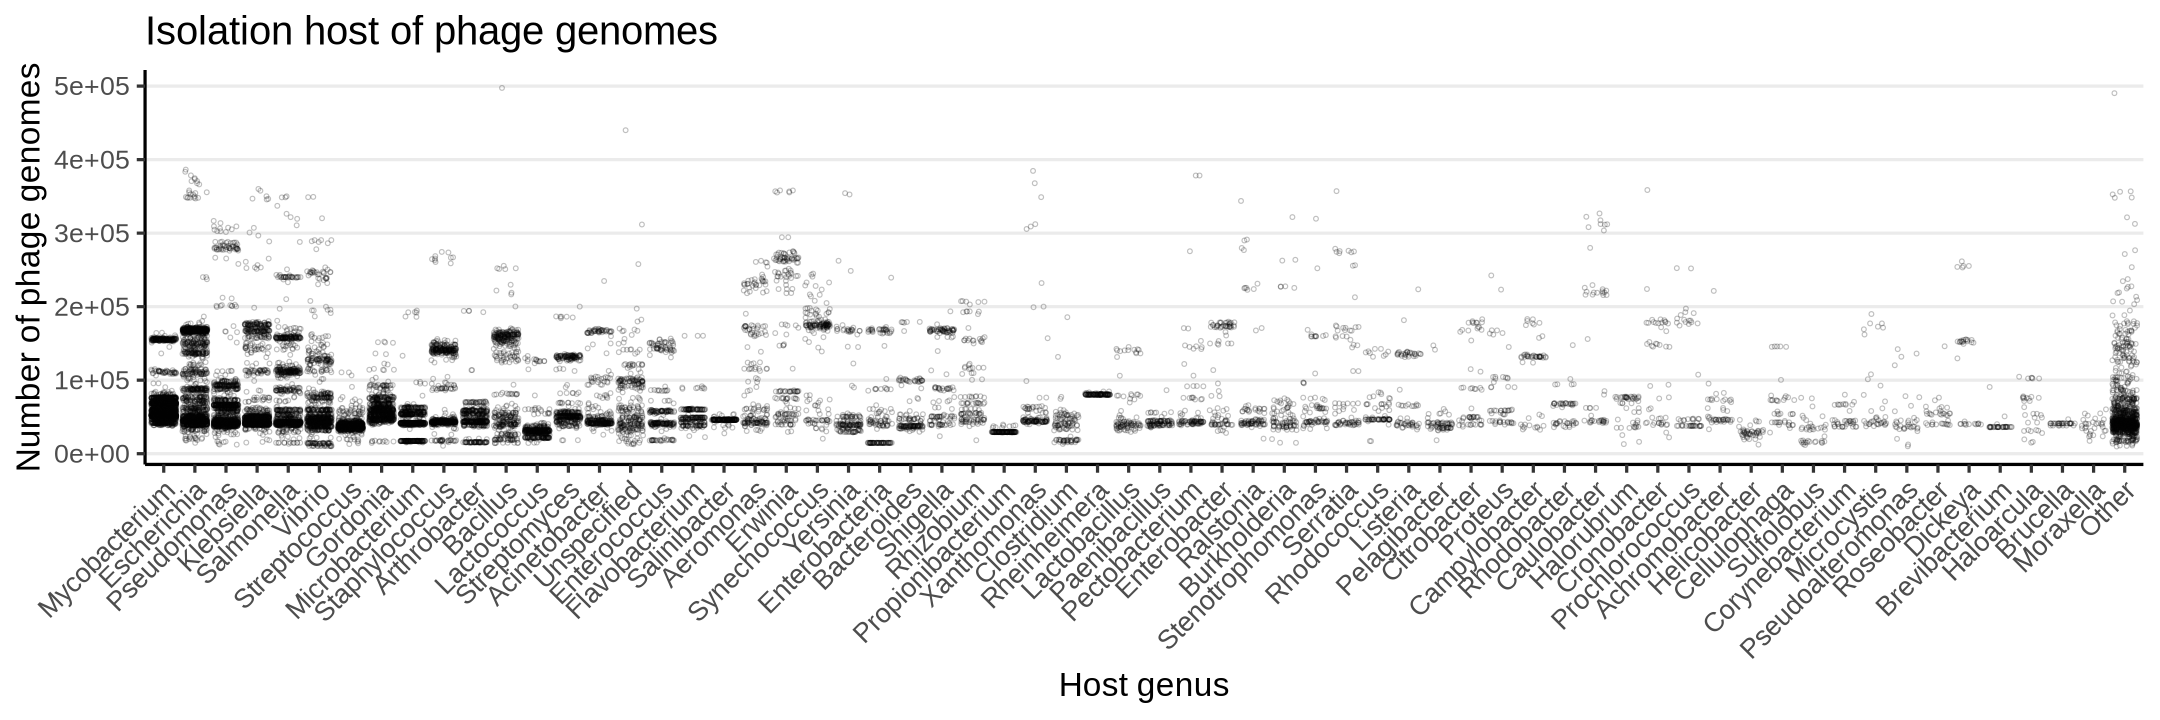

In [21]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=6)

## Select
df <- ds$genomes

## Plot
ggplot(df, aes(genus_cleaned, Length)) +
  #geom_boxplot(fill='grey20') +
  geom_point(shape=21, position='jitter', size=1, alpha=.25) +
  #geom_violin(scale = 'width', fill=NA, size=.5, col='black') +
  theme_classic(20) +
  #scale_y_continuous(trans='log10') +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(title='Isolation host of phage genomes', x = 'Host genus', y='Number of phage genomes')

In [22]:
# Check for duplicated accession numbers
ds$genomes$is_unique <- !duplicated(ds$genomes$Accession)
table(ds$genomes$is_unique, ds$genomes$set)

      
        test test2 training
  TRUE  6156 12702       35

In [23]:
# Annotation

## Fetch data
data <- ds$features[ds$features$set == 'training',]
length(unique(data$Gene.CDS.Name))

## Look up gene 
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')]

# Transfer into new vector
data$annotation <- data$Gene.CDS.Name
data$annotation <- 'Other'

## Step 0 - Conserved genes
data$annotation[data$Gene.CDS.Name == 'DNA polymerase'] <- 'DNA pol'
data$annotation[str_detect(data$Gene.CDS.Name, 'clamp loader')] <- 'DNA clamp'
data$annotation[str_detect(data$Gene.CDS.Name, 'dNMP kinase')] <- 'dNMP kinase'

## Step A - dCTP modification
data$annotation[str_detect(data$Gene.CDS.Name, 'dCTP') & str_detect(data$Gene.CDS.Name, 'ase')] <- 'dCTPase'
data$annotation[str_detect(data$Gene.CDS.Name, 'peptidase') & str_detect(data$Gene.CDS.Name, 'U32')] <- 'Pep U32'
data$annotation[str_detect(data$Gene.CDS.Name, 'dCMP') & str_detect(data$Gene.CDS.Name, 'hydroxy')] <- 'Hydroxylase'

## Step B - UTP arabinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'arabinose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'Ara iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'phosphoheptose') & str_detect(data$Gene.CDS.Name, 'isomerase')] <- 'pHep iso'
data$annotation[str_detect(data$Gene.CDS.Name, 'NTP') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'
data$annotation[str_detect(data$Gene.CDS.Name, 'nucleotidyl') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'NTP transfer'

## Step C - Glucosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'glucos') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Glu transfer'

## Step D - Ararbinosylation
data$annotation[str_detect(data$Gene.CDS.Name, 'ara') & str_detect(data$Gene.CDS.Name, 'transfer')] <- 'Aat'
# Most Aat genes are not annotated !!!

## Step E - function?
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'synthase')] <- 'Thy syn'
data$annotation[str_detect(data$Gene.CDS.Name, 'thymidylate') & str_detect(data$Gene.CDS.Name, 'kinase')] <- 'Thy kin'

unique(data$annotation)
length(unique(data$annotation))


[1] 1086

[1] "putative hmC-arabinosyltransferase" "putative hmC-arabinosyltransferase"

[1] "Other"        "dCTPase"      "Glu transfer" "Hydroxylase"  "DNA clamp"   
 [6] "dNMP kinase"  "Thy syn"      "NTP transfer" "DNA pol"      "Ara iso"     
[11] "Pep U32"      "Thy kin"      "Aat"          "pHep iso"

[1] 14

In [24]:
## Look up gene 
data$Gene.CDS.Name[str_detect(data$Gene.CDS.Name, 'nucleotidyl') & str_detect(data$Gene.CDS.Name, 'transfer')]
#data$Gene.CDS.Name[data$Gene.CDS.Name == 'DNA polymerase']

[1] "putative nucleotidyltransferase" "putative nucleotidyltransferase"
 [3] "putative nucleotidyltransferase" "putative nucleotidyltransferase"
 [5] "putative nucleotidyltransferase" "nucleotidyltransferase"         
 [7] "nucleotidyltransferase"          "nucleotidyltransferase"         
 [9] "nucleotidyltransferase"          "nucleotidyltransferase"         
[11] "nucleotidyltransferase"          "nucleotidyltransferase"         
[13] "nucleotidyltransferase"          "putative nucleotidyltransferase"
[15] "nucleotidyltransferase"          "nucleotidyltransferase"         
[17] "nucleotidyltransferase"          "nucleotidyltransferase"         
[19] "nucleotidyltransferase"          "nucleotidyltransferase"         
[21] "nucleotidyltransferase"          "nucleotidyltransferase"         
[23] "nucleotidyltransferase"

In [25]:
# Modify data

## Modification group
index <- match(data$Accession, tables$phages$accession)
data$aat <- tables$phages$group_aat[index]
data$modification <- tables$phages$group_modification[index]

## Genome size
data <- data %>% group_by(Accession) %>% mutate(
    genomeSize = max(Gene.CDS.Nucleotide.FASTA.Range.Stop, na.rm=TRUE) - min(Gene.CDS.Nucleotide.FASTA.Range.Start, na.rm=TRUE)
)

## Add virus name
index <- match(data$Accession, ds$genomes$Accession)
data$Name <- ds$genomes$Virus.Name[index]

## Manually edit annotations

### Aat
data$annotation[data$annotation == 'Glu transfer' & data$modification != 'glucose'] <- 'Aat'

## Convert to factor
data$annotation <- factor(data$annotation, names(cols$annotation))

Warning message in geom_point(data = ann, aes(x = -5000, y = Name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


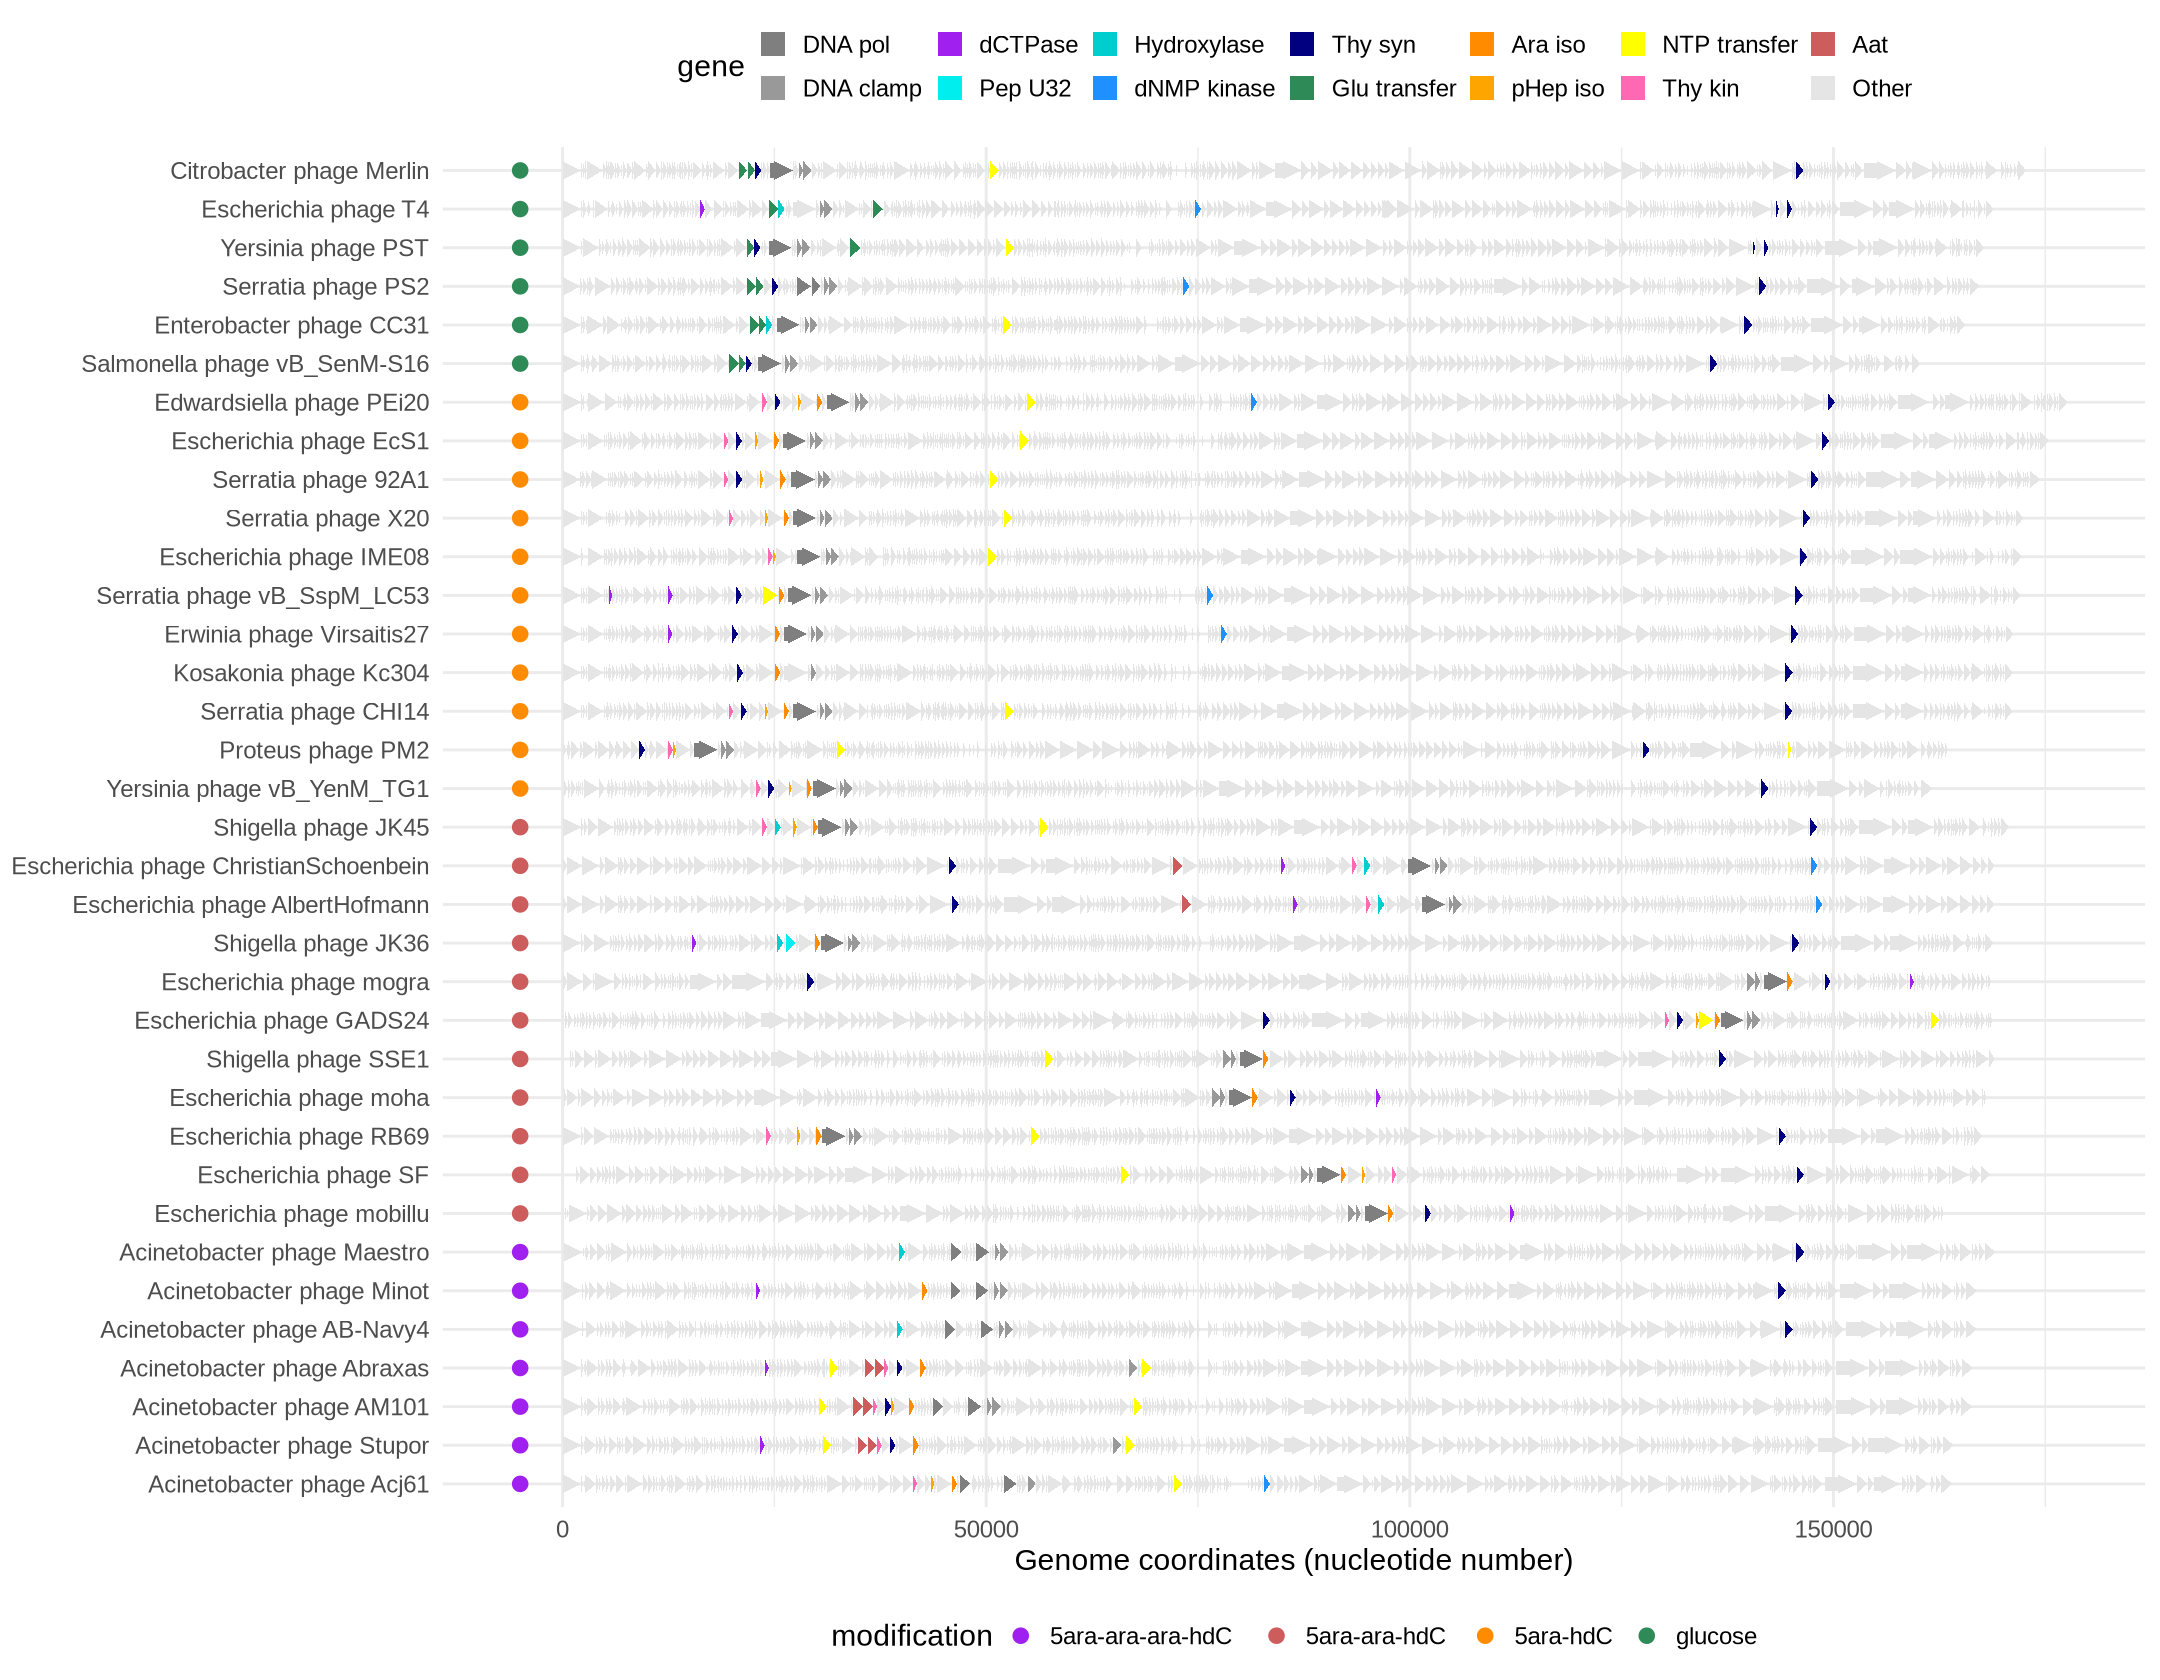

In [26]:
# Visualize genomes
options(repr.plot.width=18, repr.plot.height=14)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$known_modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=2), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')

In [27]:
# Annotation

## Fetch data
df <- tables$annotation
df <- df[!is.na(df$protein_id), ]
index <- match(df$protein_id, data$Gene.CDS.Protein.FASTA.Accession)

## Transfer annotation
data$annotation <- 'Other'
data$annotation[index] <- df$annotation

## View
unique(data$annotation)

[1] "Other"                        "dCTPase"                     
 [3] "beta-glucosyl-transferase"    "dCMP hydroxymethylase"       
 [5] "DNA polymerase"               "alpha-glucosyl-transferase"  
 [7] "dNMP kinase"                  "aat 2"                       
 [9] "aat 1"                        "thymidylate kinase"          
[11] "putative glycosyltransferase" "dCMP hydroxylase"            
[13] "phosphoheptose isomerase"     "NTP transferase"             
[15] "arabinose isomerase"          "aat"                         
[17] "peptidase U32"

In [28]:
cols$annotation <- c(
    'DNA polymerase' = 'grey50',
    #'DNA clamp' = 'grey60',
    'dCTPase' = 'purple',
    'peptidase U32' = 'cyan2',
    'dCMP hydroxylase' = 'cyan3',
    'dCMP hydroxymethylase' = 'cyan4',
    'dNMP kinase' = 'dodgerblue',
    #'Thy syn' = 'navy', # aquamarine
    'putative glycosyltransferase' = 'seagreen',
    'alpha-glucosyl-transferase' = 'seagreen1',
    'beta-glucosyl-transferase' = 'seagreen3',
    'arabinose isomerase' = 'darkorange',
    'phosphoheptose isomerase' = 'orange',
    'NTP transferase' = 'yellow',
    'thymidylate kinase' = 'hotpink',
    'aat' = 'firebrick',
    'aat 1' = 'indianred',
    'aat 2' = 'red',
    'Other' = 'grey90'
)

## Check overlap
index <- unique(data$annotation) %in% names(cols$annotation)
table(index)
unique(data$annotation)[which(!index)]

## Convert to factor
data$annotation <- factor(data$annotation, names(cols$annotation))

index
TRUE 
  17 

character(0)

Warning message in geom_point(data = ann, aes(x = -5000, y = short_name, col = modification, :
“Ignoring unknown aesthetics: label”
Warning message:
“Removed 25 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 25 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


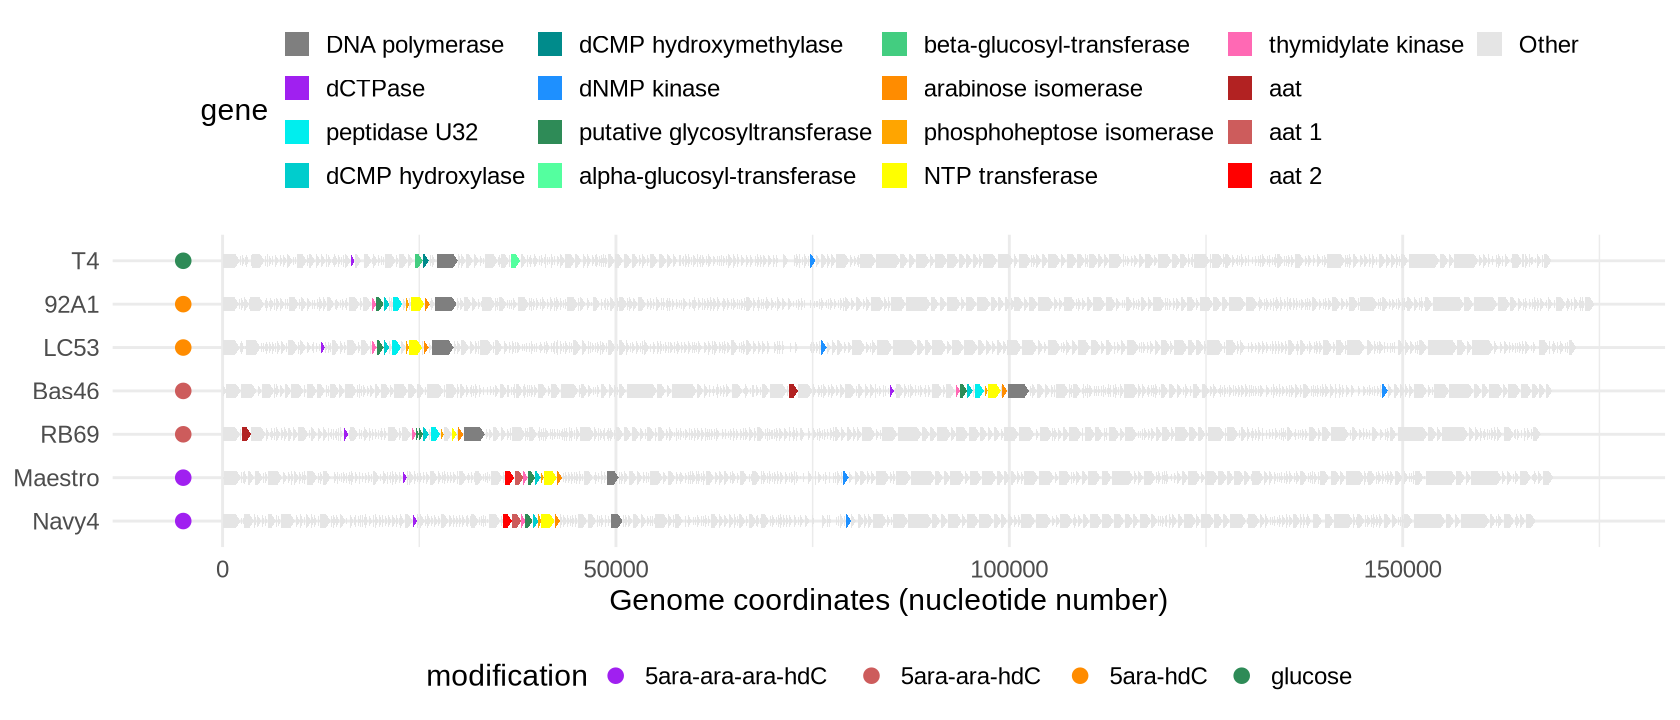

In [29]:
# Visualize genomes
options(repr.plot.width=14, repr.plot.height=6)

## Fetch data
df <- data

## Subset to annotated phages
index <- df %>% group_by(Accession) %>% summarise(annotated = sum(annotation != 'Other')) %>% subset(annotated > 0)
index <- which(df$Accession %in% index[['Accession']])
df <- df[index,]

## Add short names
lookup <- c('T4','Maestro','Bas46','RB69','Navy4','LC53','92A1')
names(lookup) <- unique(df$Name)
df$short_name <- lookup[as.character(df$Name)]

## Create annotations
ann <- df %>% select(Accession, modification, aat, short_name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$short_name <- factor(df$short_name, unique(df$short_name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = short_name, fill = annotation), col=NA,
                    arrowhead_height = unit(3, "mm"), arrowhead_width = unit(1, "mm")
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$known_modification) +
    geom_point(data=ann, aes(x=-5000, y=short_name, col=modification, label=modification), size=4) +
    theme_minimal(18) +
    guides(fill = guide_legend(position = 'top', nrow=4), 
           col = guide_legend(position = 'bottom', nrow=1)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')
fn <- paste0(out_path,'genome-tracks_initial-annotation','.png')
ggsave(fn, width = 14, height = 6, bg='white')

In [30]:
# Investigate gene annotations
options(repr.plot.width=15, repr.plot.height=12)
set.seed(42)

## Select genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']

## Align sequences
index <- which(data$annotation %in% genes)
seq <- AAStringSet(data$protein_seq[index])
names(seq) <- paste(data$acc_protein_key[index])
result <- msa(seq)

use default substitution matrix


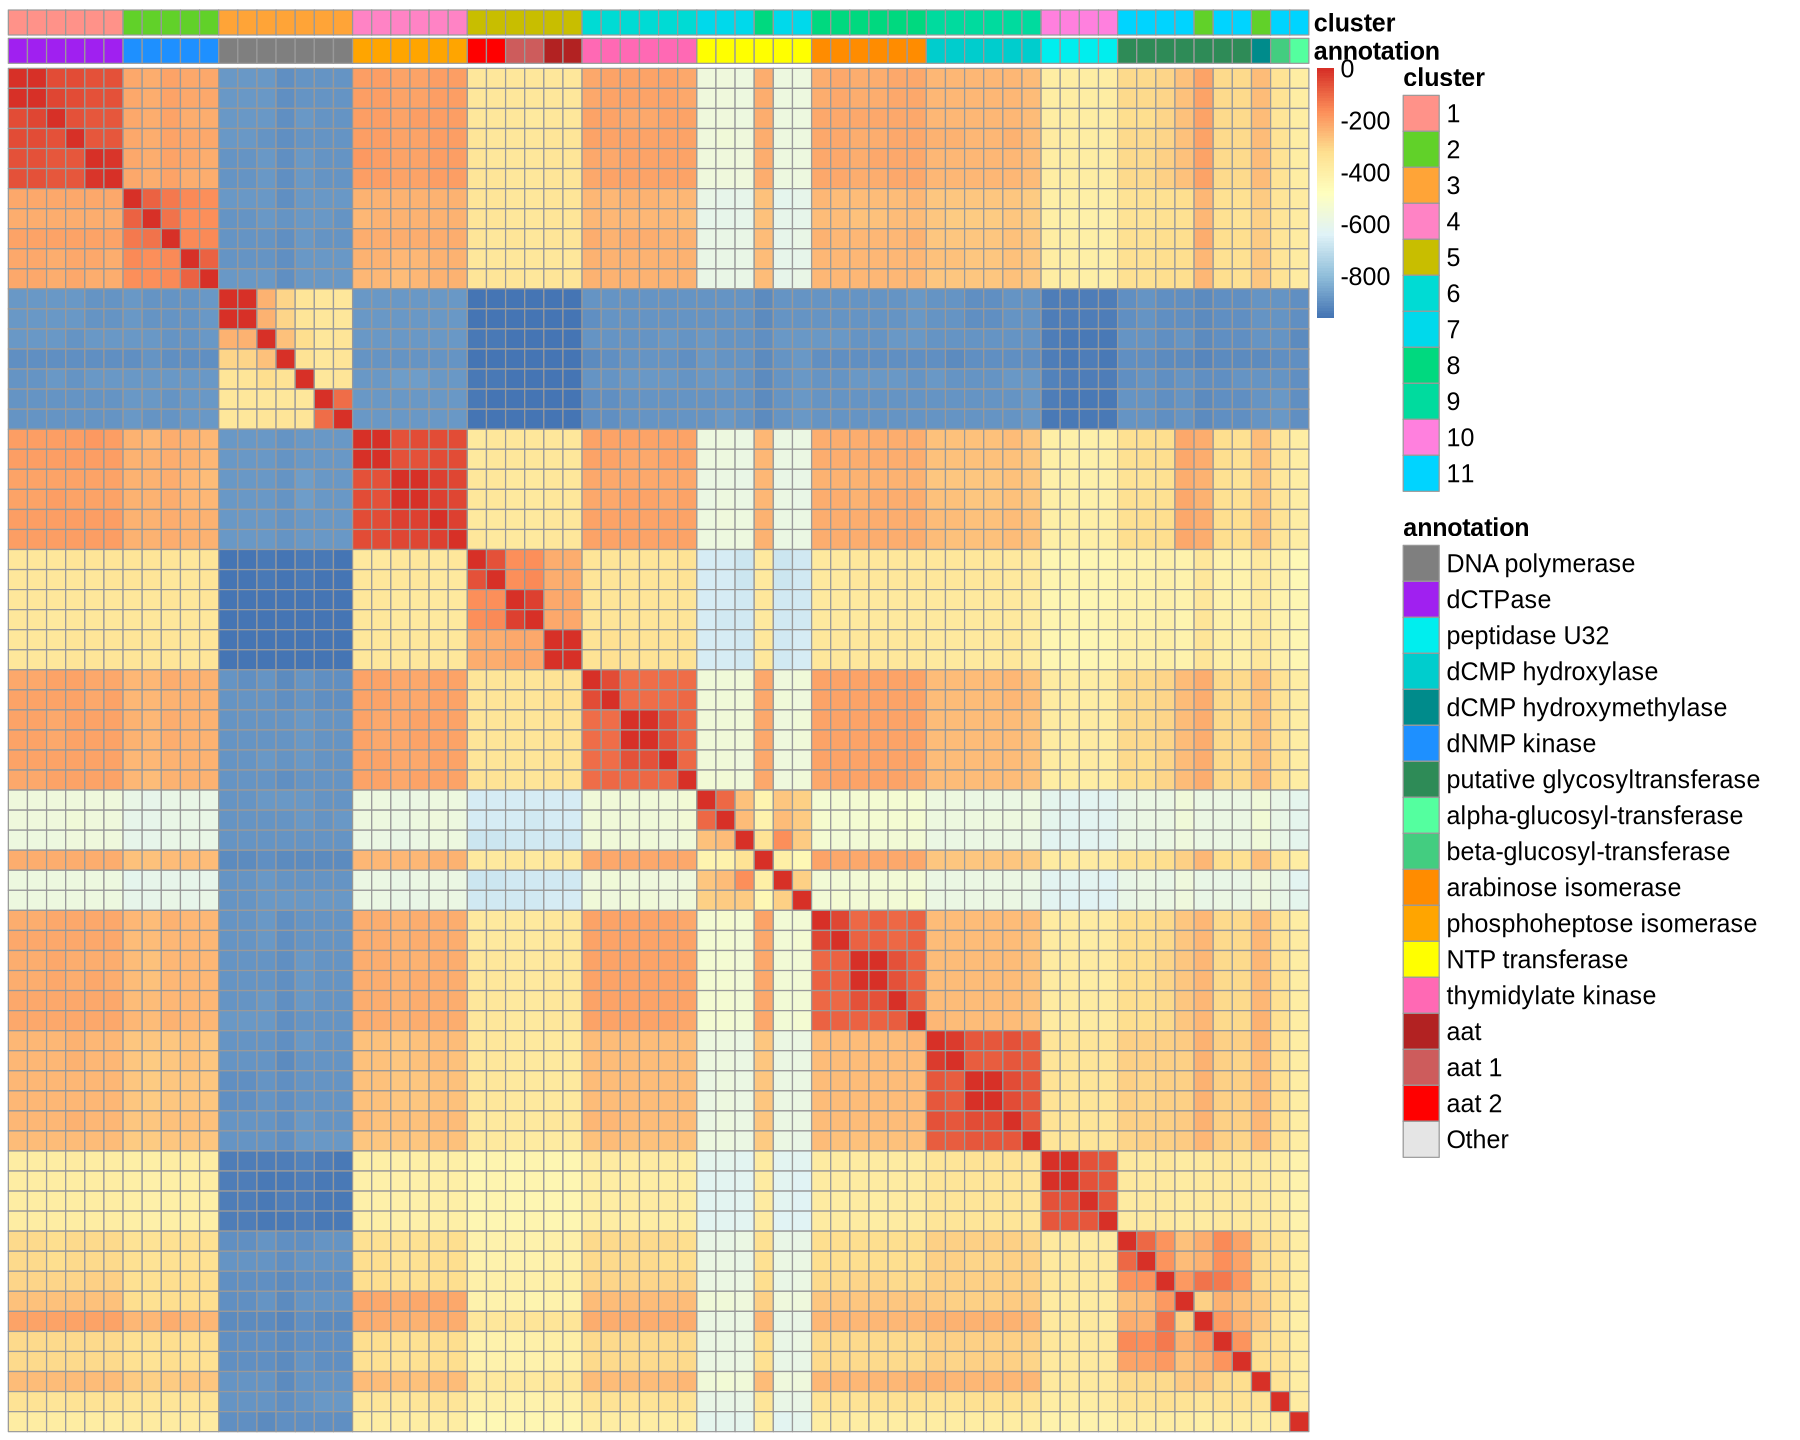

In [31]:
## Calculate distances
dist <- dist.gene(as.AAbin(result))

## Index
ind <- match(result@unmasked@ranges@NAMES, data$acc_protein_key)

## Annotate
rann <- data.frame(
    row.names = make.unique(result@unmasked@ranges@NAMES, sep = '-'),
    annotation = as.character(data$annotation)[ind]
)

## Cluster (TODO: set distance threshold instead of clustering...)
graph <- bluster::makeSNNGraph(minmax(dist), k=5)
clust <- igraph::cluster_leiden(graph, resolution_parameter = 1)
rann$cluster <- factor(clust$membership)

## Order
dist <- as.matrix(dist)
dist <- 1-dist

## Plot
pheatmap(
    mat = dist,
    show_rownames=FALSE, show_colnames=FALSE,
    cluster_rows=FALSE, cluster_cols=FALSE,
    annotation_col = rann, annotation_colors = cols,
    fontsize=15
)

use default substitution matrix
use default substitution matrix


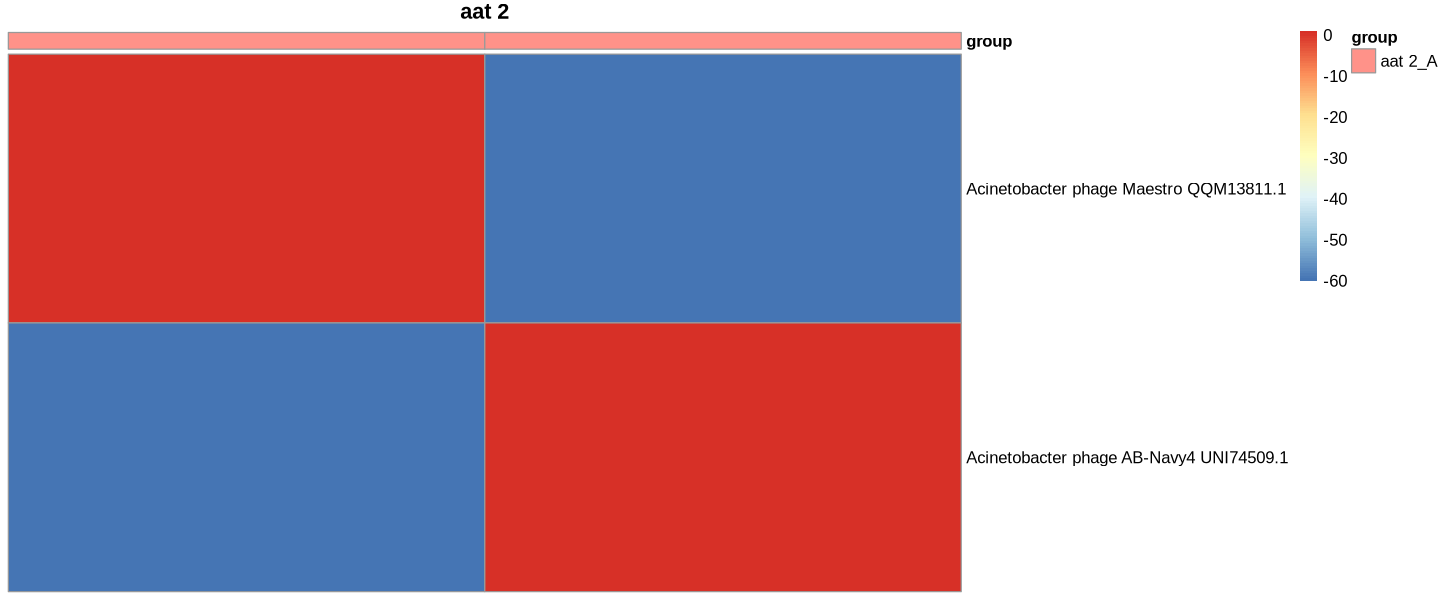

use default substitution matrix


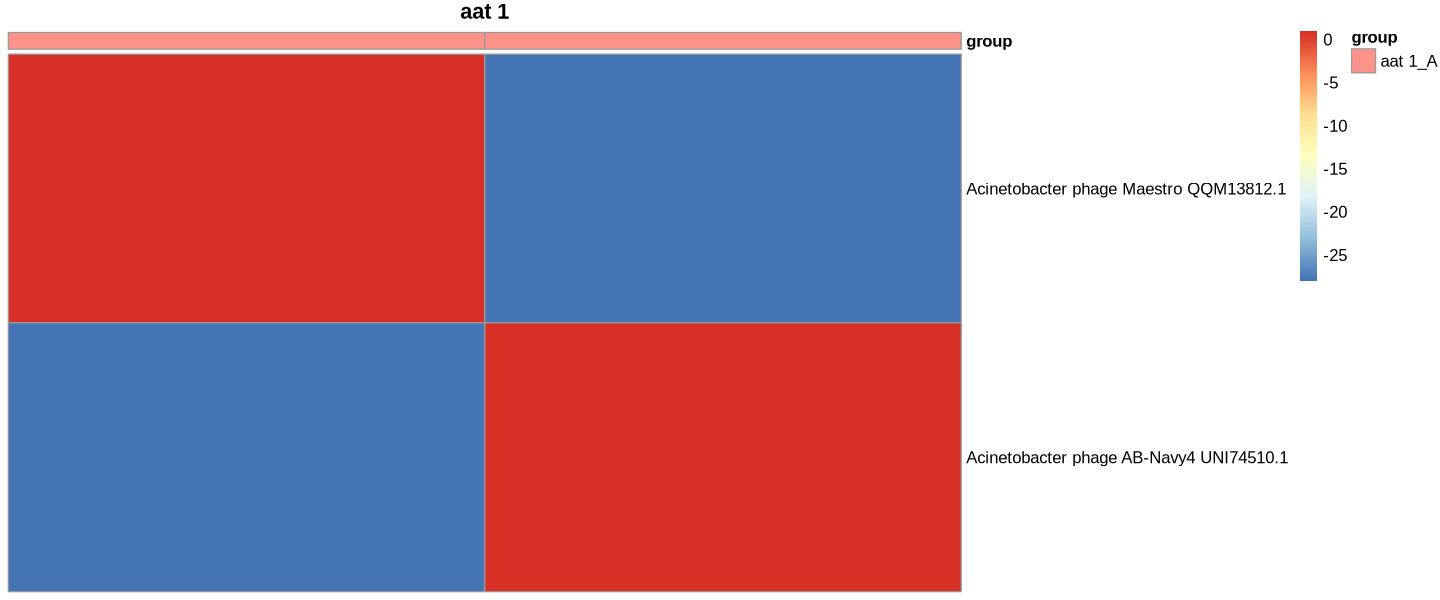

use default substitution matrix


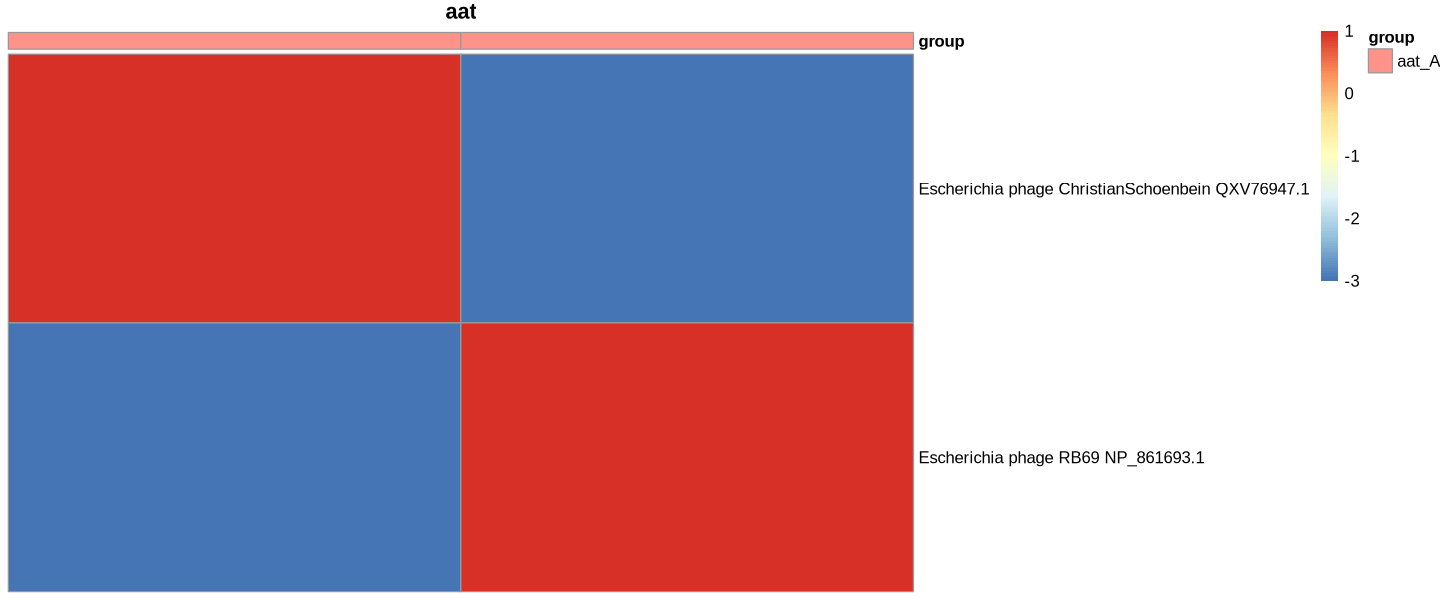

use default substitution matrix


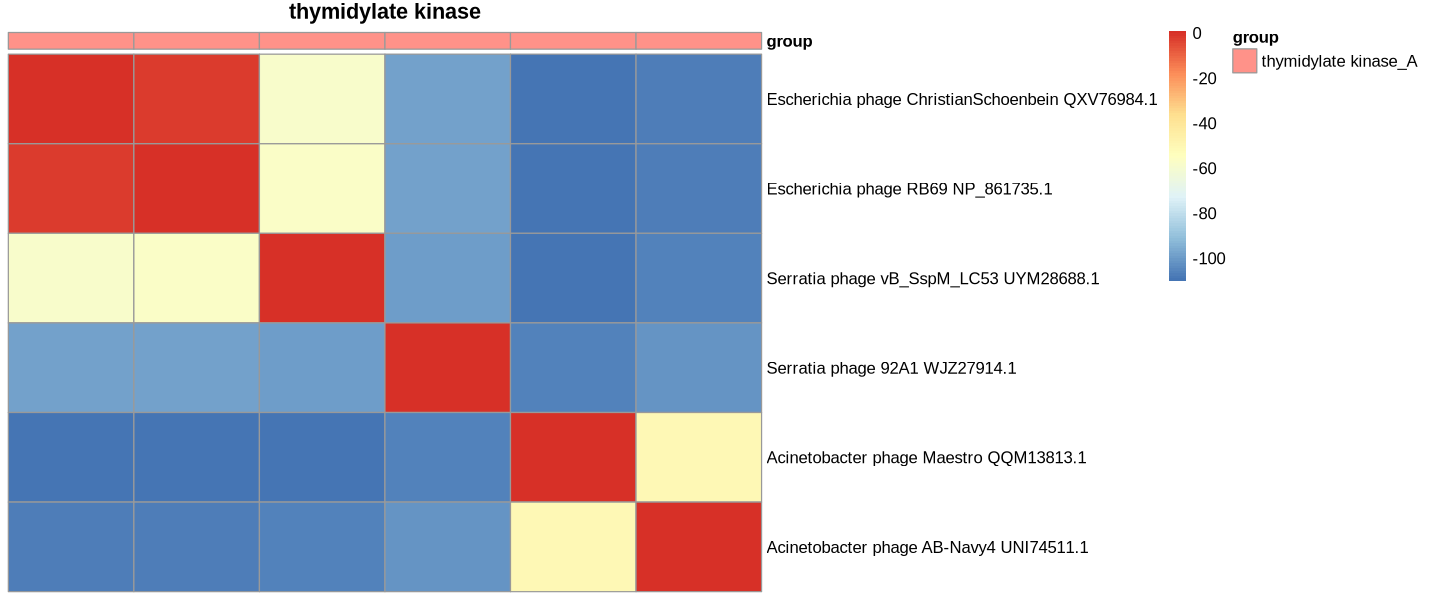

use default substitution matrix


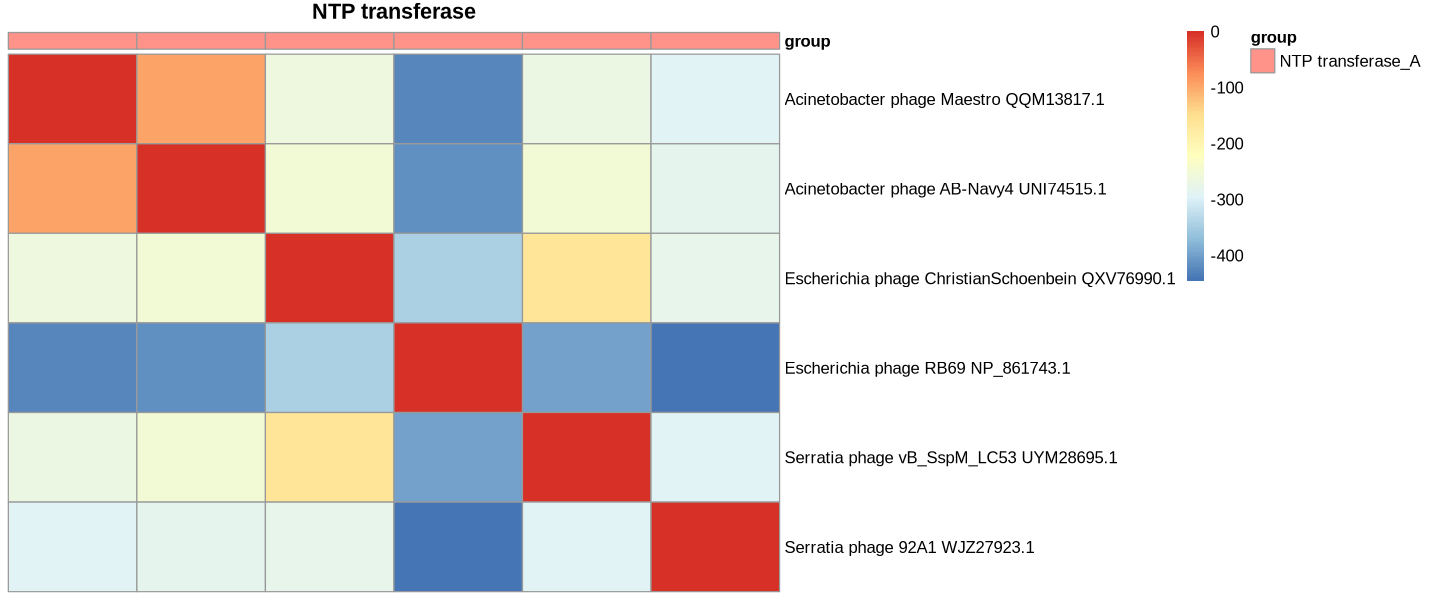

use default substitution matrix


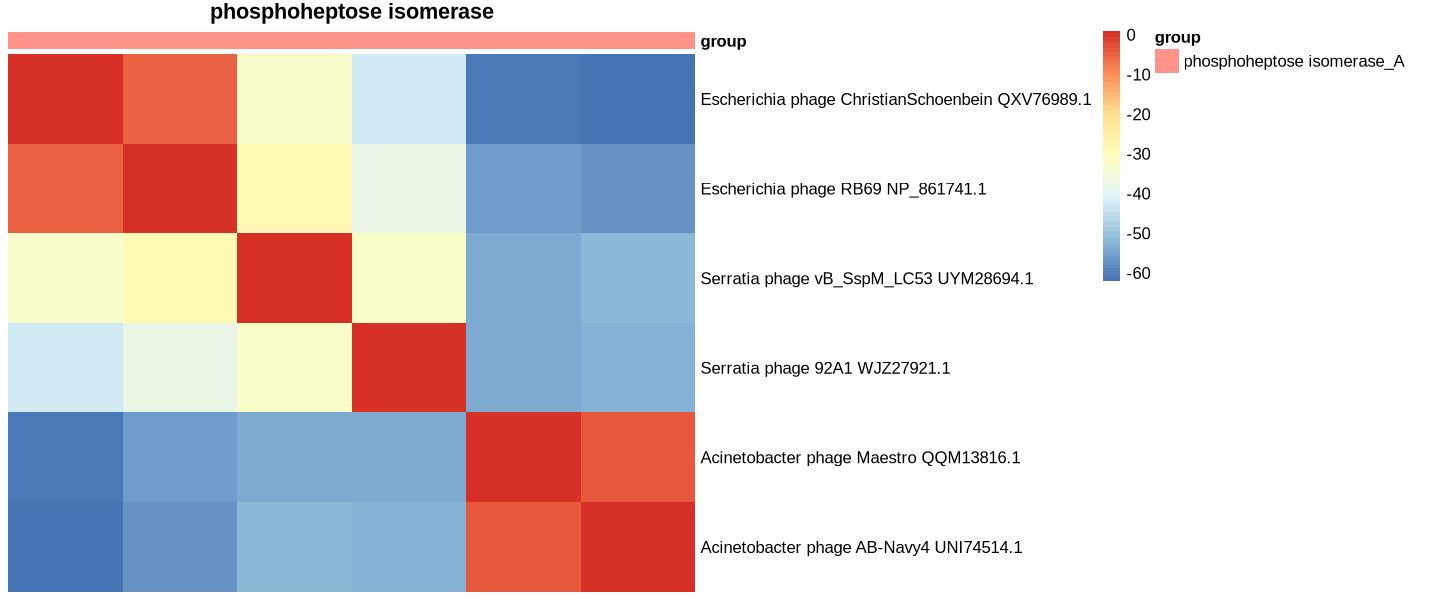

use default substitution matrix


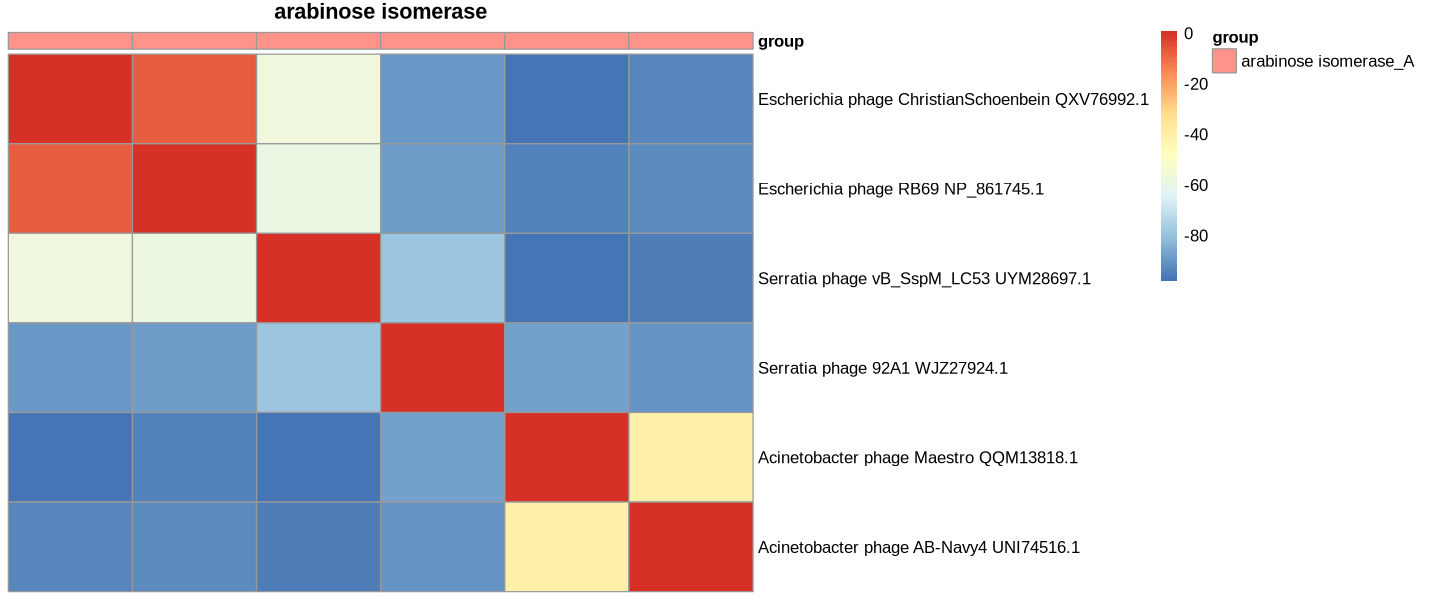

use default substitution matrix


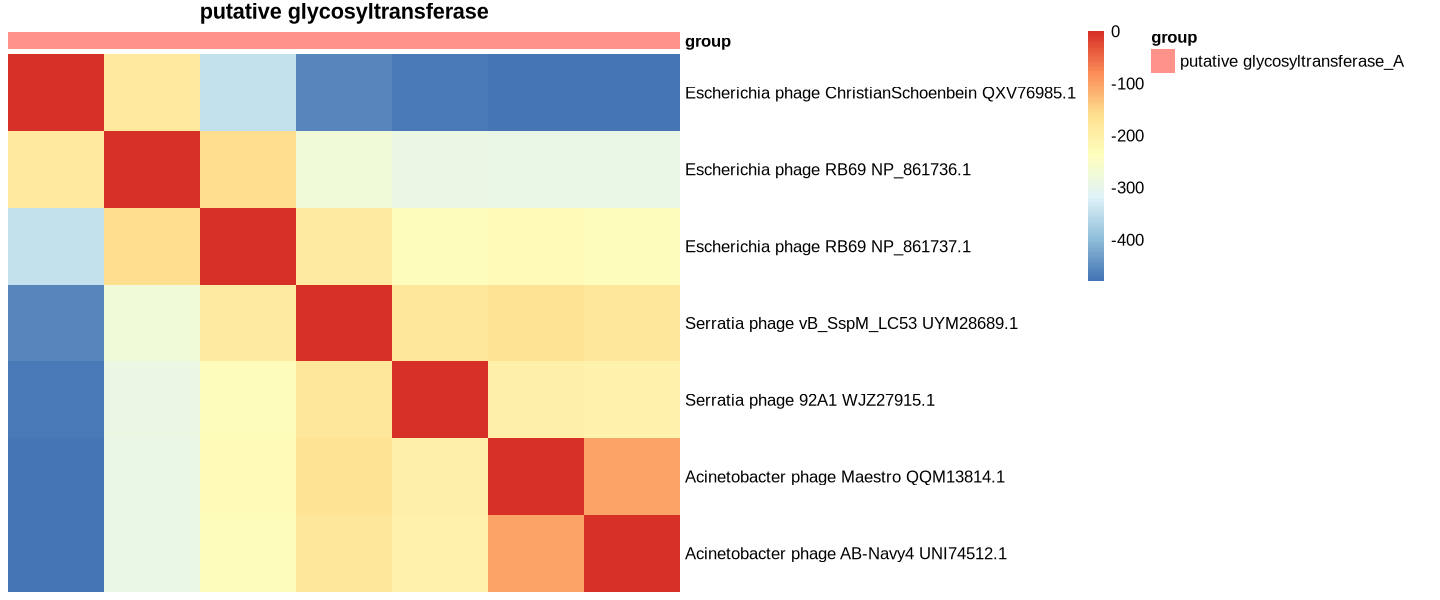

use default substitution matrix


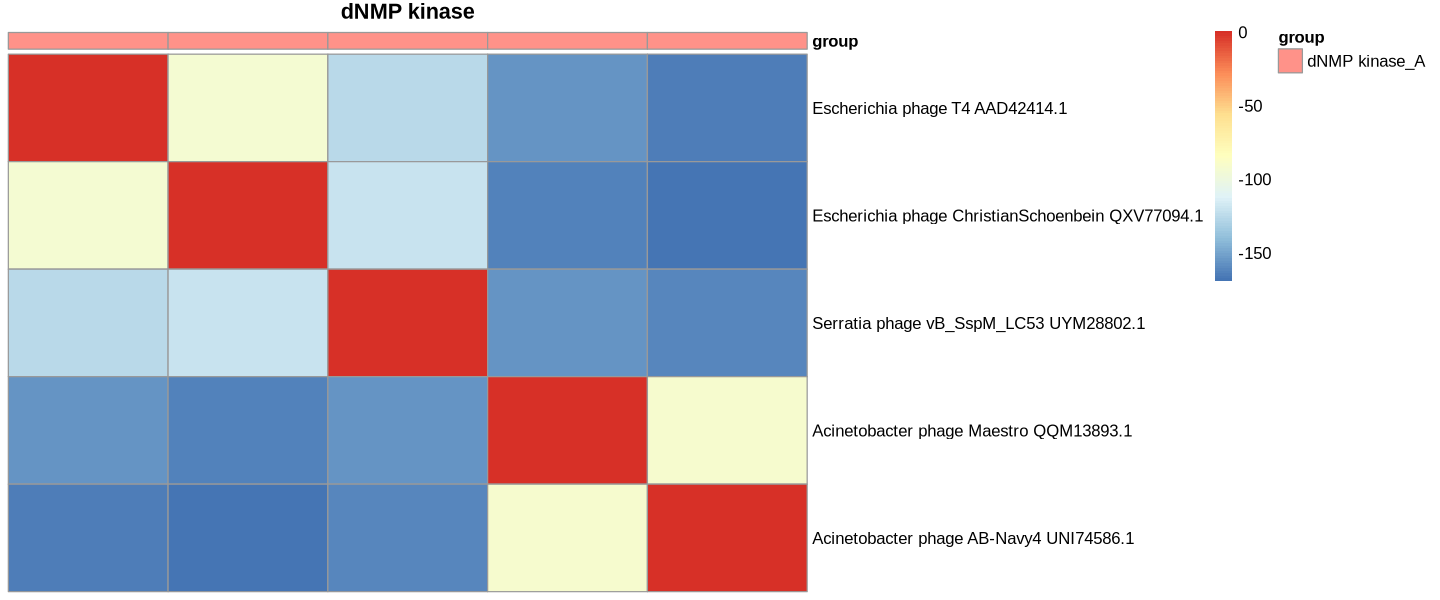

use default substitution matrix


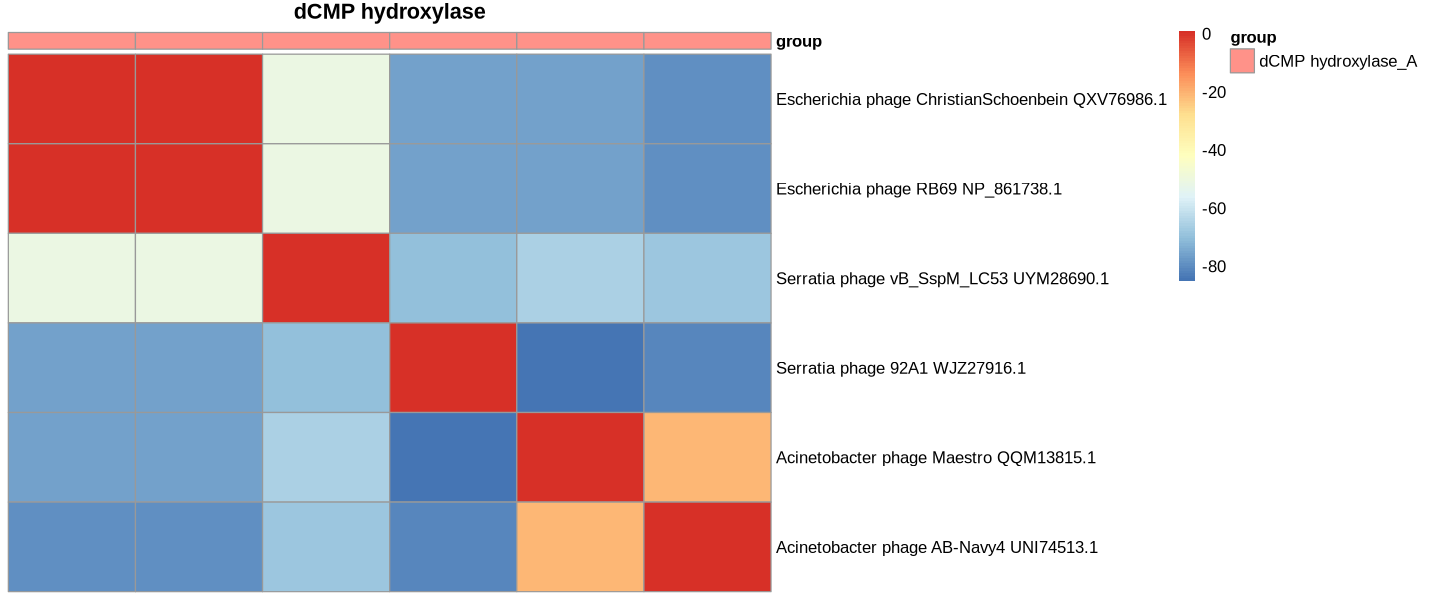

use default substitution matrix


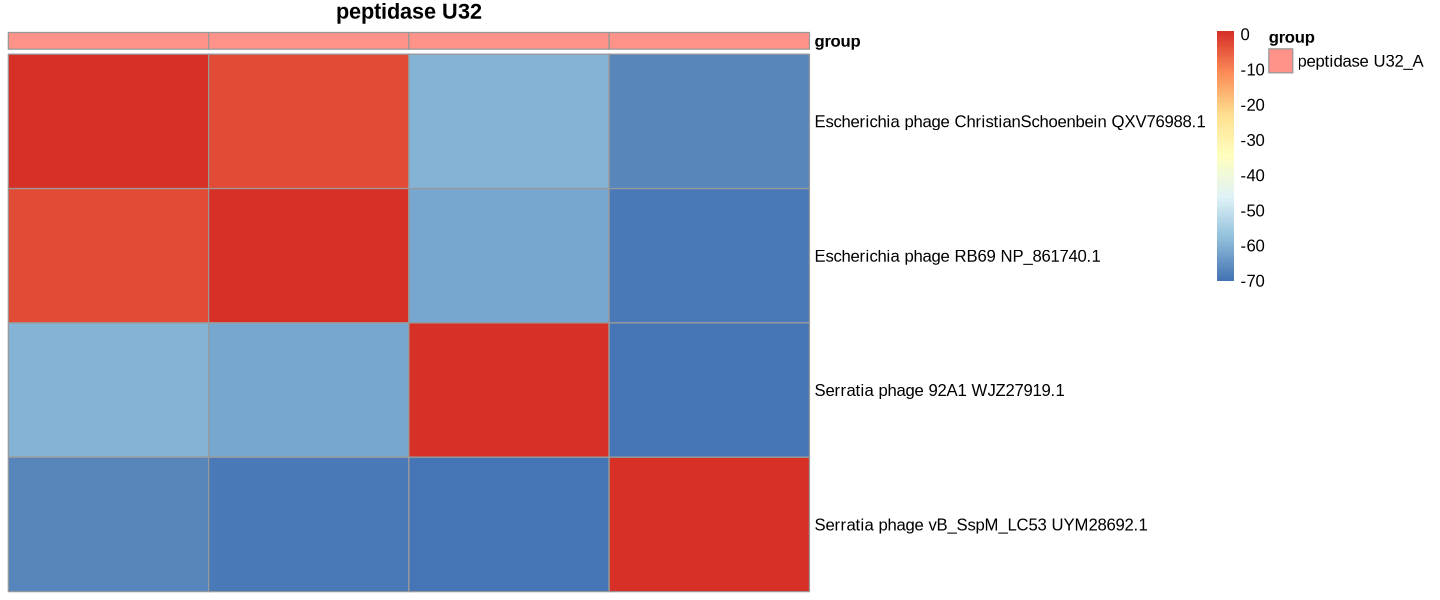

use default substitution matrix


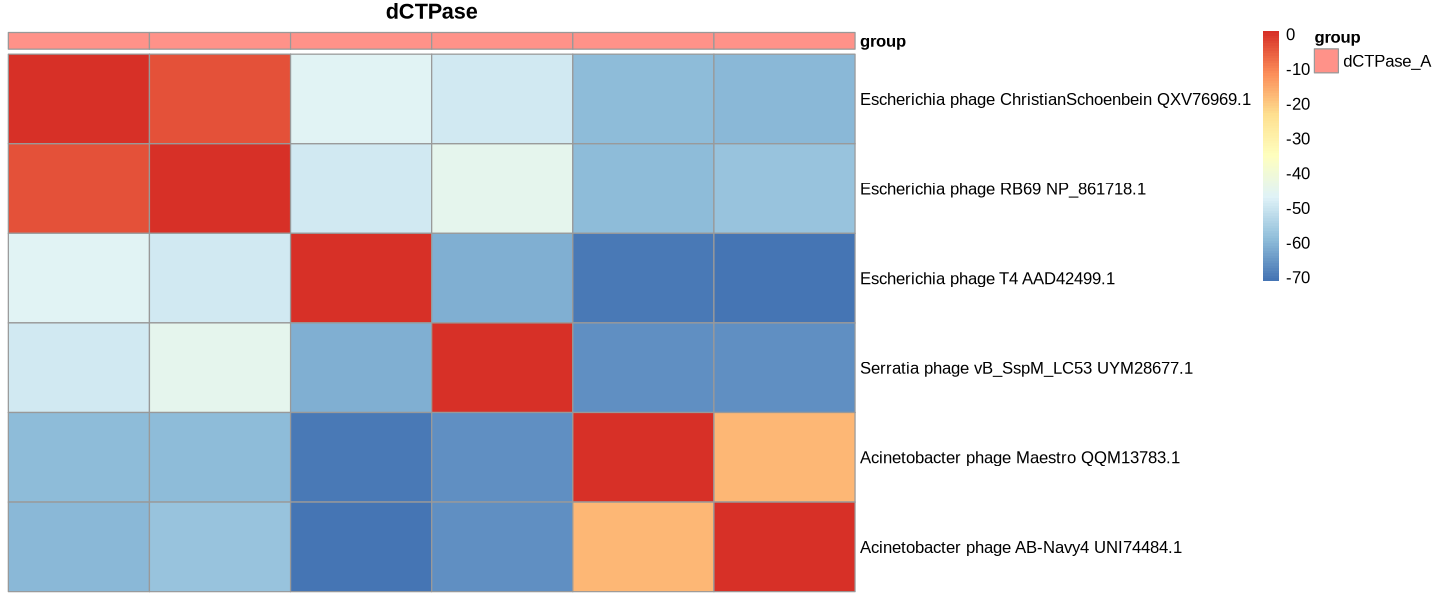

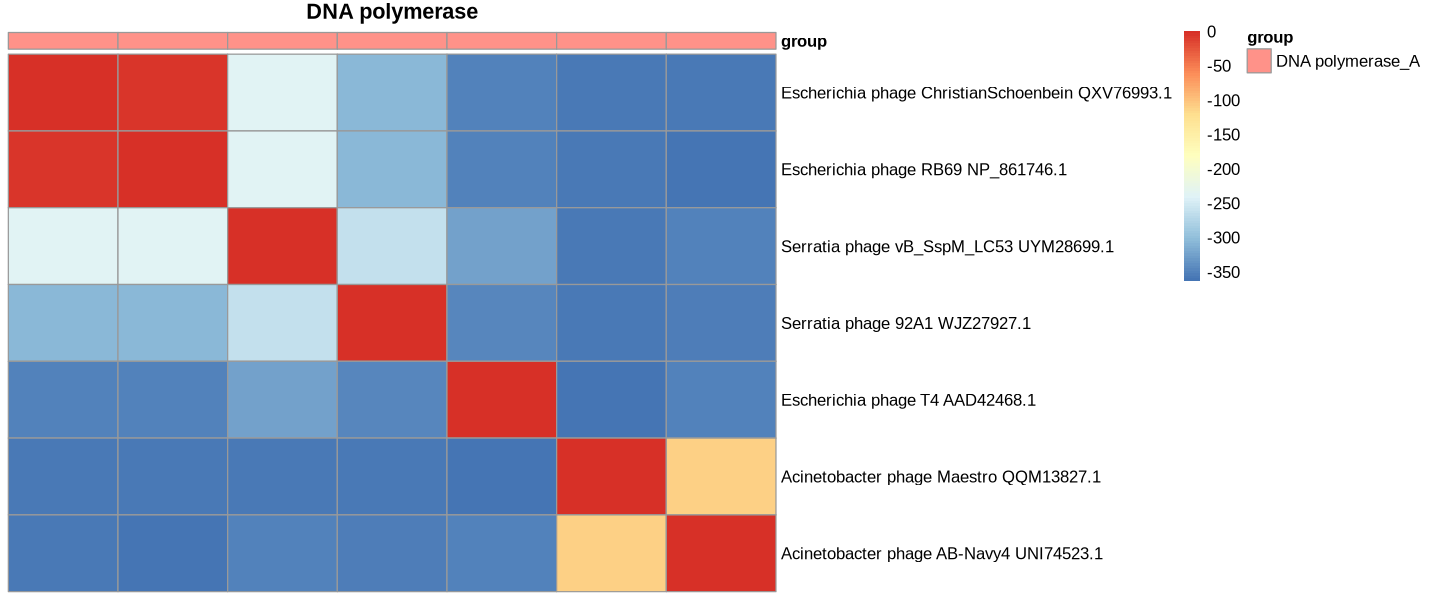

In [32]:
# Clean gene annotations
options(repr.plot.width=12, repr.plot.height=5)

## Variables
dist_threshold <- 1000
data$key <- paste(data$Name, data$Gene.CDS.Protein.FASTA.Accession)

## Set up ann_level_2
data$ann_level_2 <- 'Other'

## Fetch genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Iterate over genes
for (i in genes) {
    index <- which(data$annotation == i)

    if (length(index) < 2) {
        data$ann_level_2[index] <- i
        next
    }
    
    ## MSA
    seq <- AAStringSet(data$protein_seq[index])
    names(seq) <- data$key[index]
    result <- msa(seq)
    result
    
    ## Distance matrix
    dist <- as.matrix(dist.gene(as.AAbin(result)))

    ## Split alignment to homogeneous groups
    x <- dist < dist_threshold
    x <- apply(x, 1, which, simplify = FALSE)
    x <- lapply(x, paste0, collapse='-')
    x <- unlist(x)
    lookup <- LETTERS[1:length(unique(x))]
    names(lookup) <- unique(x)

    ## Annotate groups
    cann <- data.frame(
        row.names = rownames(dist),
        group = paste(i, lookup[x], sep = '_')
    )

    ## Transfer annotation
    index <- match(rownames(cann), data$key)
    data$ann_level_2[index] <- cann$group
    
    ## Plot
    pheatmap(1-dist, 
             cluster_cols = FALSE, cluster_rows = FALSE,
             annotation_col = cann, show_colnames=FALSE,
             show_rownames = TRUE, labels_row = result@unmasked@ranges@NAMES, fontsize=10, main=i
            )
}

In [33]:
index <- str_detect(unique(data$ann_level_2),'B')
if (!any(index)) {
    message('No group has been split (no group B present). Removing _A...')
    data$ann_level_2 <- str_remove(data$ann_level_2, '_A')
}

No group has been split (no group B present). Removing _A...



In [34]:
# Convert ann_level to factor
data$ann_level_2 <- factor(data$ann_level_2, unique(data$ann_level_2[order(data$annotation, decreasing = FALSE)]))
levels(data$ann_level_2)

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

In [101]:
# Refine annotations
options(repr.plot.width=10, repr.plot.height=5)

genes <- levels(data$ann_level_2)
genes <- genes[genes != 'Other']
genes <- rev(genes)
genes

## Check spelling
all(genes %in% levels(data$ann_level_2))

## Iterate annotation over genes
pred <- list()
for (gene in genes) {
    pred[[gene]] <- annotate_gene_by_hmm_profile(
        data, annotation = 'ann_level_2', gene = gene, 
        search_db = fs$training$protein, n_cores = 8, print_histogram = FALSE,
        e_value_treshold = 1e-5, dir = out_annotation
    )
    pred[[gene]]$annotation <- gene
}

[1] "aat 2"                        "aat 1"                       
 [3] "aat"                          "thymidylate kinase"          
 [5] "NTP transferase"              "phosphoheptose isomerase"    
 [7] "arabinose isomerase"          "beta-glucosyl-transferase"   
 [9] "alpha-glucosyl-transferase"   "putative glycosyltransferase"
[11] "dNMP kinase"                  "dCMP hydroxymethylase"       
[13] "dCMP hydroxylase"             "peptidase U32"               
[15] "dCTPase"                      "DNA polymerase"

[1] TRUE

Warning message:
“Removed 51 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_bar()`).”


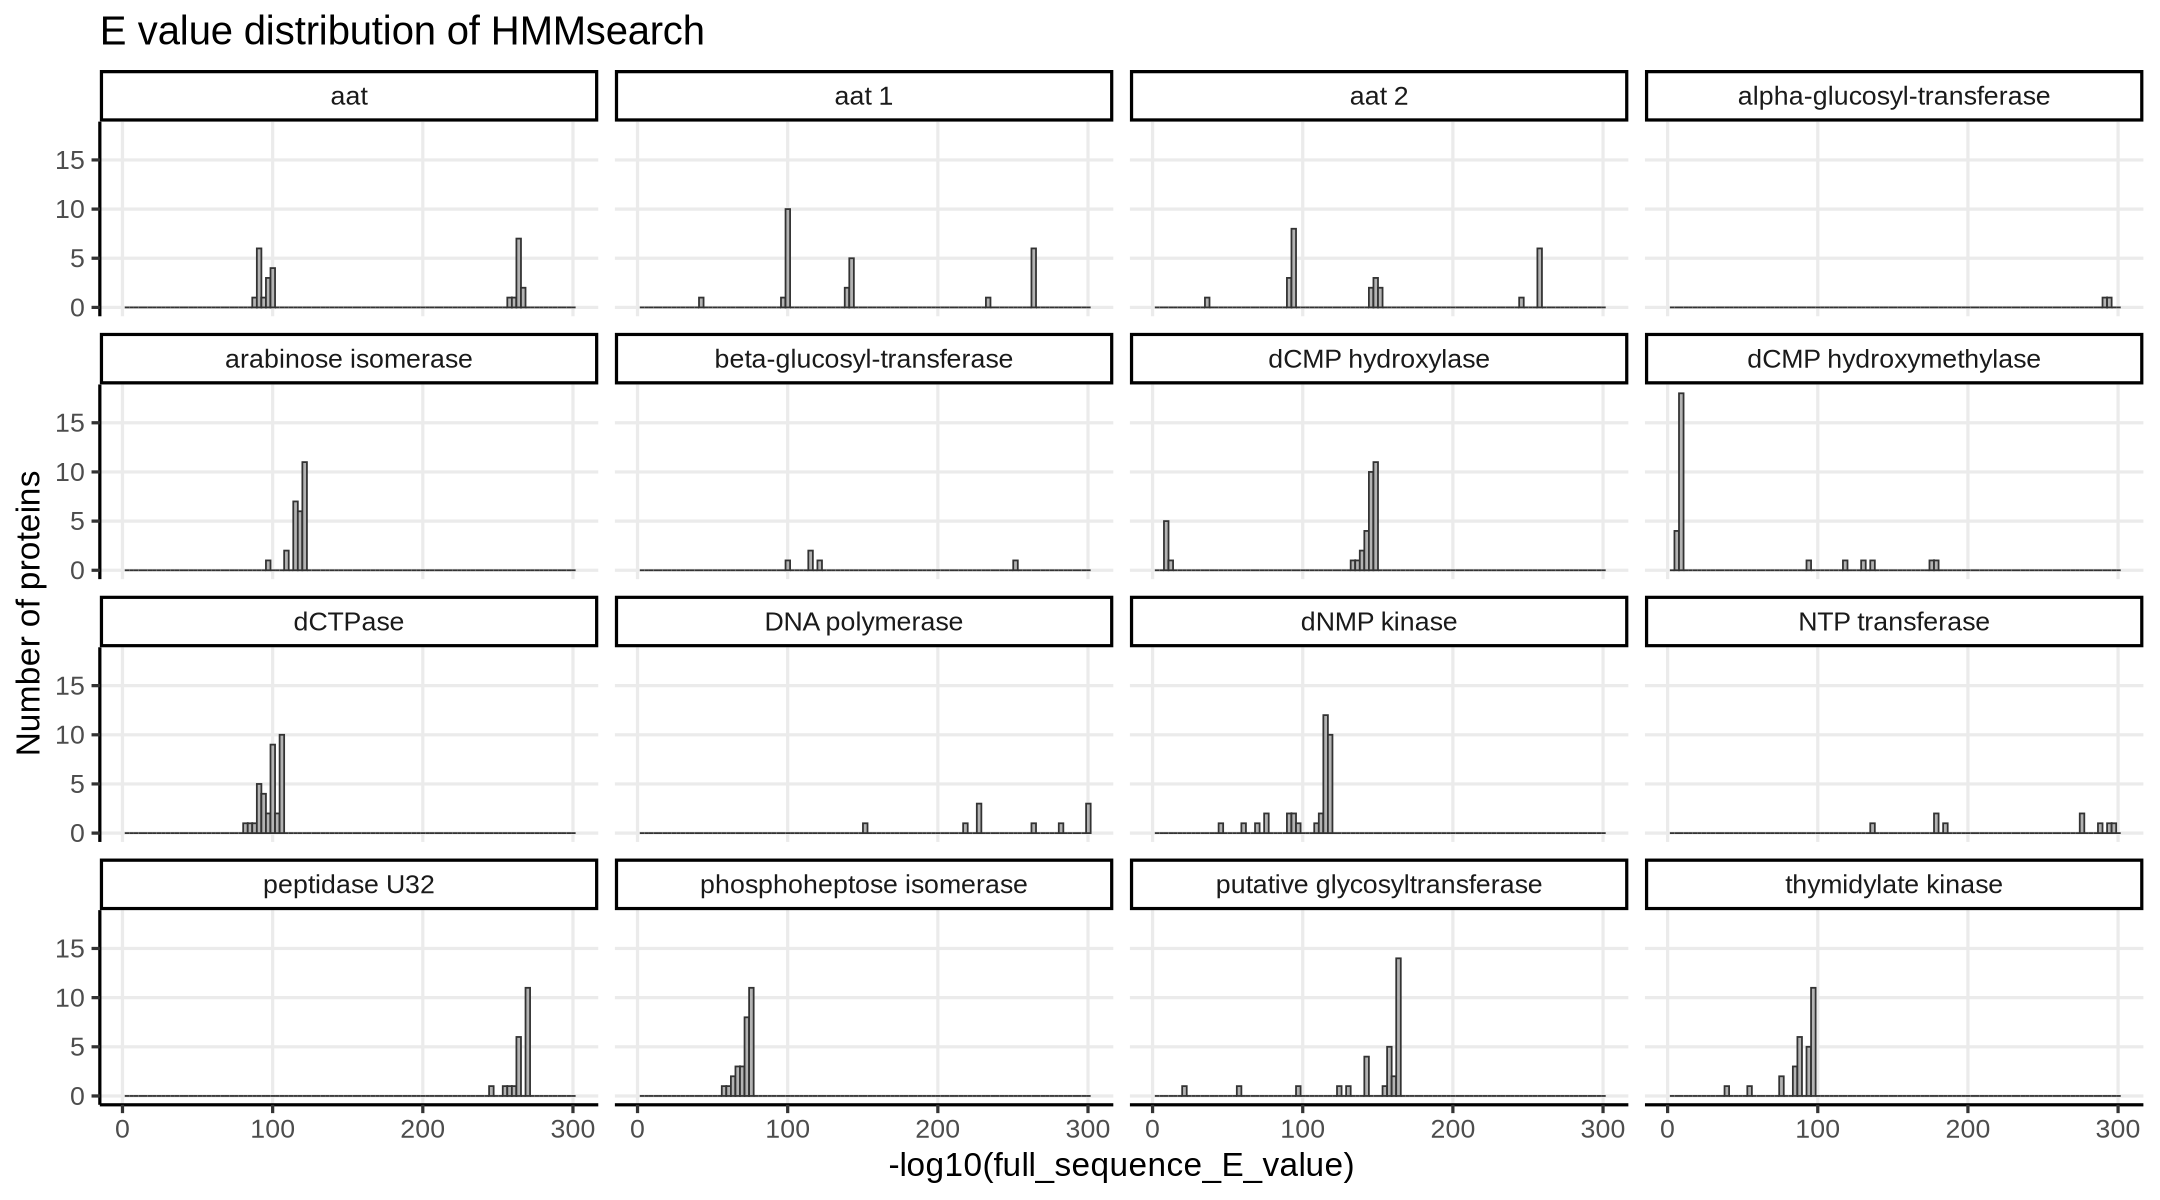

In [112]:
# Histograms of E-values
options(repr.plot.width=18, repr.plot.height=10)

## Format result
result <- do.call('rbind', pred)

## Plot
ggplot(result, aes(-log10(full_sequence_E_value))) +
  geom_histogram(bins = 100, fill='grey70', col='grey20') +
  facet_wrap(~annotation, scales = 'fixed') +
      scale_x_continuous(limits = c(0, NA)) +
      theme_classic(20) +
      theme(
          panel.grid.major = element_line()
      ) +
      labs(y = 'Number of proteins', title = 'E value distribution of HMMsearch')

In [113]:
## Pool
result <- do.call('rbind', pred) %>% select(Sequence, annotation, full_sequence_E_value)
result <- pivot_wider(result, names_from = Sequence, values_from = full_sequence_E_value, values_fill = 1)
result <- result %>% as.data.frame()
row.names(result) <- result$annotation
result <- result[,-1]
result[result == 0] <- 1e-300

Adding missing grouping variables: `Accession`


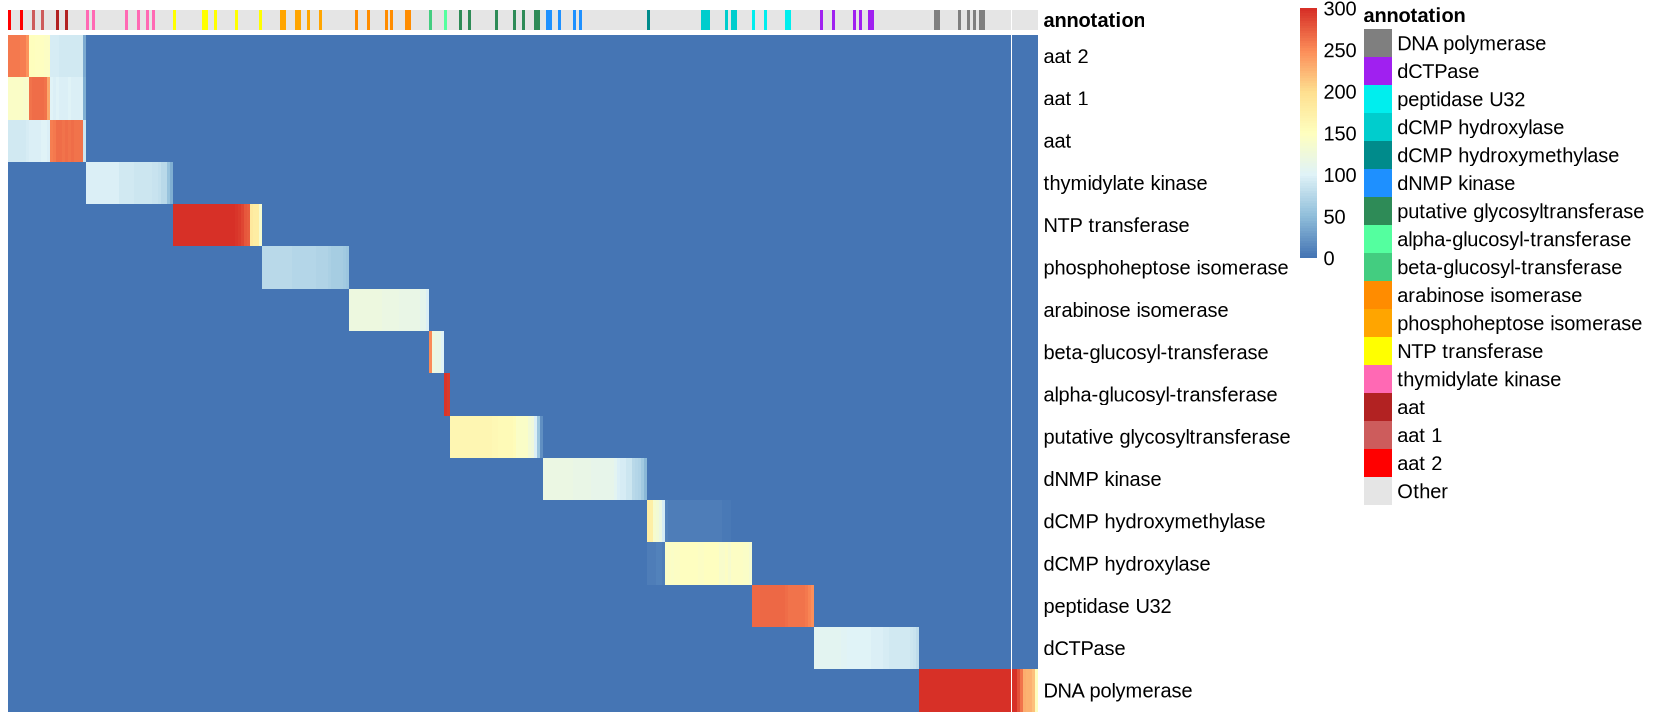

In [114]:
options(repr.plot.width=14, repr.plot.height=6)

## Column annotation
index <- match(colnames(result), data$Gene.CDS.Protein.FASTA.Sequence.ID)
cann <- data[index,] %>% select(Gene.CDS.Protein.FASTA.Sequence.ID, annotation) %>% as.data.frame()
rownames(cann) <- cann$Gene.CDS.Protein.FASTA.Sequence.ID
cann <- cann %>% select(annotation)

## Plot
p1 <- pheatmap(
    -log10(result), 
    cluster_cols = FALSE, cluster_rows = FALSE,
    annotation_col = cann, annotation_colors = cols,
    show_colnames=FALSE,
    fontsize=12
)
fn <- paste0(out_path,'heatmap_training-hmmsearch','.png')
ggsave(fn, p1, width = 14, height = 6, bg='white')

In [115]:
## Vote
lookup <- character(length = ncol(result))
for (n in 1:ncol(result)) {
    v <- result[,n]
    names(v) <- str_split(rownames(result), '_', simplify = TRUE)[,1]
    n_min <- min(v)
    lookup[[n]] <- unique(names(which(v == min(v))))
}
index <- match(colnames(result), data$Gene.CDS.Protein.FASTA.Sequence.ID)
data$annotation[index] <- lookup

In [116]:
# Manually re-name putative glucosyltransferase
index <- data$modification == 'glucose' & data$annotation == 'putative glycosyltransferase'
data$Name[index]
data$annotation[index]
data$annotation[index] <- 'alpha-glucosyl-transferase'

[1] "Serratia phage PS2"

[1] putative glycosyltransferase
17 Levels: DNA polymerase dCTPase peptidase U32 ... Other

Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”
Warning message:
“Removed 223 rows containing missing values or values outside the scale range
(`geom_gene_arrow()`).”


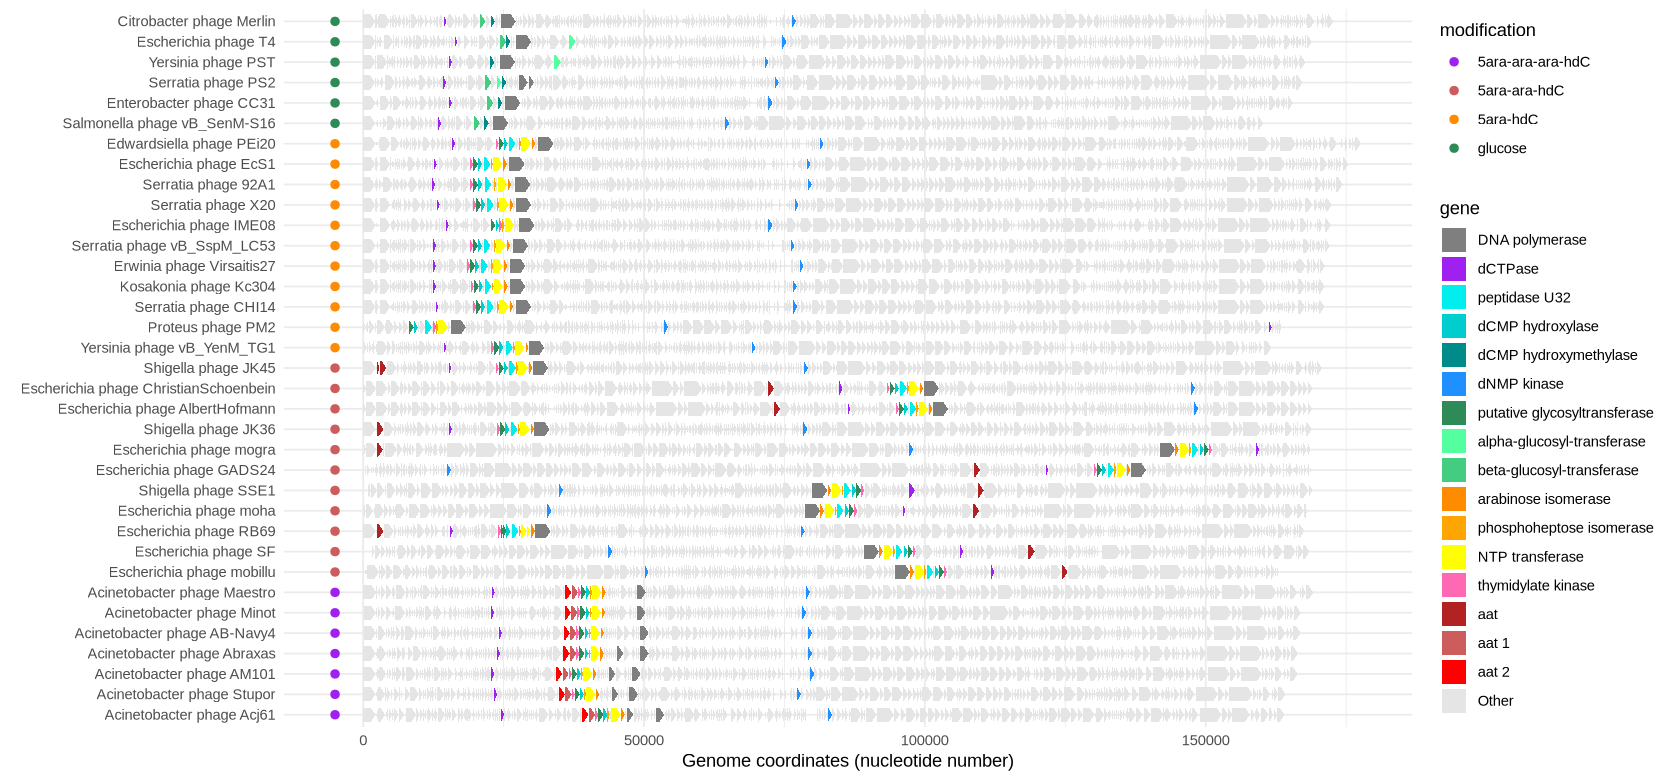

In [117]:
# Visualize genomes
options(repr.plot.width=14, repr.plot.height=6.5)

## Fetch data
df <- data

## Create annotations
ann <- df %>% select(Accession, modification, aat, Name) %>% unique()

## Order
df <- df[order(df$modification, df$genomeSize), ]
df$Name <- factor(df$Name, unique(df$Name))

# Plot
ggplot(df) +
    geom_gene_arrow(aes(
        xmin = Gene.CDS.Nucleotide.FASTA.Range.Start, xmax = Gene.CDS.Nucleotide.FASTA.Range.Stop, 
        y = Name, fill = annotation), col=NA,
                    arrowhead_height = unit(3, "mm"), arrowhead_width = unit(1, "mm")
                   ) +
    scale_fill_manual(values = cols$annotation) +
    scale_color_manual(values = cols$known_modification) +
    geom_point(data=ann, aes(x=-5000, y=Name, col=modification), size=2) +
    theme_minimal(11) +
    guides(fill = guide_legend(position = 'right', nrow=17), 
           col = guide_legend(position = 'right', nrow=4)
          ) +
    labs(x = "Genome coordinates (nucleotide number)", y = NULL, fill='gene')
fn <- paste0(out_path,'genome-tracks_training-annotation','.png')
ggsave(fn, width = 14, height = 6.5, bg='white')

In [118]:
# Save training features

## Add colors as attribute
attr(data, 'colors') <- cols

## Write
fn <- paste0(out_path,'training_features','.Rds')
saveRDS(data, fn)

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.


[1] FALSE


        Multiple aat        Aat 1 & aat 2           Single aat 
                   1                    7                   10 
              No aat              glucose None (any predicted) 
                  11                    6                    0 
                None 
                   0 


           None   Glucosylation Arabinosylation 
              0               6              29 

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

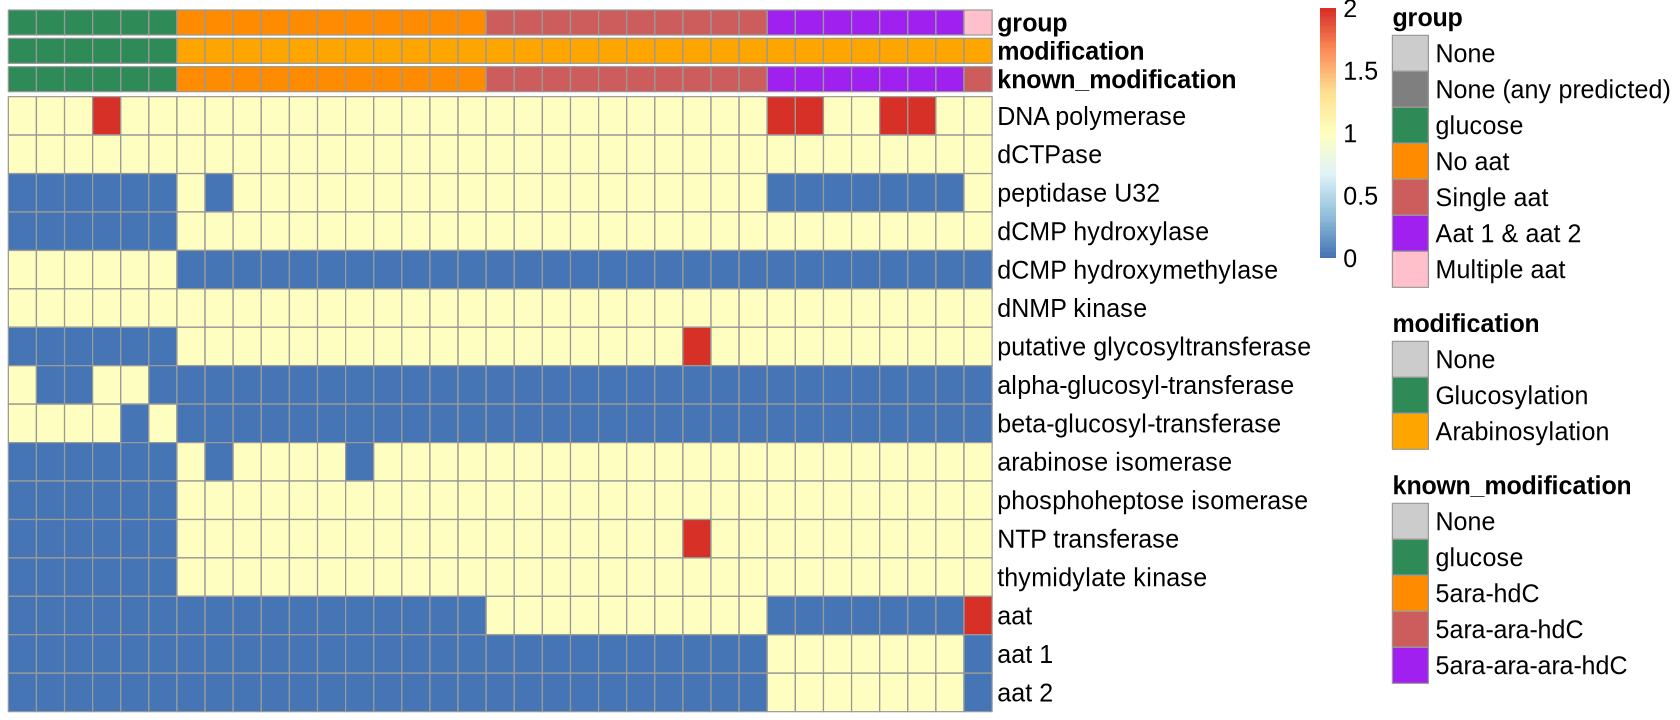

In [119]:
# Feature quantification
options(repr.plot.width=14, repr.plot.height=6)

heatmap_genes <- c('DNA pol','DNA clamp','NTP transfer','Thy syn','dCTPase','Hydroxylase','Pep U32','dNMP kinase','Glu transfer',
                   'Ara iso','pHep iso','Thy kin','Aat')
heatmap_genes <- levels(data$annotation)
heatmap_genes <- heatmap_genes[heatmap_genes != 'Other']

## Summarize gene counts
df <- data %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- df$annotation %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()

## Binarize
bat <- mat > 0

### Row
rann <- data.frame(
    row.names = rownames(mat)#, group = c('Generic','Generic','Generic','Glucosylation','Arabinosylation','Arabinosylation','Generic','Generic','Arabinosylation','Arabinosylation','Arabinosylation')
)
#rann$group <- factor(rann$group, names(cols$group))

### Col
index <- match(colnames(mat), data$Accession)
cann <- data.frame(
    row.names = colnames(mat),
    known_modification = data$modification[index]
)

##  Cluster

### Level 1
gluc_genes <- c('dCMP hydroxymethylase','alpha-glucosyl-transferase','beta-glucosyl-transferase')
ara_genes <- c('dCMP hydroxylase','putative glycosyltransferase','arabinose isomerase',
               'phosphoheptose isomerase','thymidylate kinase')
ind_gluc <- which(colSums(bat[gluc_genes,]) > 1)
ind_ara <- which(colSums(bat[ara_genes,]) > 1)
any(intersect(ind_gluc, ind_ara))

cann$modification <- 'None'
cann$modification[ind_gluc] <- 'Glucosylation'
cann$modification[ind_ara] <- 'Arabinosylation'
cann$modification <- factor(cann$modification, names(cols$modification))

### Level 2
cann$group <- 'None (any predicted)'
cann$group[cann$modification == 'Glucosylation'] <- 'glucose'
cann$group[cann$modification == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) < 1] <- 'No aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat',] == 1] <- 'Single aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat',] > 1] <- 'Multiple aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat 1',] == 1 & mat['aat 2',] == 1] <- 'Aat 1 & aat 2'
cann$group[cann$modification == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) > 2] <- 'Multiple aat'
cann$group <- factor(cann$group, rev(names(cols$group)))

## Order
mat <- mat[,order(cann$group, cann$modification, decreasing = c(TRUE, FALSE), method = 'radix')]
#mat <- mat[,order(cann$modification, decreasing = TRUE, method = 'radix')]

## Plot
p1 <- pheatmap(mat, 
               cluster_rows = FALSE, cluster_cols=FALSE,
               show_colnames=FALSE, annotation_colors=cols,
               annotation_col = cann,
               fontsize = 15,
               #gaps_col             = head(as.numeric(cumsum(table(cann$group)[table(cann$group) > 0])), -1),
               #gaps_row             = head(as.numeric(cumsum(table(rann$group)[table(rann$group) > 0])), -1)
              )

## Quantify
table(cann$group)
table(cann$modification)
levels(data$annotation)

## Save
fn <- paste0(out_path,'heatmap_training-quantification','.png')
ggsave(fn, p1, width = 14, height = 6, bg='white')

In [120]:
index <- data$Accession %in% names(which(mat['DNA polymerase',] > 1)) & data$annotation == 'DNA polymerase'
data[index, c('Name','Gene.CDS.Name')]

Name                        Gene.CDS.Name       
1  Acinetobacter phage Stupor  split DNA polymerase
2  Acinetobacter phage Stupor  split DNA polymerase
3  Acinetobacter phage Abraxas split DNA polymerase
4  Acinetobacter phage Abraxas split DNA polymerase
5  Acinetobacter phage Acj61   DNA polymerase      
6  Acinetobacter phage Acj61   DNA polymerase      
7  Serratia phage PS2          DNA polymerase      
8  Serratia phage PS2          DNA polymerase      
9  Acinetobacter phage AM101   DNA polymerase      
10 Acinetobacter phage AM101   DNA polymerase

In [121]:
index <- data$Accession %in% names(which(mat['aat',] > 1)) & data$annotation == 'aat'
data[index, c('Name','Gene.CDS.Name','Gene.CDS.Protein.FASTA.Sequence.ID')]

Name                Gene.CDS.Name        Gene.CDS.Protein.FASTA.Sequence.ID
1 Shigella phage JK45 hypothetical protein YP_010076081.1:1-136              
2 Shigella phage JK45 hypothetical protein YP_010076082.1:1-366

use default substitution matrix
use default substitution matrix


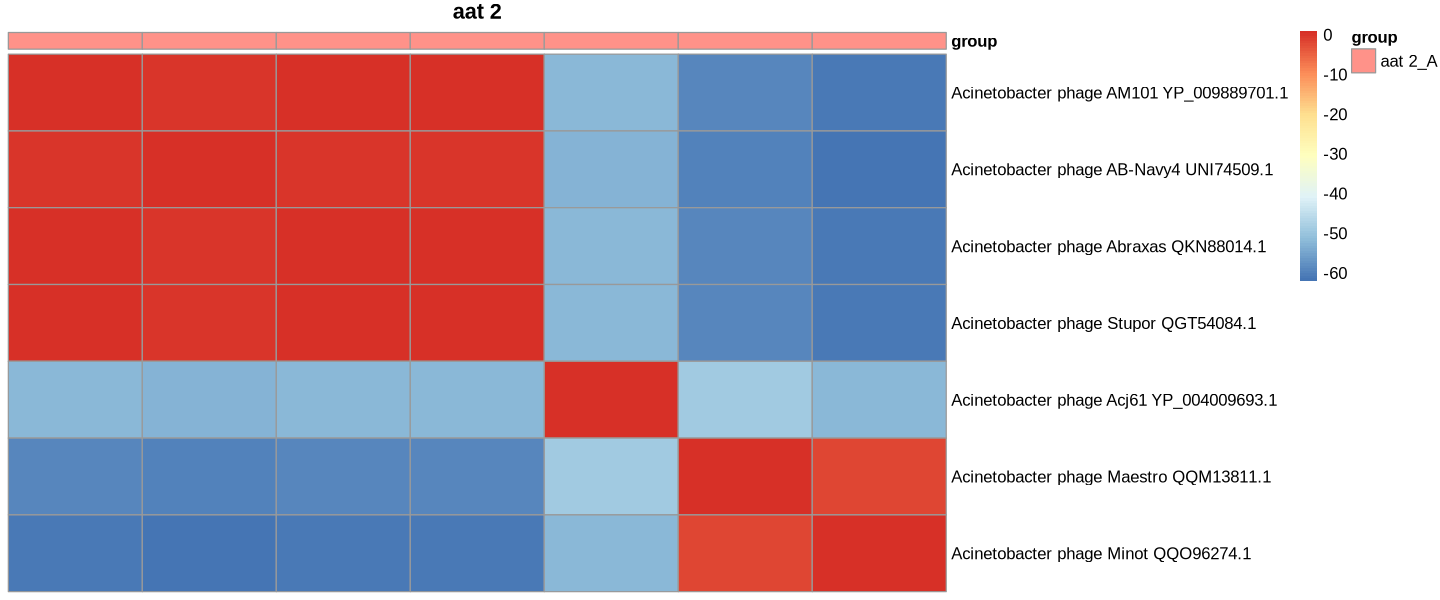

use default substitution matrix


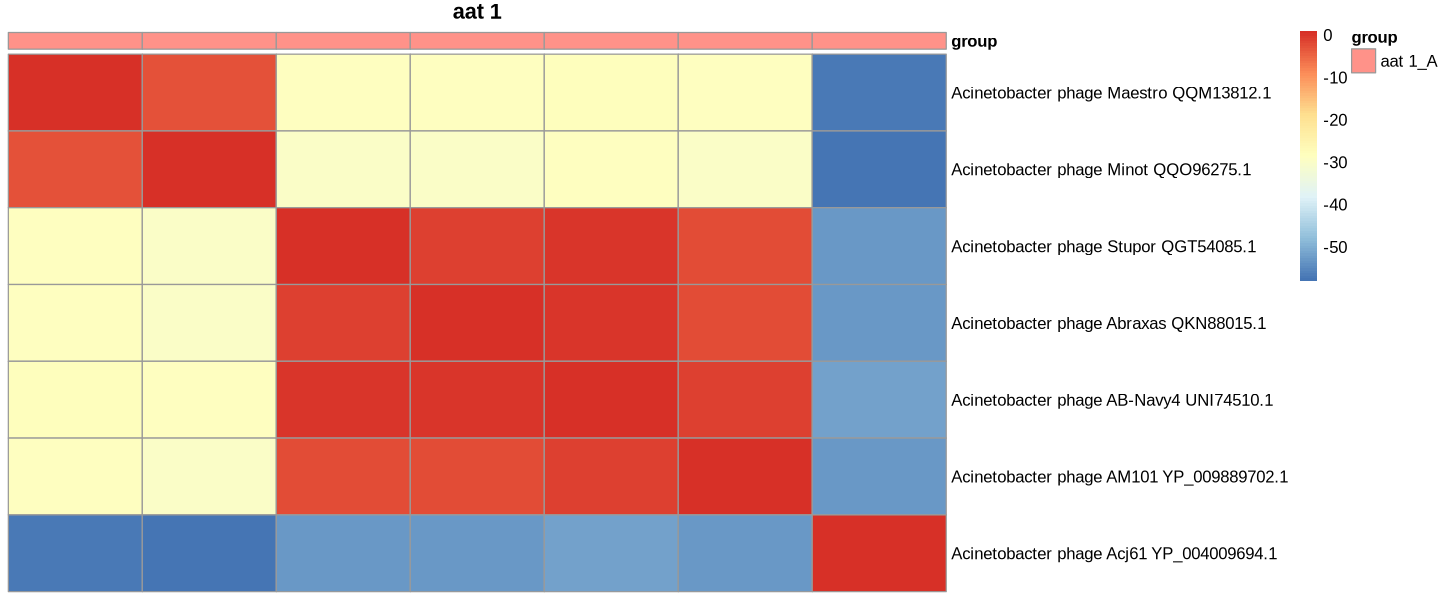

use default substitution matrix


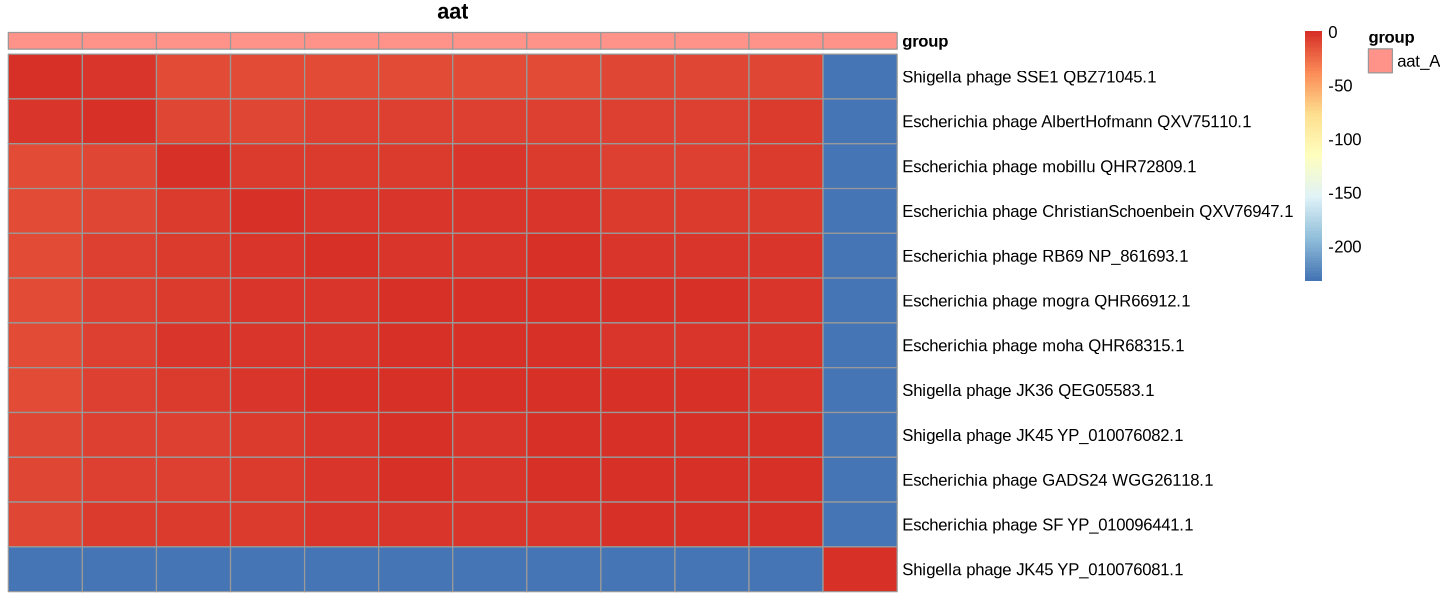

use default substitution matrix


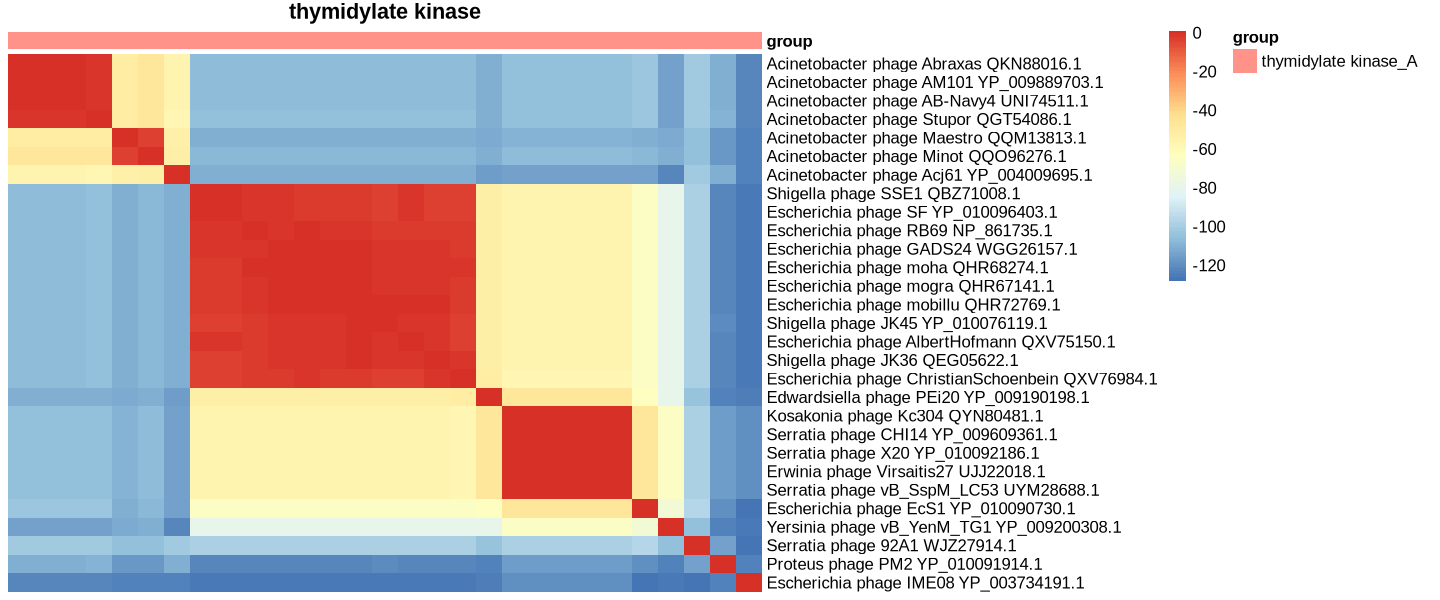

use default substitution matrix


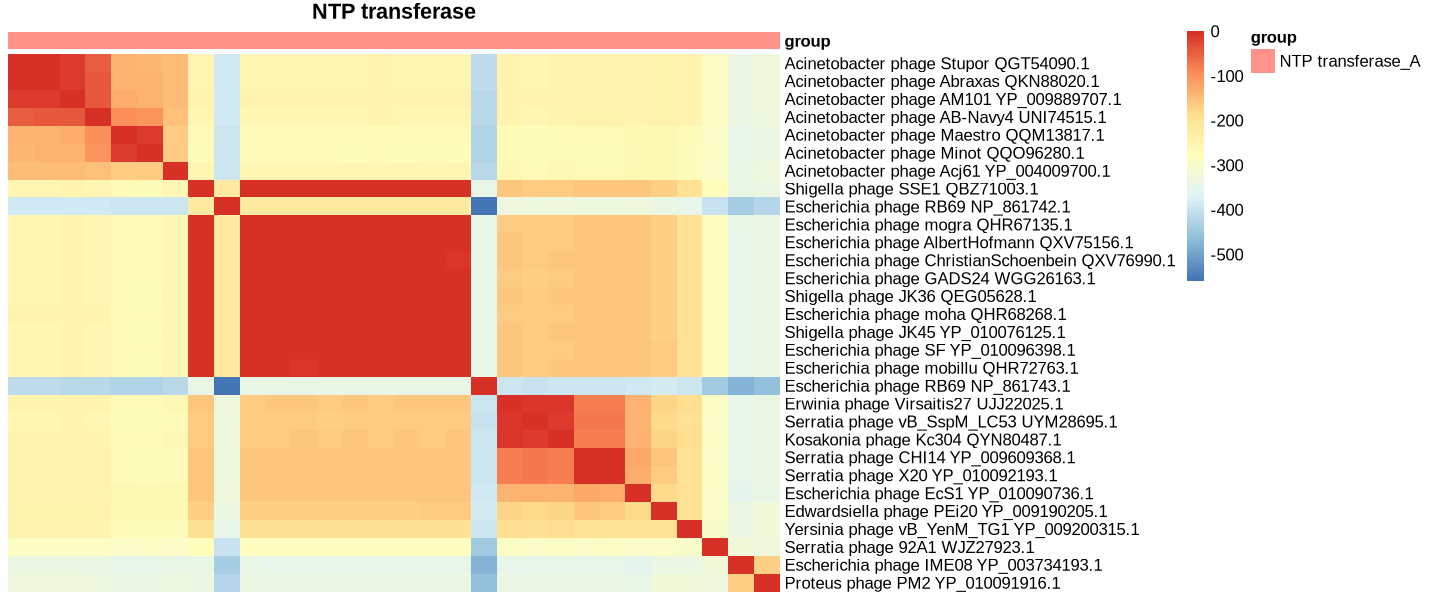

use default substitution matrix


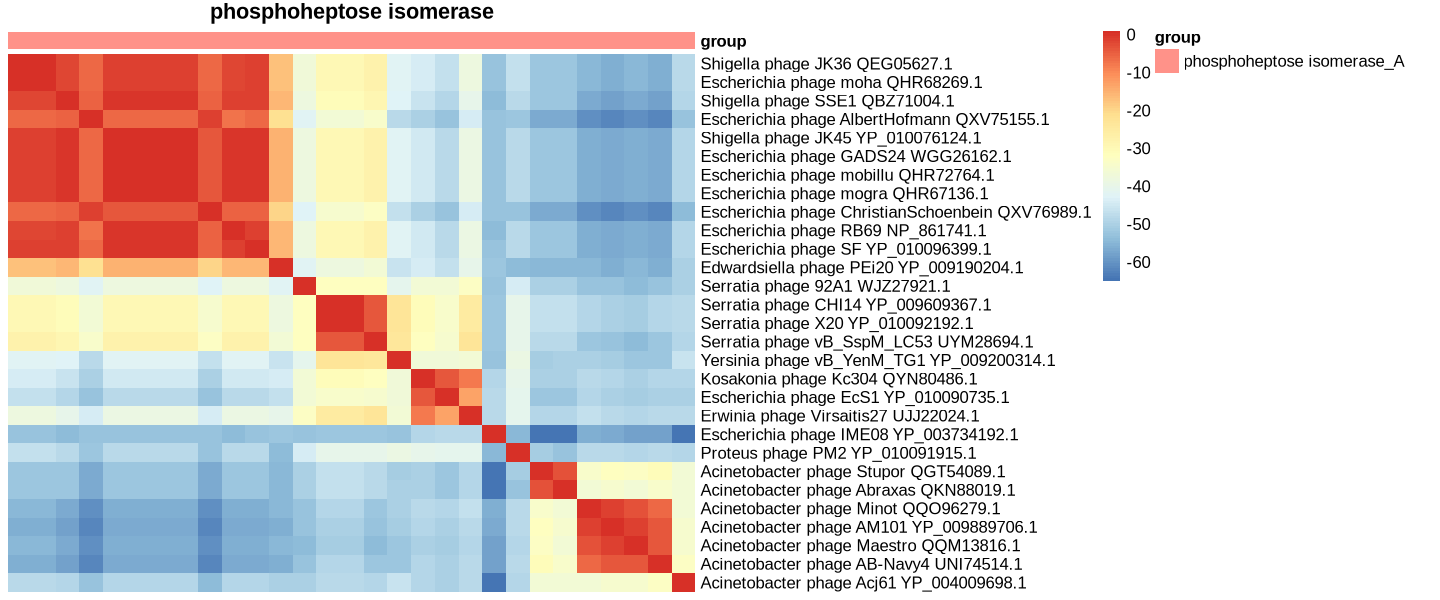

use default substitution matrix


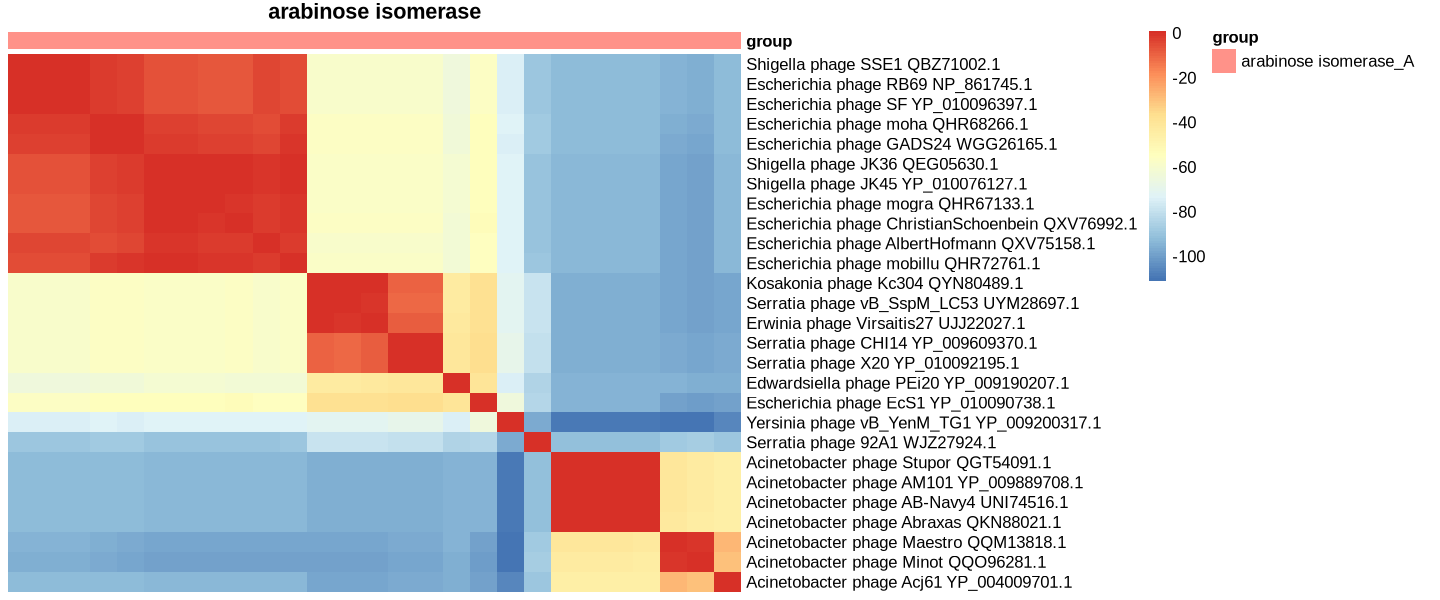

use default substitution matrix


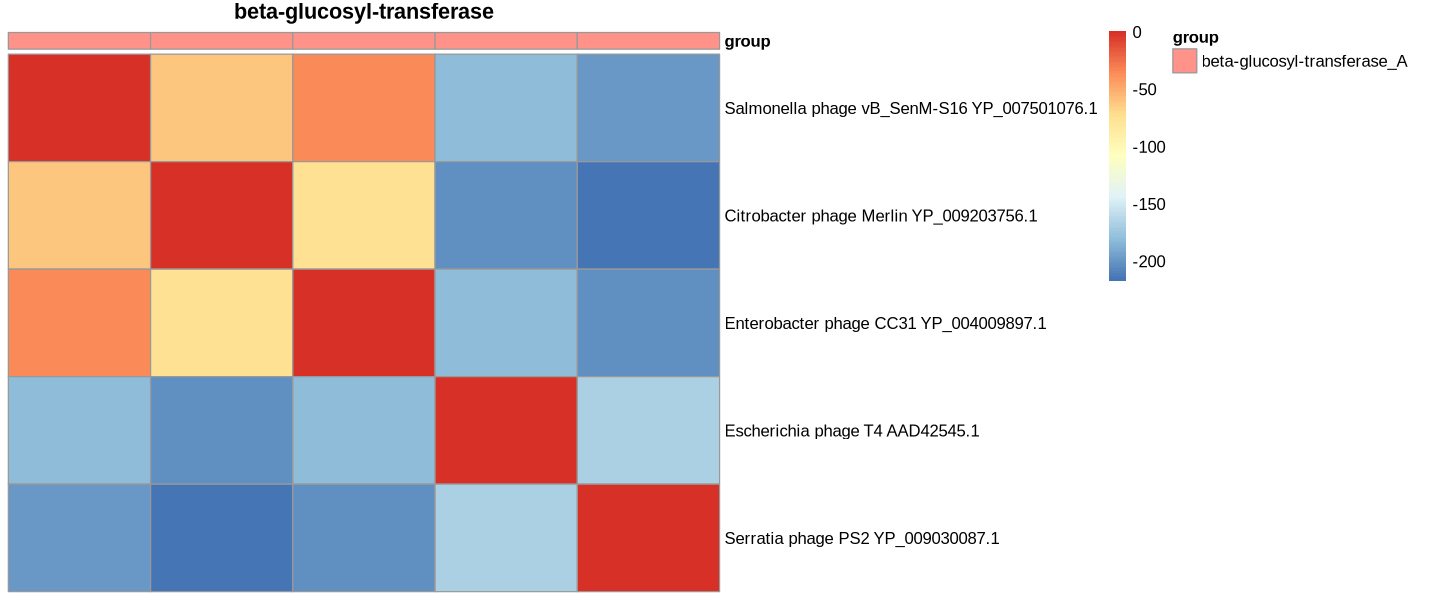

use default substitution matrix


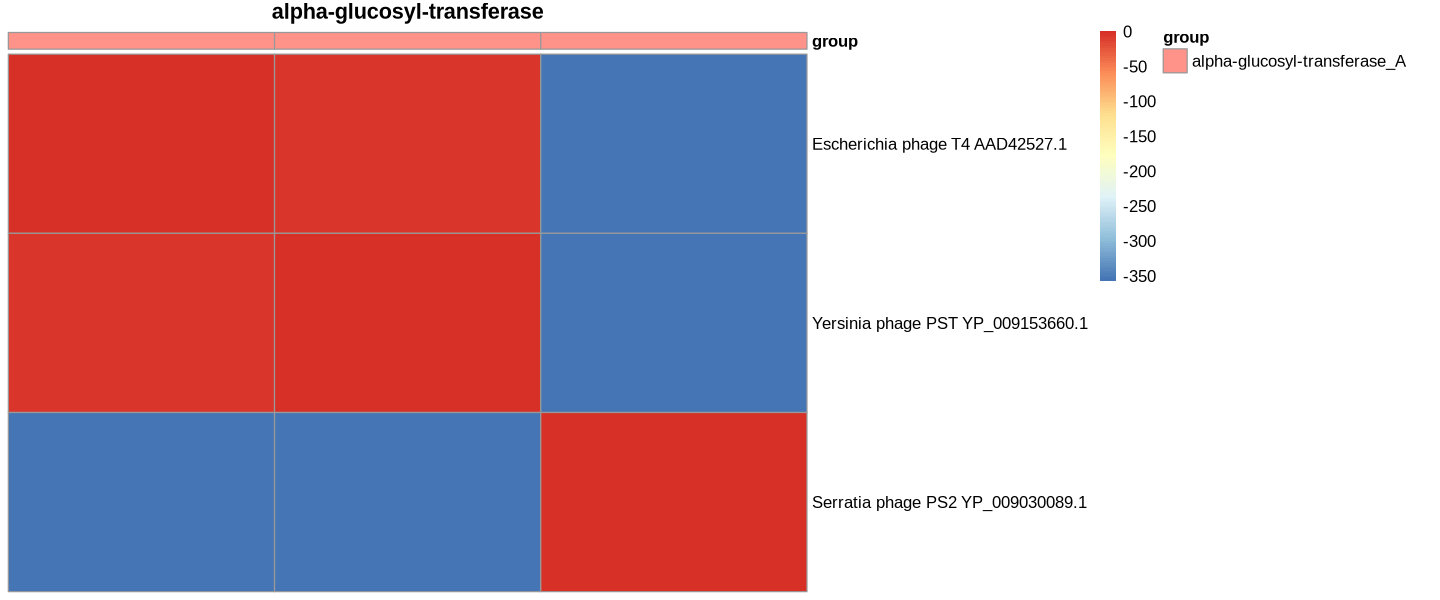

use default substitution matrix


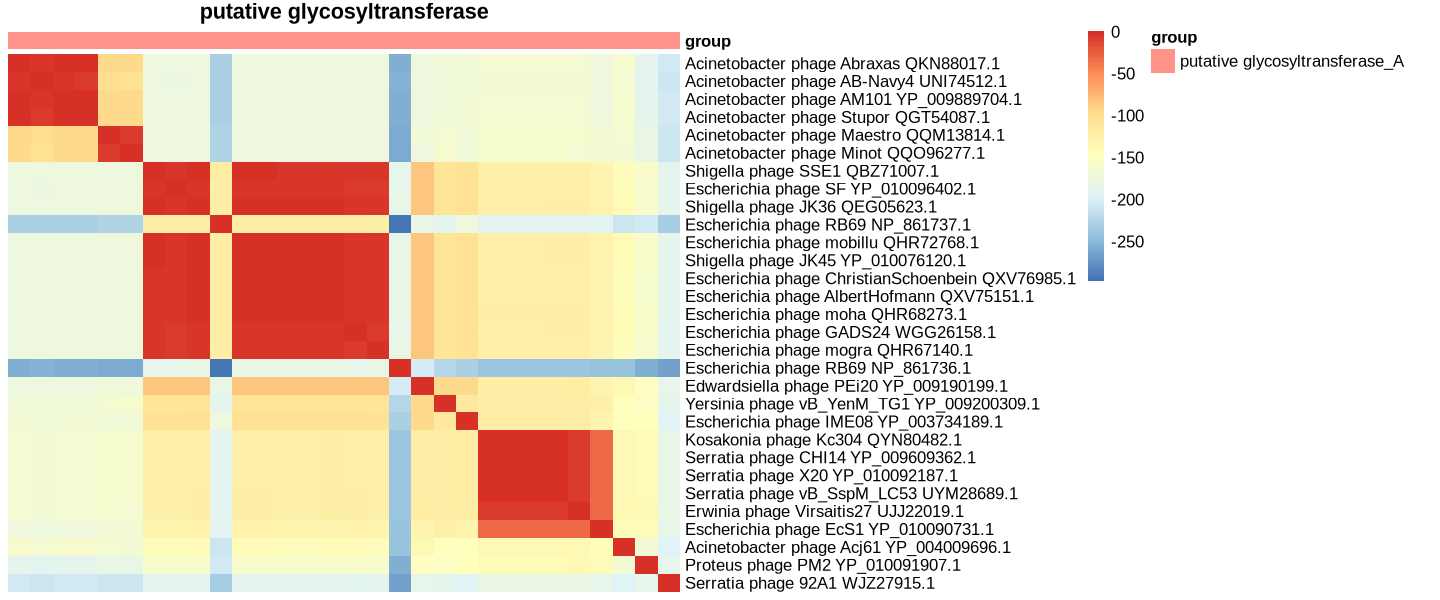

use default substitution matrix


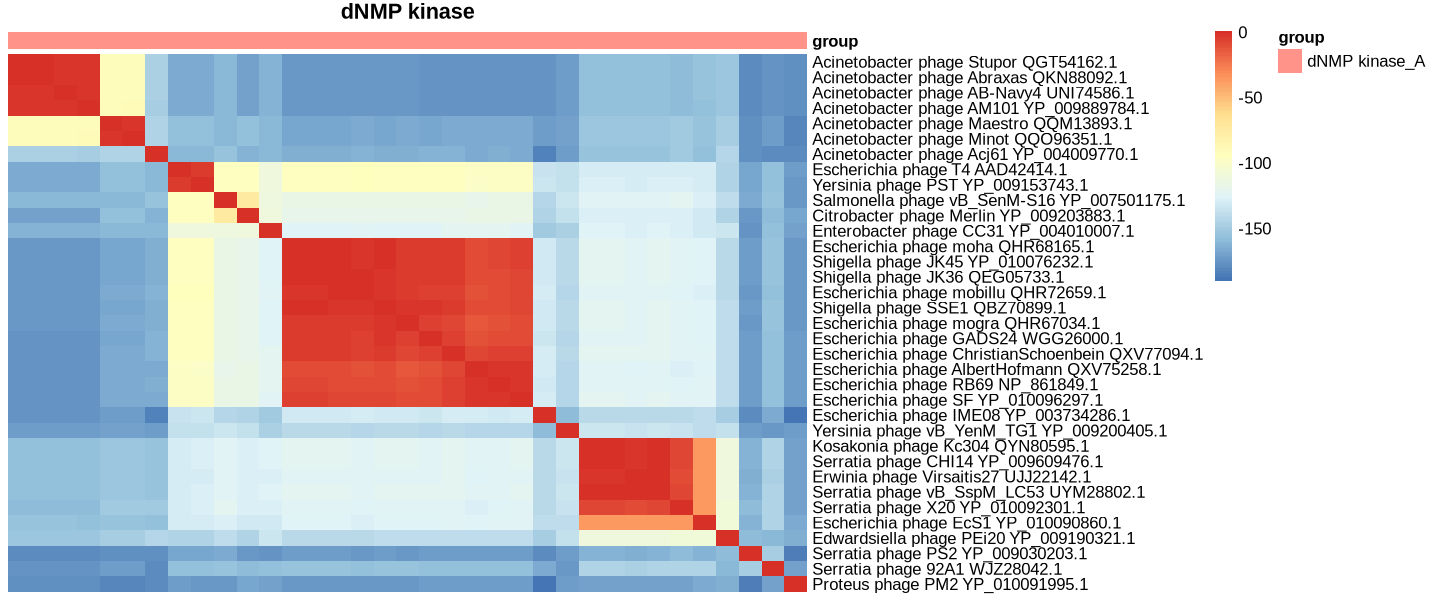

use default substitution matrix


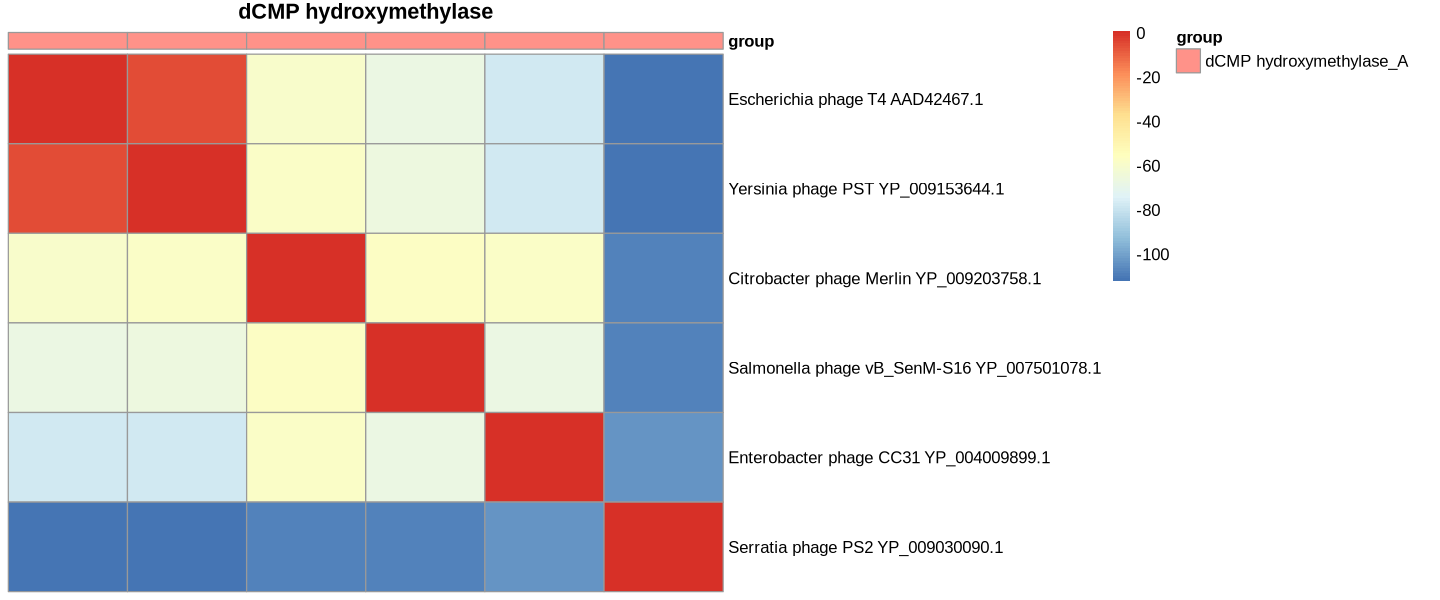

use default substitution matrix


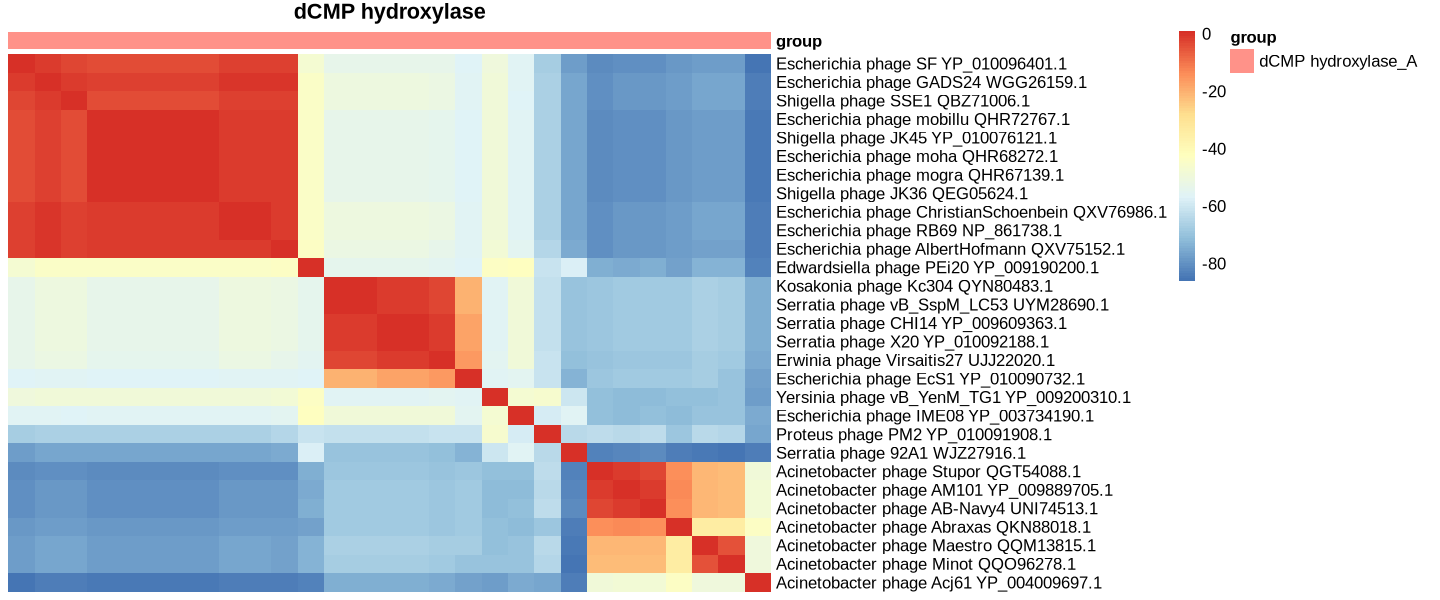

use default substitution matrix


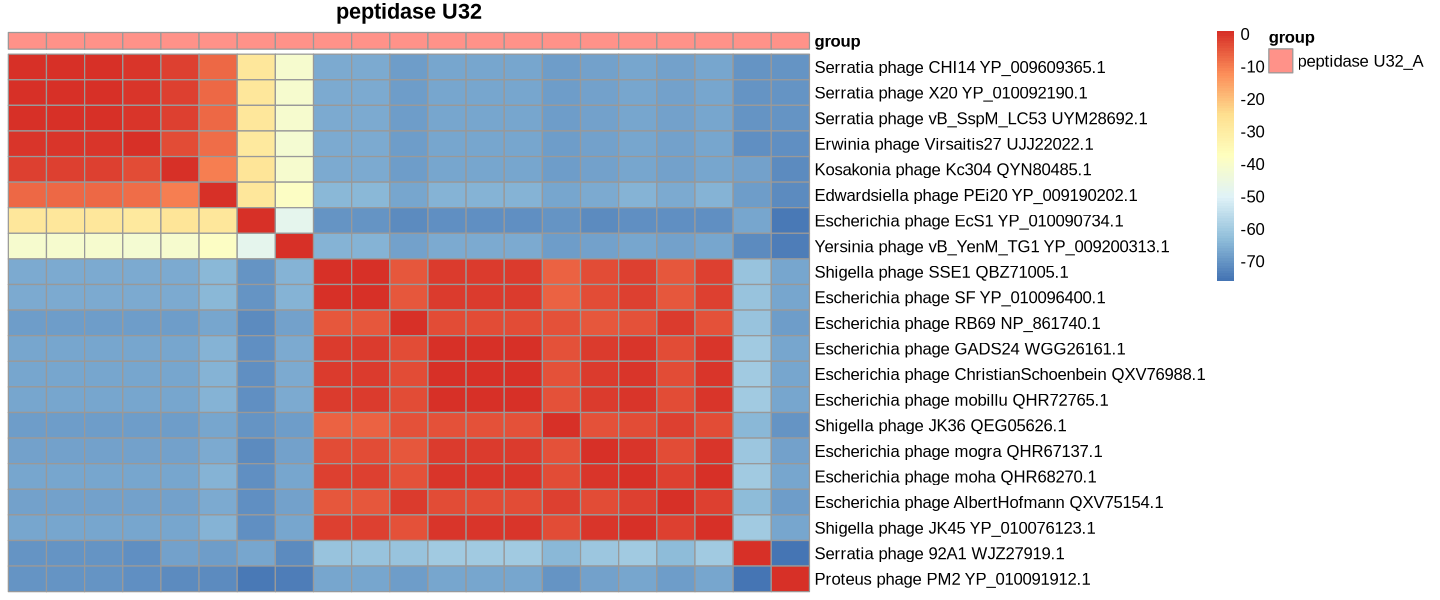

use default substitution matrix


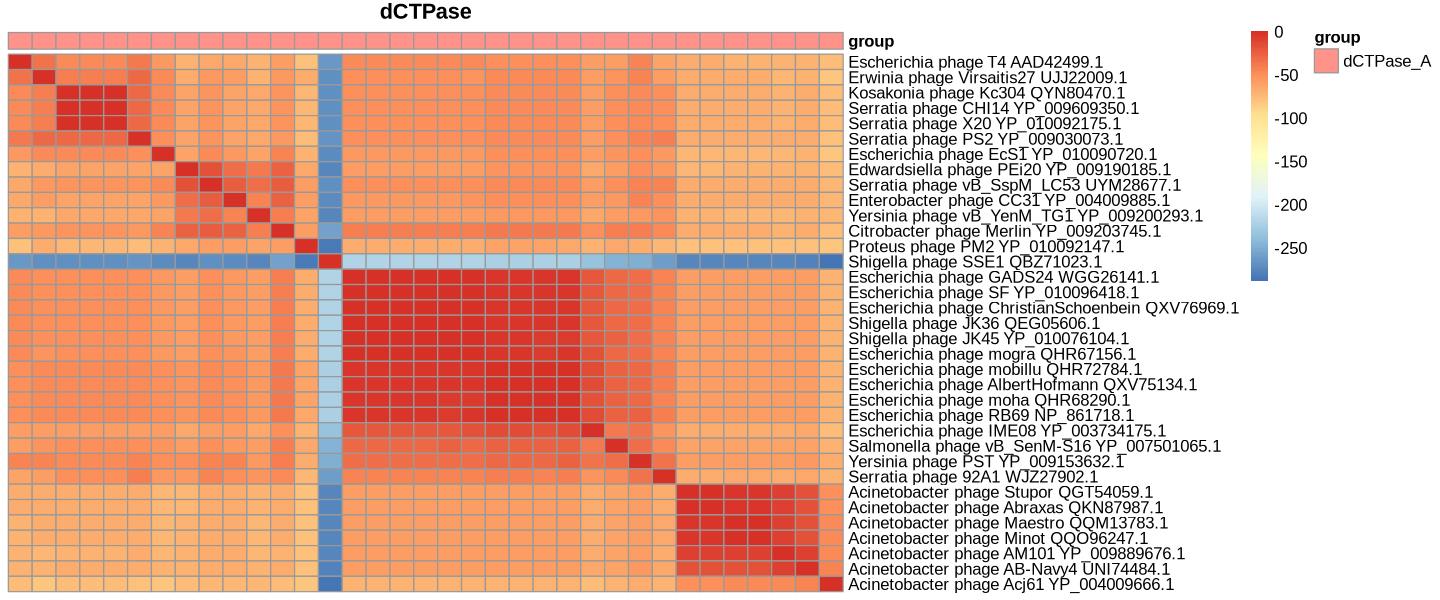

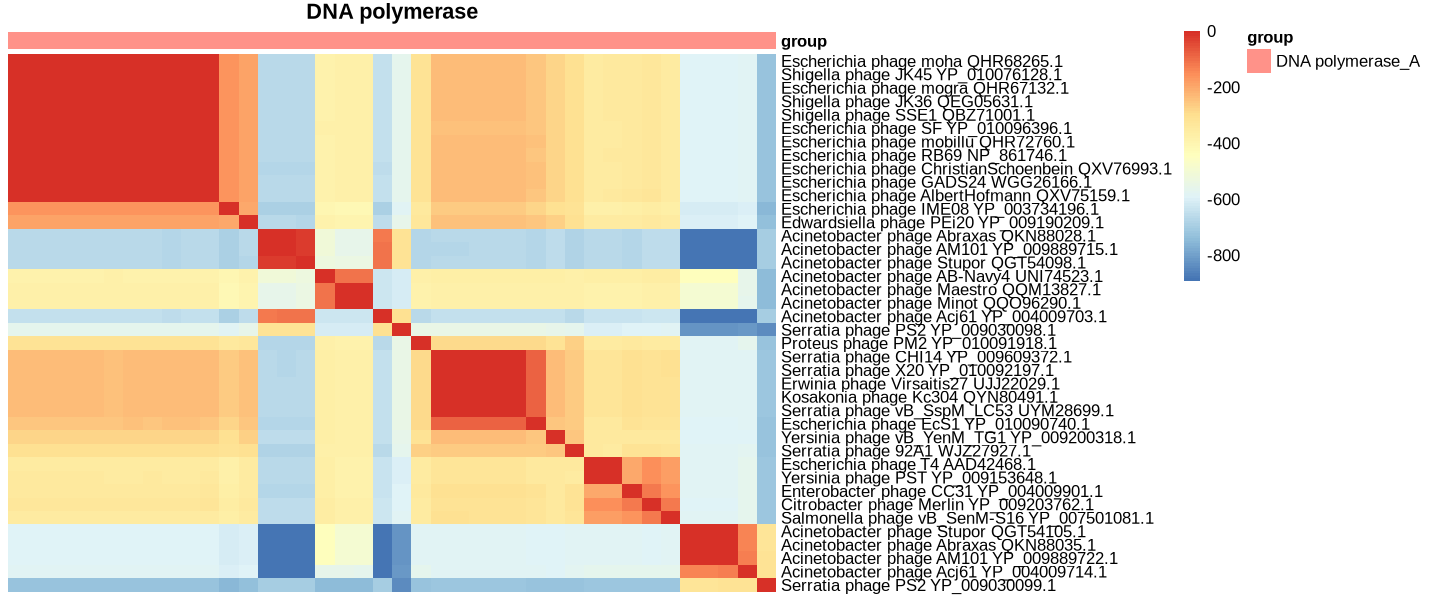

In [122]:
# Prepare protein profiles
options(repr.plot.width=12, repr.plot.height=5)

## Variables
dist_threshold <- 1000
data$key <- paste(data$Name, data$Gene.CDS.Protein.FASTA.Accession)

## Set up ann_level_2
data$ann_level_2 <- 'Other'

## Fetch genes
genes <- levels(data$annotation)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Iterate over genes
for (i in genes) {
    index <- which(data$annotation == i)

    if (length(index) < 2) {
        data$ann_level_2[index] <- i
        next
    }
    
    ## MSA
    seq <- AAStringSet(data$protein_seq[index])
    names(seq) <- data$key[index]
    result <- msa(seq)
    result
    
    ## Distance matrix
    dist <- as.matrix(dist.gene(as.AAbin(result)))

    ## Split alignment to homogeneous groups
    x <- dist < dist_threshold
    x <- apply(x, 1, which, simplify = FALSE)
    x <- lapply(x, paste0, collapse='-')
    x <- unlist(x)
    lookup <- LETTERS[1:length(unique(x))]
    names(lookup) <- unique(x)

    ## Annotate groups
    cann <- data.frame(
        row.names = rownames(dist),
        group = paste(i, lookup[x], sep = '_')
    )

    ## Transfer annotation
    index <- match(rownames(cann), data$key)
    data$ann_level_2[index] <- cann$group
    
    ## Plot
    pheatmap(1-dist, 
             cluster_cols = FALSE, cluster_rows = FALSE,
             annotation_col = cann, show_colnames=FALSE,
             show_rownames = TRUE, labels_row = result@unmasked@ranges@NAMES, fontsize=10, main=i
            )
}

In [123]:
index <- str_detect(unique(data$ann_level_2),'B')
if (!any(index)) {
    message('No group has been split (no group B present). Removing _A...')
    data$ann_level_2 <- str_remove(data$ann_level_2, '_A')
}

No group has been split (no group B present). Removing _A...



In [124]:
# Convert ann_level to factor
data$ann_level_2 <- factor(data$ann_level_2, unique(data$ann_level_2[order(data$annotation, decreasing = FALSE)]))
levels(data$ann_level_2)

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

[1] TRUE

character(0)

Warning message:
“Removed 59 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message:
“Removed 5 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


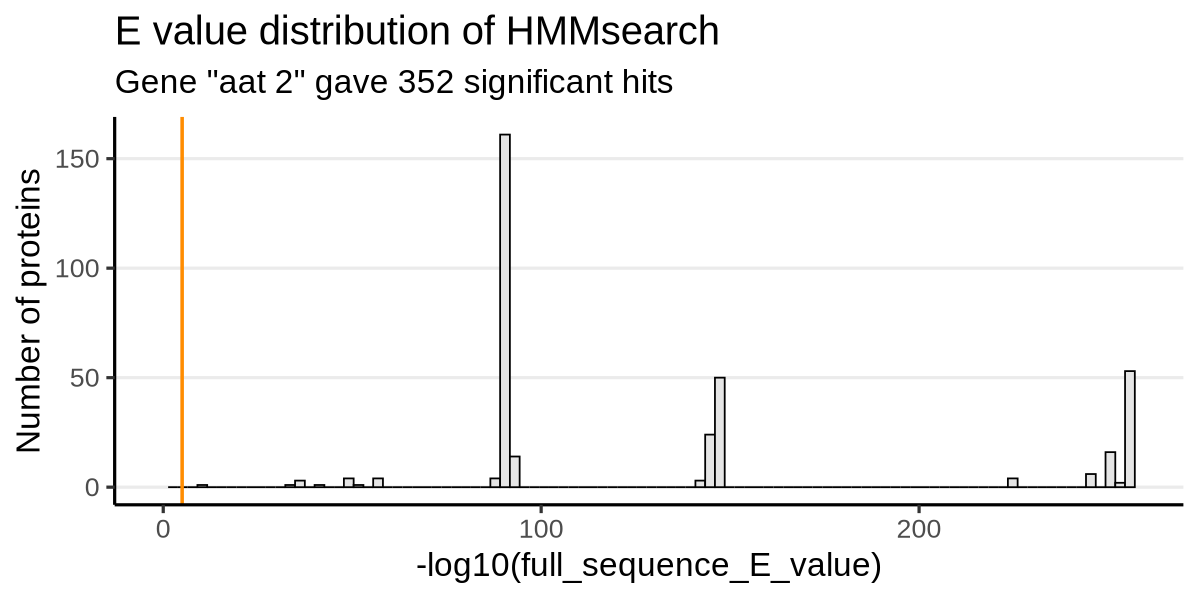

Warning message:
“Removed 15 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


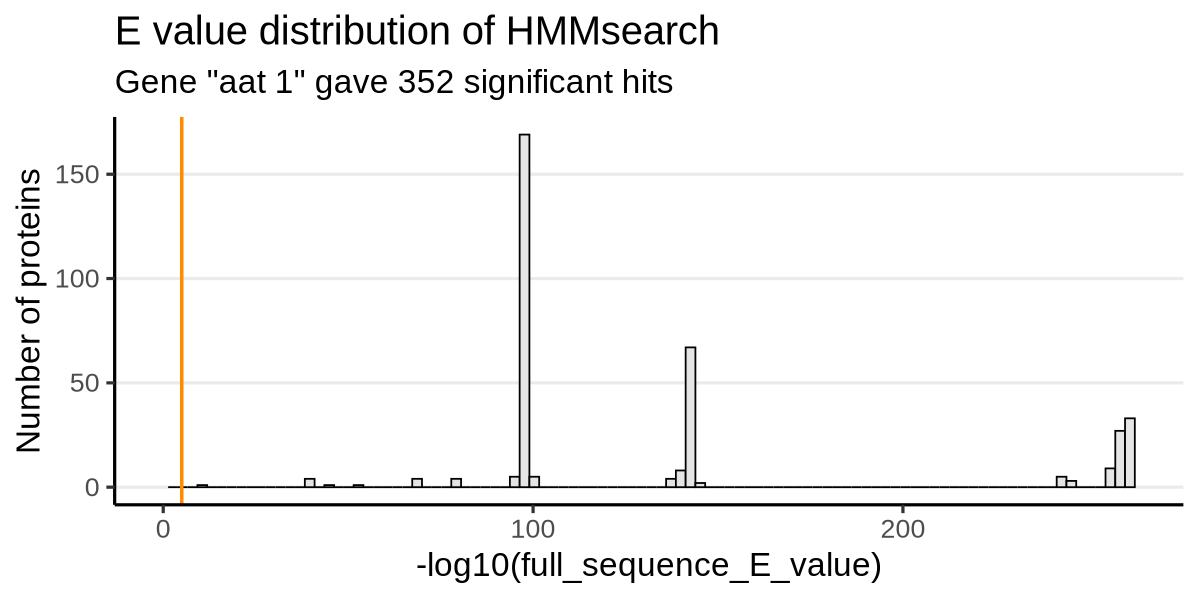

Warning message:
“Removed 287 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


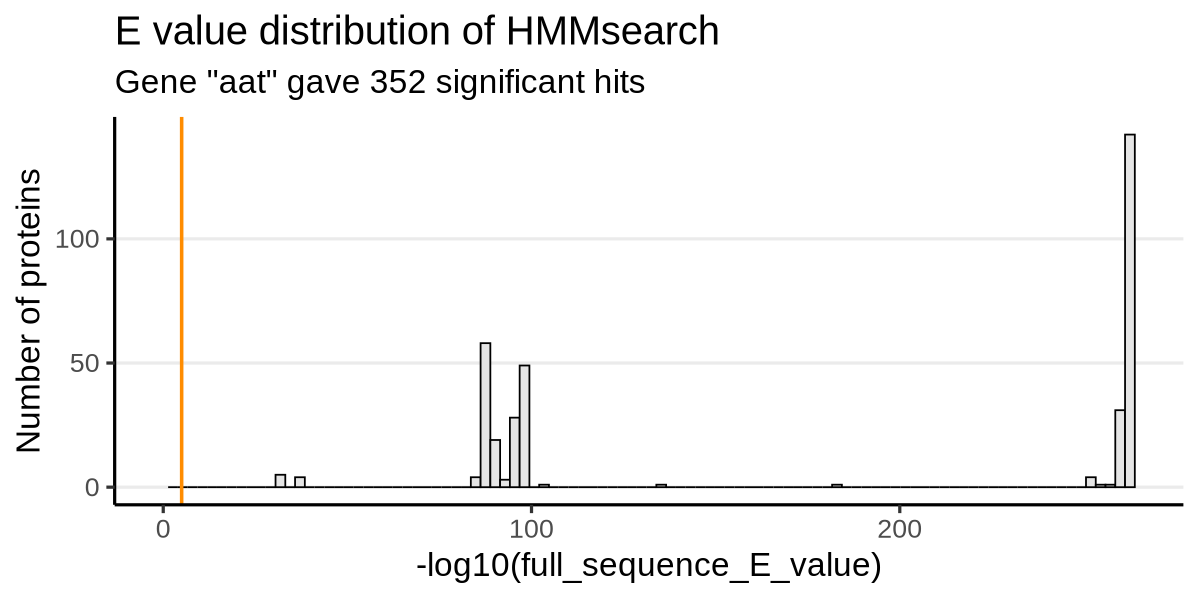

Warning message:
“Removed 191 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


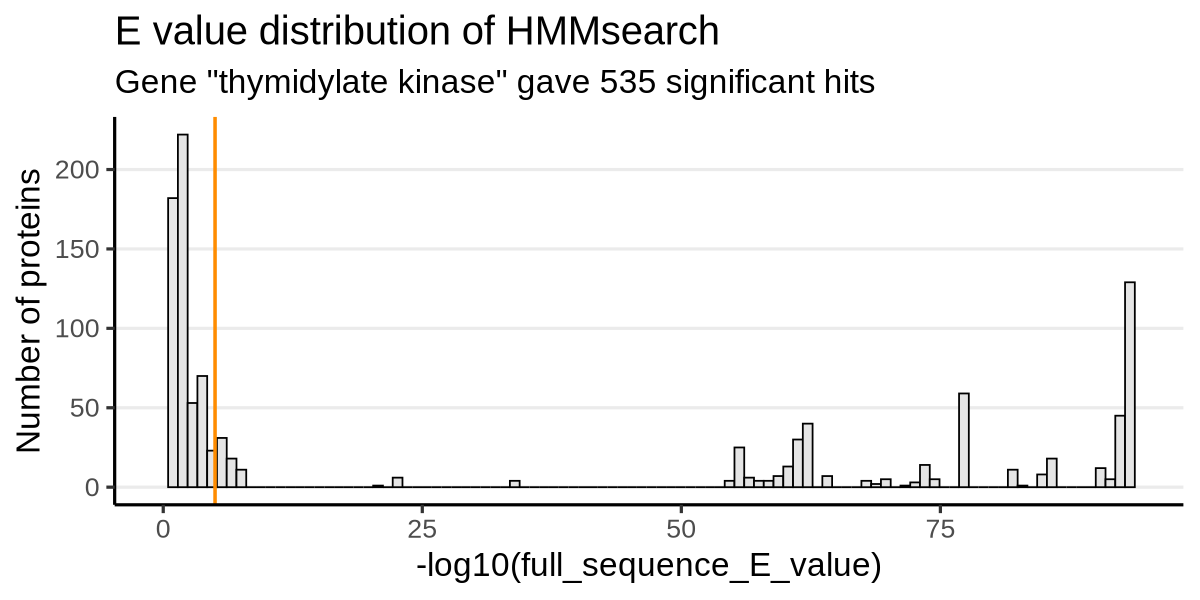

Warning message:
“Removed 160 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


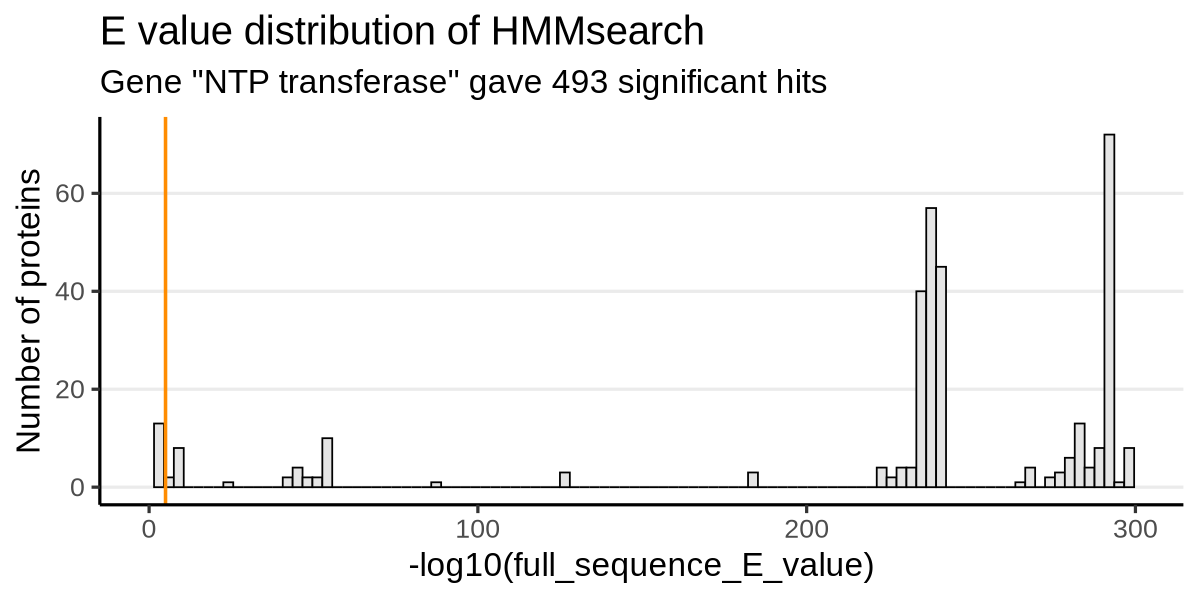

Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


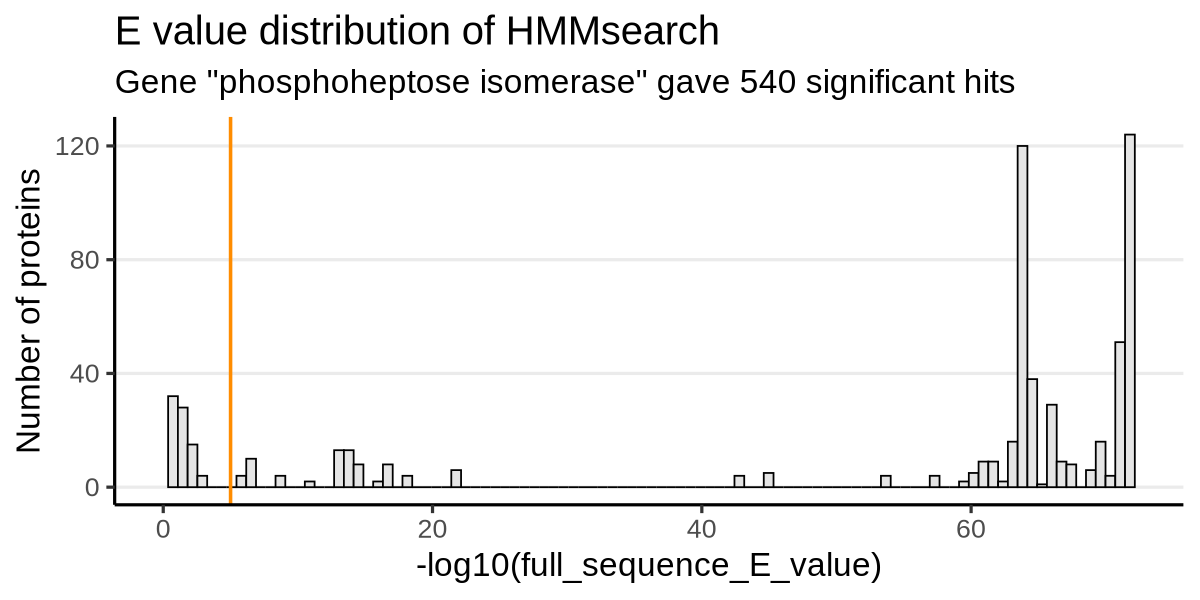

Warning message:
“Removed 13 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


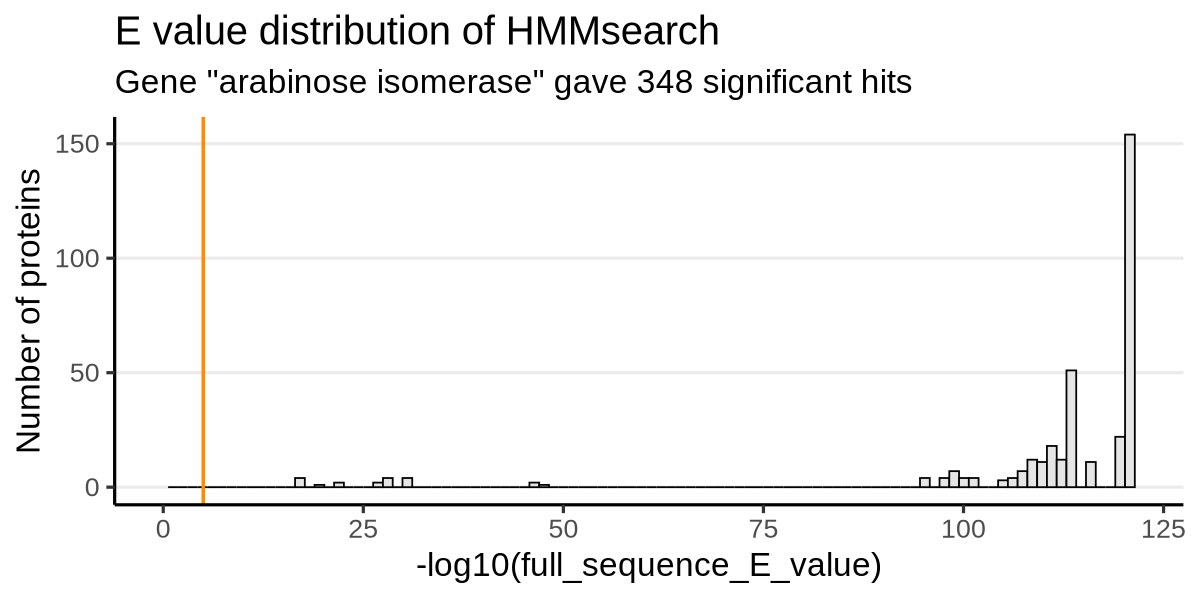

Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


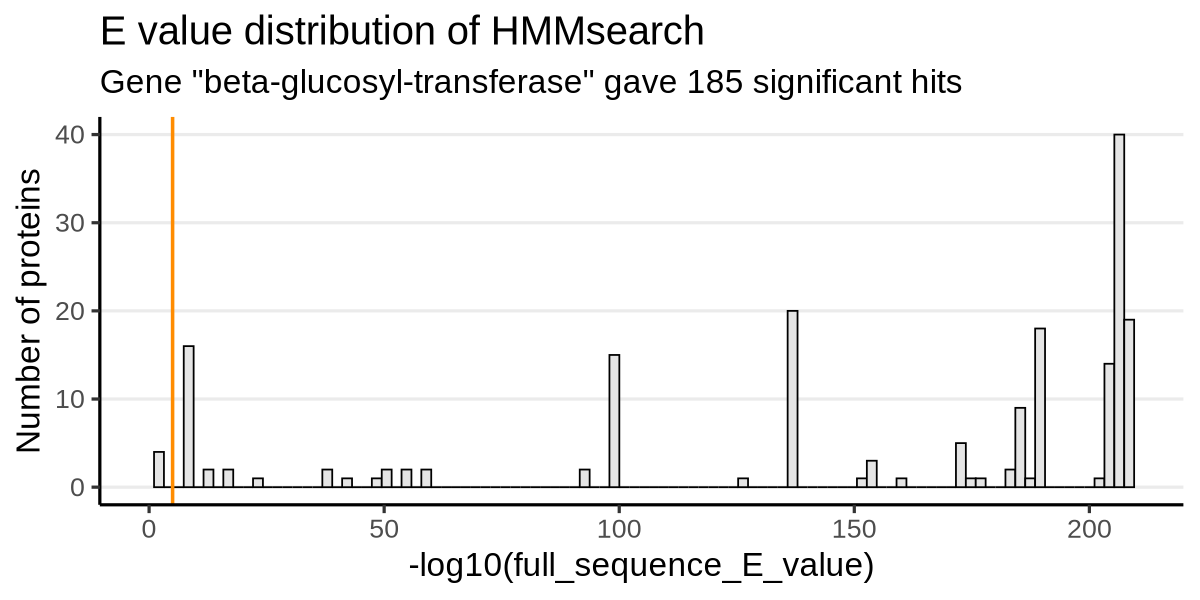

Warning message:
“Removed 21 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


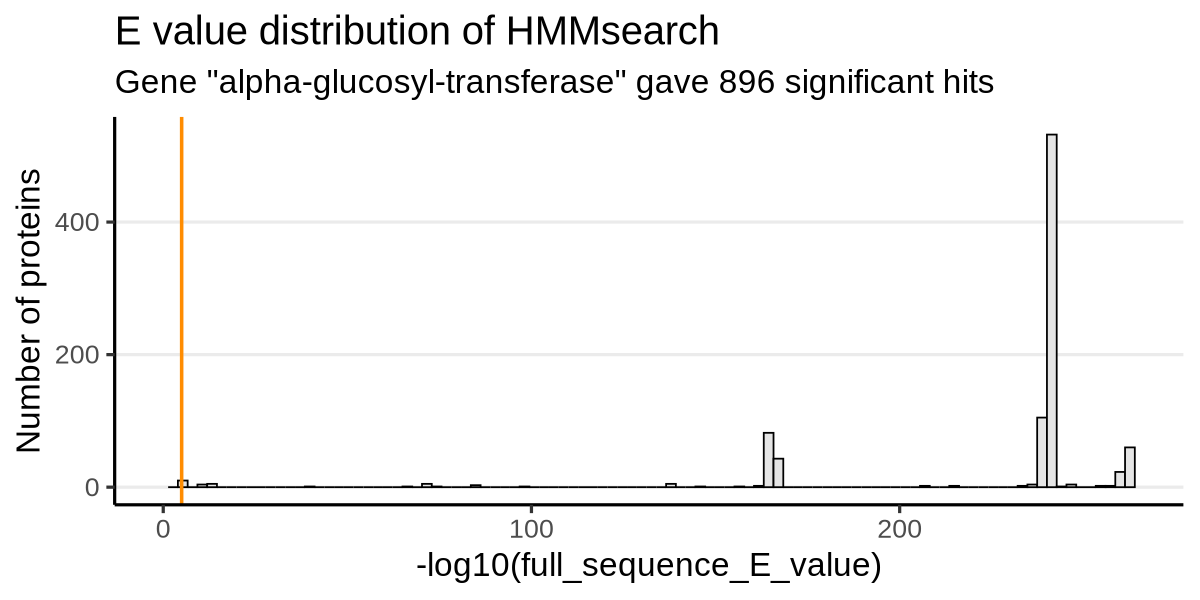

Warning message:
“Removed 414 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


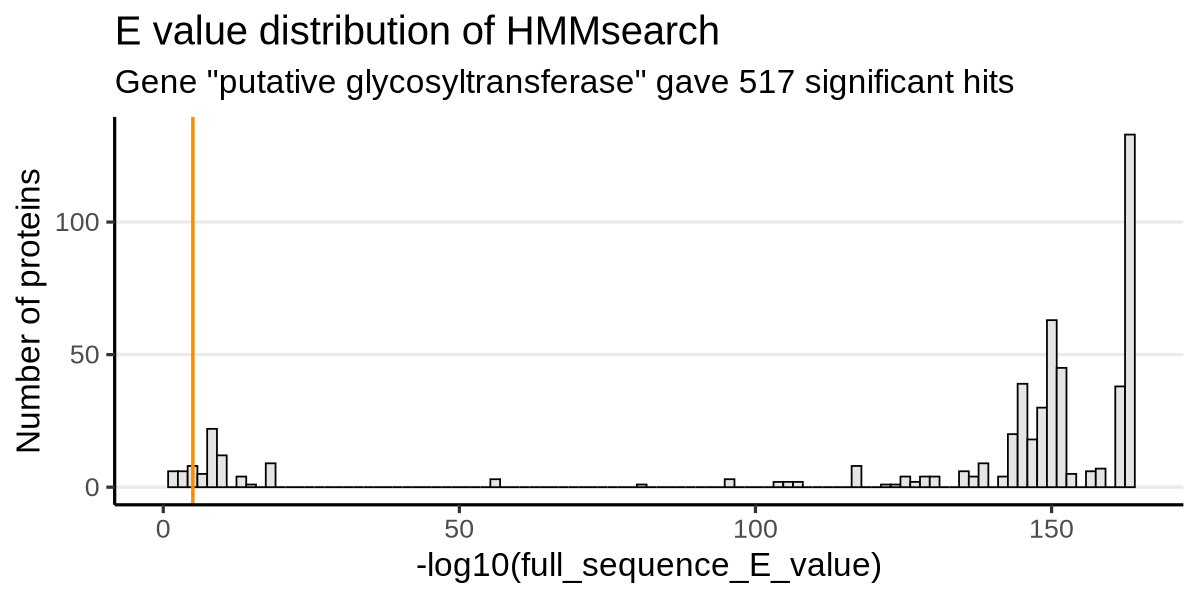

Warning message:
“Removed 631 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


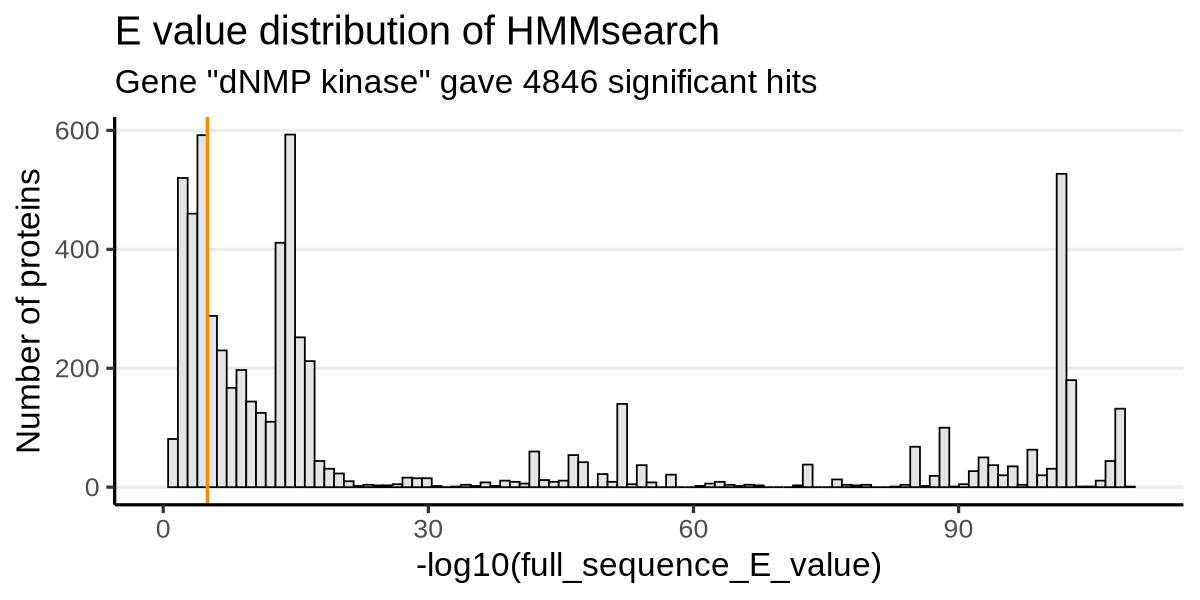

Warning message:
“Removed 554 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


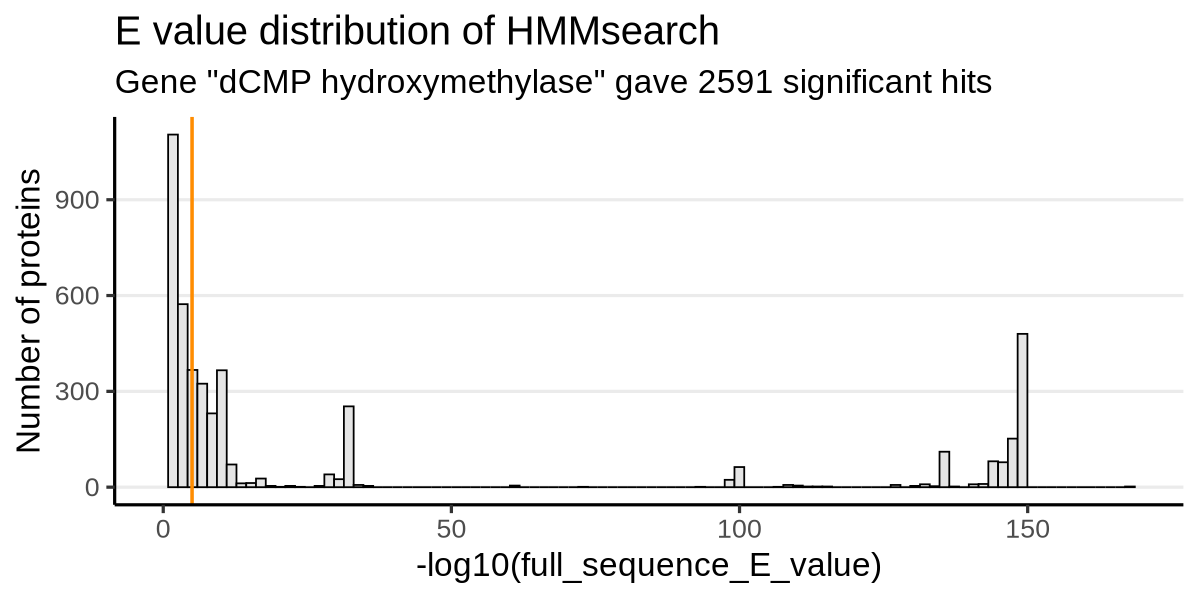

Warning message:
“Removed 10 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


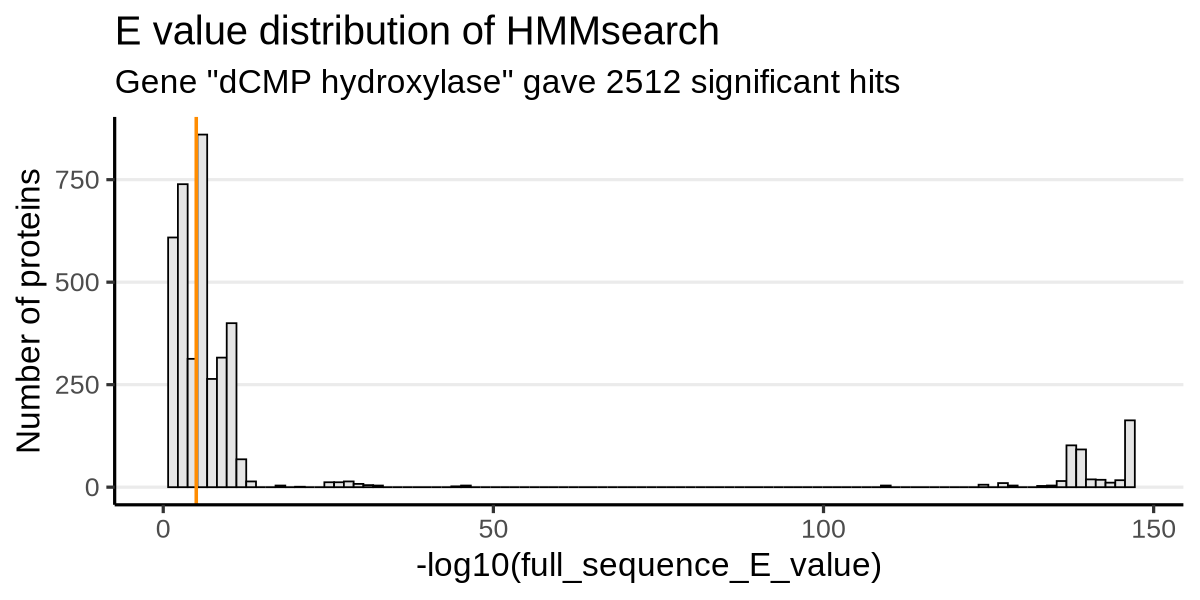

Warning message:
“Removed 136 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


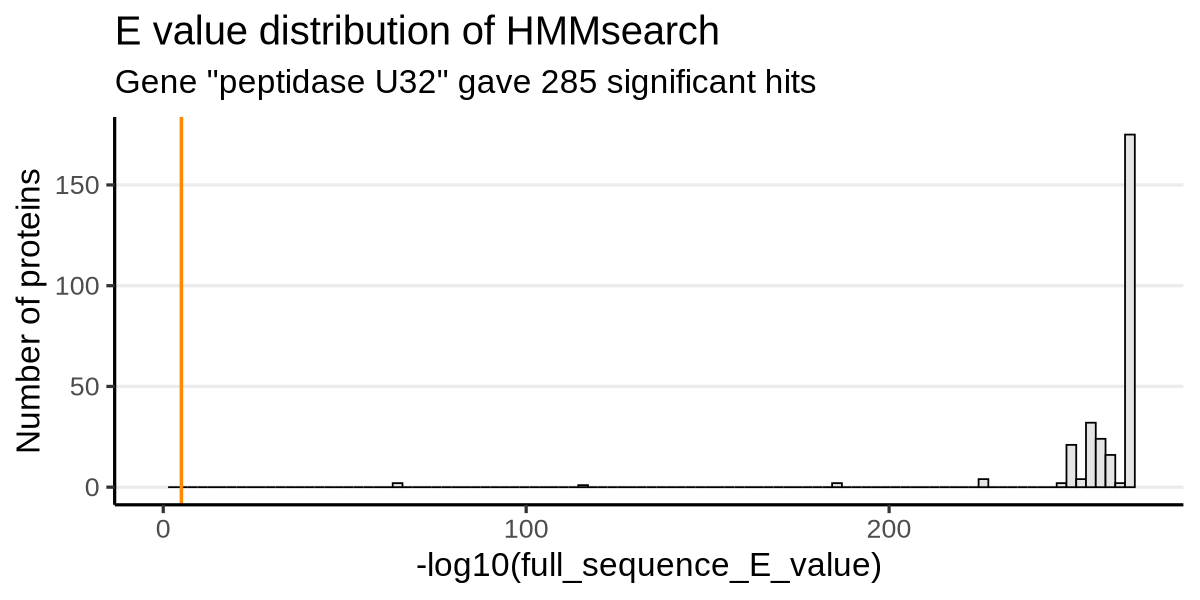

Warning message:
“Removed 1774 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”


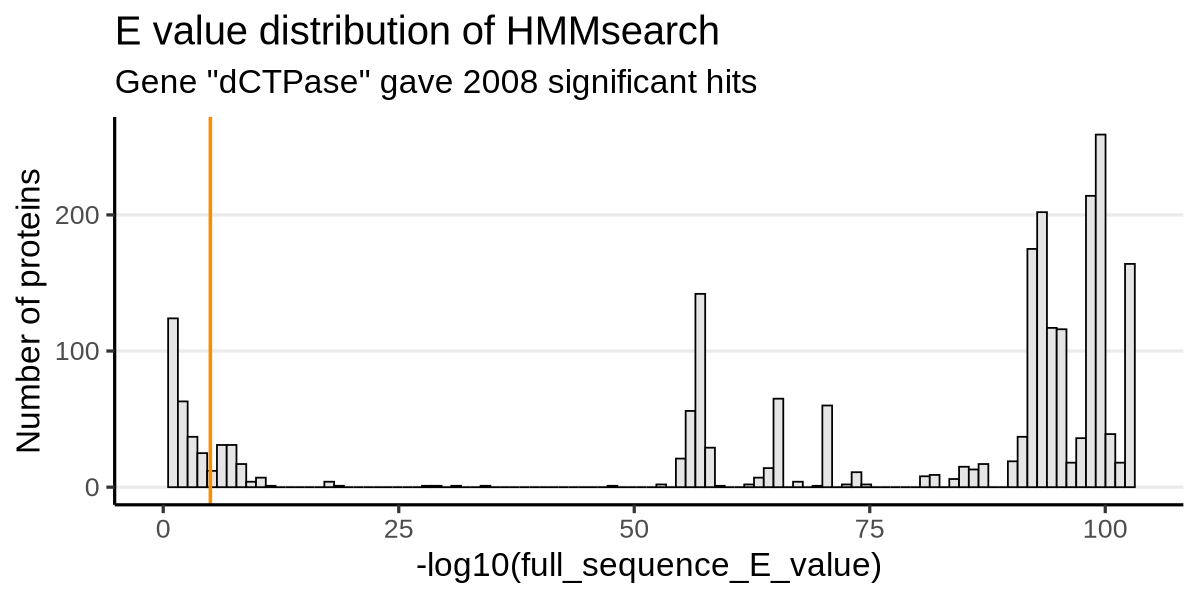

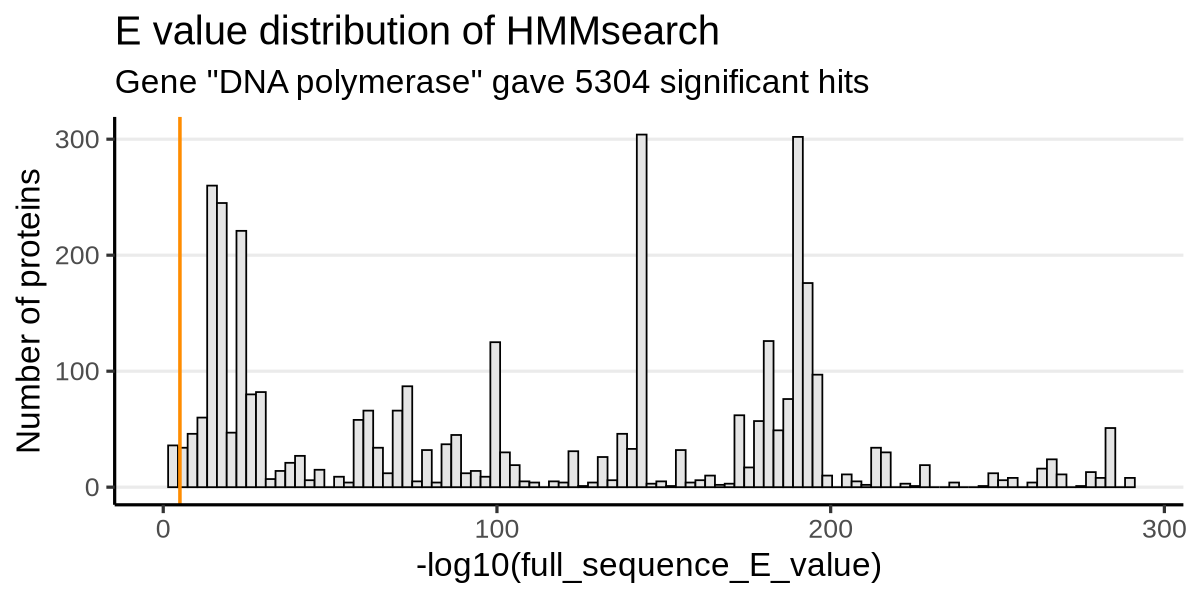

In [125]:
# Predict annotations on INPHARED
options(repr.plot.width=10, repr.plot.height=5)

genes <- levels(data$ann_level_2)
genes <- genes[genes != 'Other']
genes <- rev(genes)

## Check spelling
all(genes %in% levels(data$ann_level_2))

## Combine protein fasta
protein_db <- paste0(out_path,'protein.faa')
sys_call <- paste('cat ',fs$training$protein,fs$test$protein,fs$test2$protein,'>',protein_db)
system(sys_call, intern=TRUE)

## Iterate annotation over genes
pred <- list()
for (gene in genes) {
    pred[[gene]] <- annotate_gene_by_hmm_profile(
        data, annotation = 'ann_level_2', gene = gene, 
        search_db = protein_db, n_cores = 8, 
        e_value_treshold = 1e-5, dir = out_prediction
    )
    pred[[gene]]$annotation <- gene
}

Warning message:
“Removed 1877 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 16 rows containing missing values or values outside the scale range
(`geom_bar()`).”


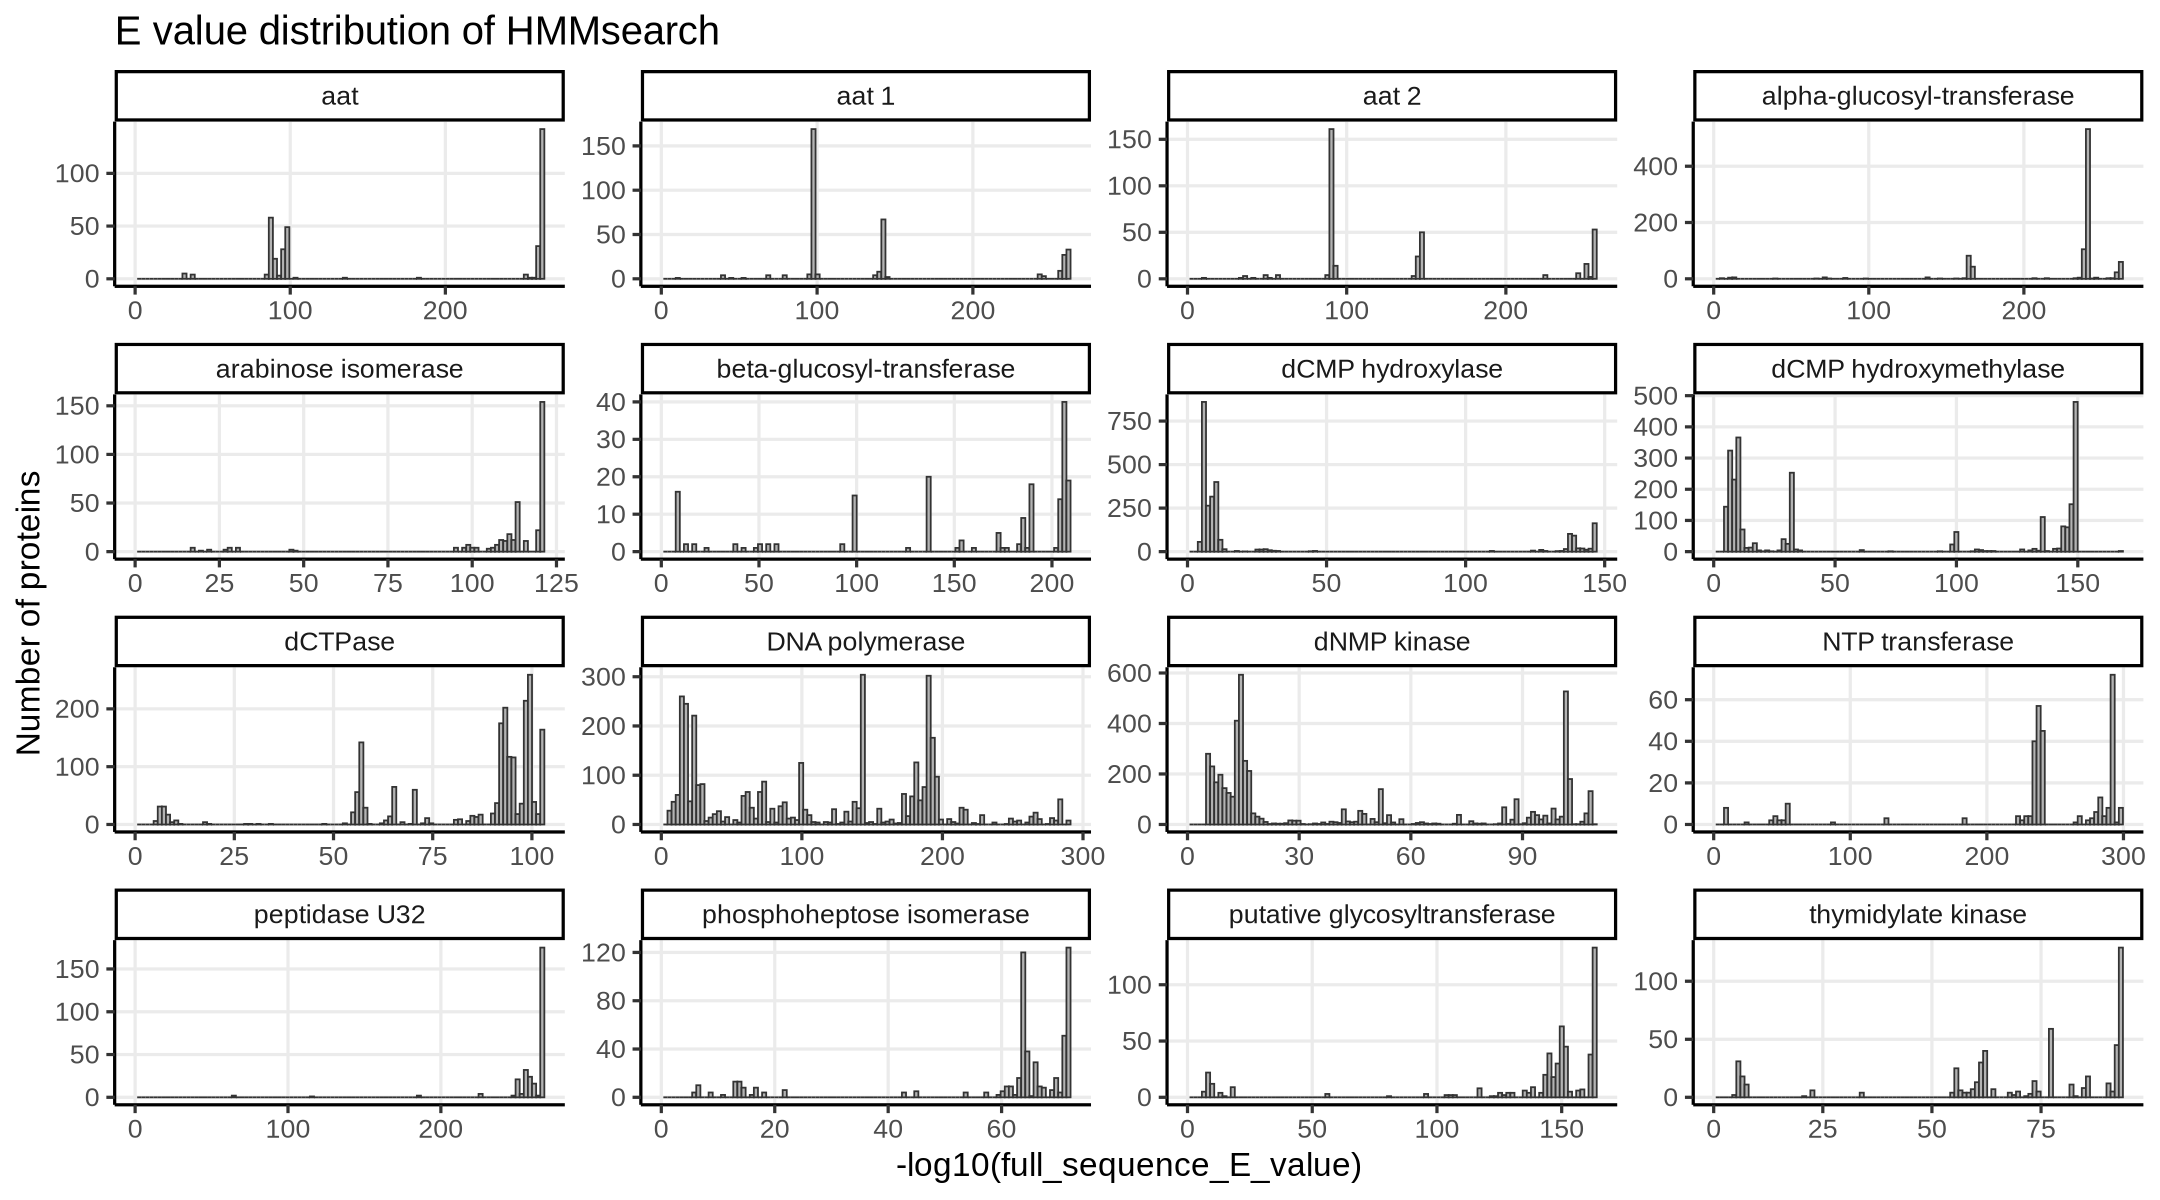

In [127]:
# Histograms of E-values
options(repr.plot.width=18, repr.plot.height=10)

## Format result
result <- do.call('rbind', pred)

## Plot
ggplot(result, aes(-log10(full_sequence_E_value))) +
  geom_histogram(bins = 100, fill='grey70', col='grey20') +
  facet_wrap(~annotation, scales = 'free') +
      scale_x_continuous(limits = c(0, NA)) +
      theme_classic(20) +
      theme(
          panel.grid.major = element_line()
      ) +
      labs(y = 'Number of proteins', title = 'E value distribution of HMMsearch')

In [128]:
## Pool
result <- do.call('rbind', pred) %>% select(Sequence, annotation, full_sequence_E_value)
result <- result[!duplicated(result), ]
result <- pivot_wider(result, names_from = Sequence, values_from = full_sequence_E_value, values_fill = 1)
result <- result %>% as.data.frame()
row.names(result) <- result$annotation
result <- result[,-1]
result[result == 0] <- 1e-300

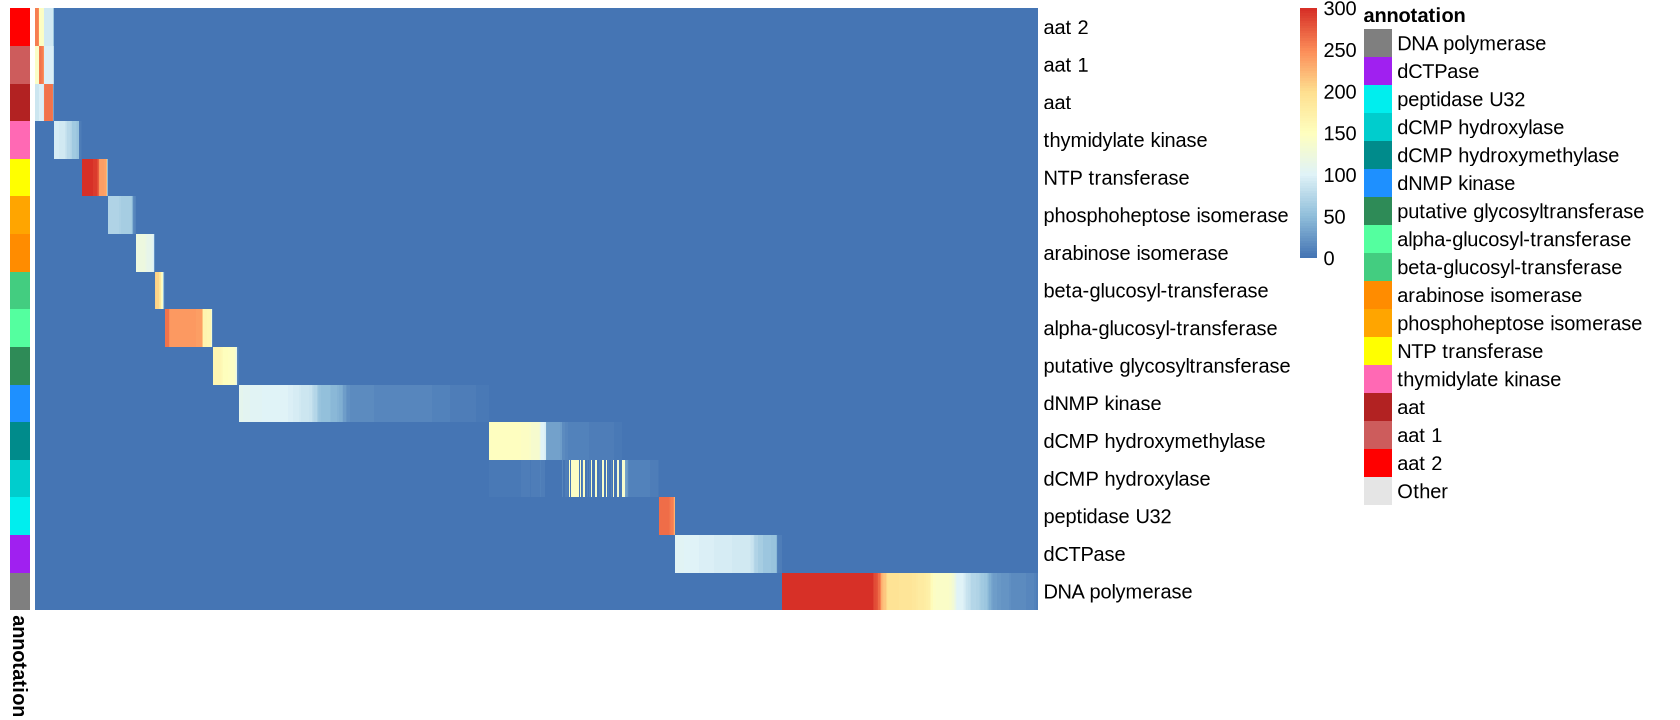

In [129]:
options(repr.plot.width=14, repr.plot.height=6)

## Row annotation
rann <- data.frame(
    row.names = rownames(result),
    annotation = str_split(rownames(result), '_', simplify=TRUE)[,1]
)

## Plot
p1 <- pheatmap(
    -log10(result), 
    cluster_cols = FALSE, cluster_rows = FALSE,
    annotation_row = rann, annotation_colors = cols,
    show_colnames=FALSE,
    fontsize=12
)

## Save
fn <- paste0(out_path,'heatmap_test-hmmsearch','.png')
ggsave(fn, p1, width = 14, height = 6, bg='white')

In [130]:
## Vote
lookup <- character(length = ncol(result))
for (n in 1:ncol(result)) {
    v <- result[,n]
    names(v) <- str_split(rownames(result), '_', simplify = TRUE)[,1]
    n_min <- min(v)
    lookup[[n]] <- unique(names(which(v == min(v))))
}
names(lookup) <- colnames(result)
#index <- match(colnames(result), features$Gene.CDS.Protein.FASTA.Sequence.ID)
ds$features$annotation <- lookup[ds$features$Gene.CDS.Protein.FASTA.Sequence.ID]

`summarise()` has grouped output by 'Accession'. You can override using the
`.groups` argument.


[1] FALSE

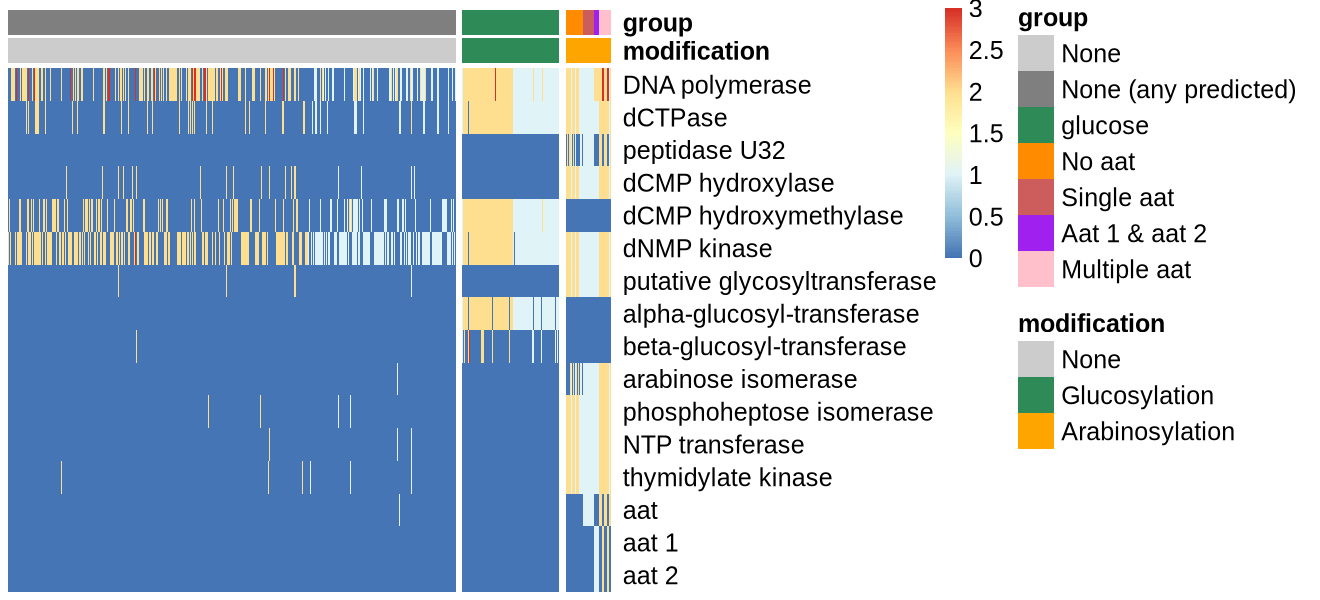

In [154]:
# Feature quantification
options(repr.plot.width=11, repr.plot.height=5)

heatmap_genes <- c('DNA pol','DNA clamp','NTP transfer','Thy syn','dCTPase','Hydroxylase','Pep U32','dNMP kinase','Glu transfer',
                   'Ara iso','pHep iso','Thy kin','Aat')
heatmap_genes <- levels(data$annotation)
heatmap_genes <- heatmap_genes[!heatmap_genes %in% c('Other')]

## Summarize gene counts
df <- ds$features %>% mutate(N=1) %>% group_by(Accession, annotation) %>% summarize(total = sum(N))

## Filter
index <- df$annotation %in% heatmap_genes
df <- df[index,]

## Reshape
mat <- df %>% pivot_wider(names_from = Accession, values_from = total, values_fill = 0) %>% as.data.frame()
rownames(mat) <- mat$annotation
mat <- mat[heatmap_genes, -1] %>% as.matrix()

## Set max
mat[mat >= 3] <- 3

## Binarize
bat <- mat > 0

### Row
rann <- data.frame(
    row.names = rownames(mat)#, group = c('Generic','Generic','Generic','Glucosylation','Arabinosylation','Arabinosylation','Generic','Generic','Arabinosylation','Arabinosylation','Arabinosylation')
)
#rann$group <- factor(rann$group, names(cols$group))

### Col
index <- match(colnames(mat), data$Accession)
cann <- data.frame(
    row.names = colnames(mat),
    modification = data$modification[index]
)

##  Cluster

### Level 1
gluc_genes <- c('dCMP hydroxymethylase','alpha-glucosyl-transferase','beta-glucosyl-transferase')
ara_genes <- c('dCMP hydroxylase','putative glycosyltransferase','arabinose isomerase',
               'phosphoheptose isomerase','thymidylate kinase')
ind_gluc <- which(colSums(bat[gluc_genes,]) > 1)
ind_ara <- which(colSums(bat[ara_genes,]) > 3)
any(intersect(ind_gluc, ind_ara))

cann$modification <- 'None'
cann$modification[ind_gluc] <- 'Glucosylation'
cann$modification[ind_ara] <- 'Arabinosylation'
cann$modification <- factor(cann$modification, names(cols$modification))

### Level 2
cann$group <- 'None (any predicted)'
cann$group[cann$modification == 'Glucosylation'] <- 'glucose'
cann$group[cann$modification == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) < 1] <- 'No aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat',] == 1] <- 'Single aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat',] > 1] <- 'Multiple aat'
cann$group[cann$modification == 'Arabinosylation' & mat['aat 1',] == 1 & mat['aat 2',] == 1] <- 'Aat 1 & aat 2'
cann$group[cann$modification == 'Arabinosylation' & colSums(mat[c('aat','aat 1','aat 2'),]) > 2] <- 'Multiple aat'
cann$group <- factor(cann$group, rev(names(cols$group)))

# Add modification to report
index_predict <- match(rownames(cann), ds$genomes$Accession)

### Group
ds$genomes$group <- 'None'
ds$genomes$group[index_predict] <- as.character(cann$group)
ds$genomes$group <- factor(ds$genomes$group, rev(names(cols$group)))

### Modification
ds$genomes$modification <- 'None'
ds$genomes$modification[index_predict] <- as.character(cann$modification)
ds$genomes$modification <- factor(ds$genomes$modification, rev(names(cols$modification)))

## Order
mat <- mat[,order(cann$modification, cann$group, decreasing = c(FALSE, TRUE), method = 'radix')]
#mat <- mat[,order(cann$modification, decreasing = c(TRUE), method = 'radix')]
#cann$group <- NULL

## Plot
p1 <- pheatmap(mat, 
               cluster_rows = FALSE, cluster_cols=FALSE,
               show_colnames=FALSE, annotation_colors=cols,
               annotation_col = cann,
               fontsize = 15,
               gaps_col             = head(as.numeric(cumsum((table(cann$modification)[table(cann$modification) > 0])), -1)),
               #gaps_row             = head(as.numeric(cumsum(table(rann$group)[table(rann$group) > 0])), -1)
              )

## Save
fn <- paste0(out_path,'heatmap_test-quantification','.png')
ggsave(fn, p1, width = 11, height = 6, bg='white')

In [155]:
## Quantify
dim(mat)
length(unique(ds$features$Accession))
ncol(mat) / length(unique(ds$features$Accession))
table(ds$genomes$group)
table(ds$genomes$modification)
levels(data$annotation)

[1]   16 2818

[1] 18893

[1] 0.1491558


        Multiple aat        Aat 1 & aat 2           Single aat 
                  59                   23                   51 
              No aat              glucose None (any predicted) 
                  82                  464                 2139 
                None 
               16075 


Arabinosylation   Glucosylation            None 
            215             464           18214 

[1] "DNA polymerase"               "dCTPase"                     
 [3] "peptidase U32"                "dCMP hydroxylase"            
 [5] "dCMP hydroxymethylase"        "dNMP kinase"                 
 [7] "putative glycosyltransferase" "alpha-glucosyl-transferase"  
 [9] "beta-glucosyl-transferase"    "arabinose isomerase"         
[11] "phosphoheptose isomerase"     "NTP transferase"             
[13] "thymidylate kinase"           "aat"                         
[15] "aat 1"                        "aat 2"                       
[17] "Other"

In [133]:
x <- table(ds$genomes$group)
y <- table(ds$genomes$modification)

# Percent ara
round(y['Arabinosylation'] / sum(y) * 100, 2)
round(y['Arabinosylation'] / ncol(mat) * 100, 2)

Arabinosylation 
           1.26

Arabinosylation 
           8.45

In [169]:
unique(ds$genomes$Source.database)

[1] "GenBank" "RefSeq"

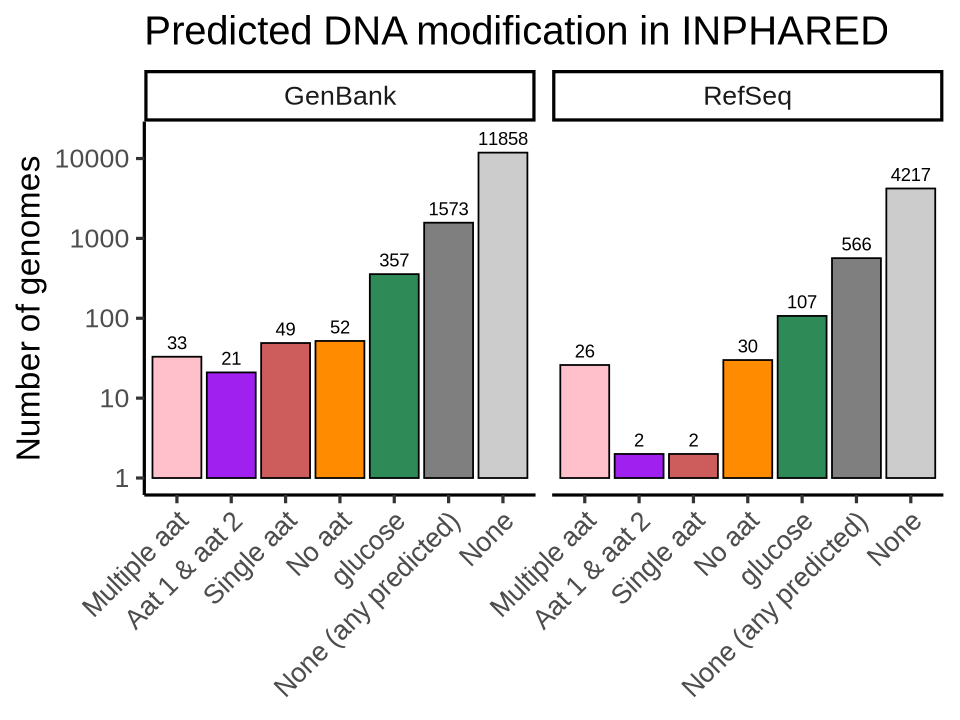

In [172]:
# Visualize groups
options(repr.plot.width=8, repr.plot.height=6)

## Fetch
df <- as.data.frame(table(ds$genomes$group, ds$genomes$Source.database))
names(df) <- c('group','origin','freq')

## Order
df <- df[order(df$freq, decreasing = TRUE), ]
#df$group <- factor(df$group, unique(df$group))

## Plot
p2 <- ggplot(df, aes(group, freq, fill=group, label=freq)) +
  geom_col(position = 'stack', col='black') +
  geom_text(aes(y = freq*1.5)) +
  facet_wrap(~origin, nrow=1) +
  scale_fill_manual(values = cols$group) +
  scale_y_continuous(trans='log10') +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1)
  ) +
  guides(
      fill = guide_none()
  ) +
  labs(title='Predicted DNA modification in INPHARED',y='Number of genomes',x=NULL,fill='Group')
p2

## Save
fn <- paste0(out_path,'barplot_test-quantification','.png')
ggsave(fn, p2, width = 4.5, height = 6, bg='white')

'data.frame':	18893 obs. of  61 variables:



        Multiple aat        Aat 1 & aat 2           Single aat 
                  59                   23                   51 
              No aat              glucose None (any predicted) 
                  82                  464                 2139 
                None 
               16075 


Arabinosylation   Glucosylation            None 
            215             464           18214 

`summarise()` has grouped output by 'set', 'genus_cleaned', 'modification'. You
can override using the `.groups` argument.


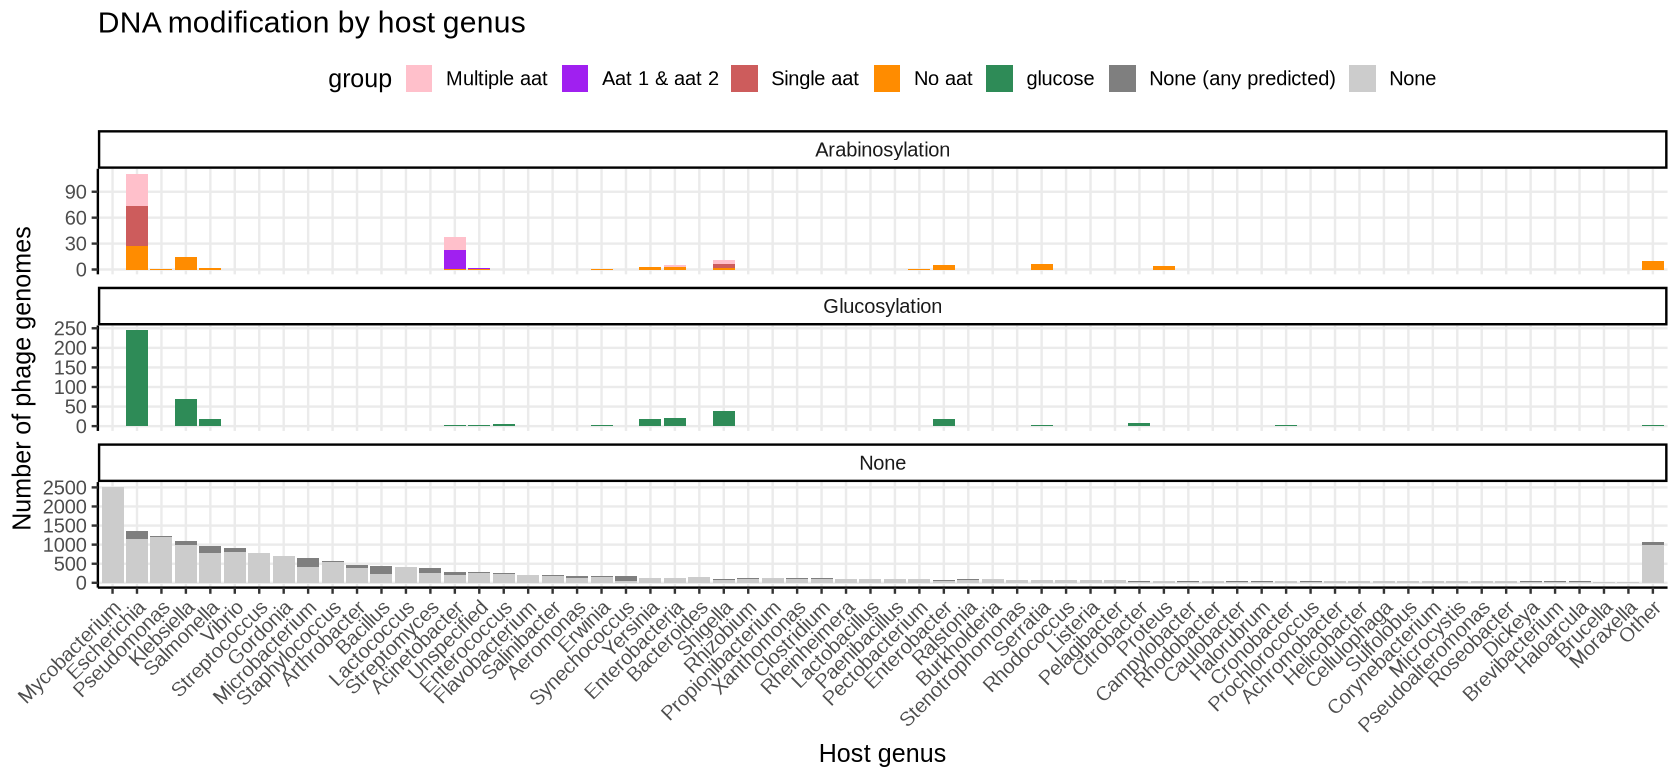

In [157]:
# Representativeness of data sets
options(repr.plot.width=14, repr.plot.height=6.5)

## Select
df <- ds$genomes
df$N <- 1

## Quantify
str(df, max.level = 0)
table(df$group)
table(df$modification)

## Summarize
df <- df %>% group_by(set, genus_cleaned, modification, group) %>% summarize(total = sum(N))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training')] <- 'in study'
df$facet[df$set %in% c('test','test2','validation')] <- 'NCBI databases'

## Plot
ggplot(df, aes(genus_cleaned, total, fill=group)) +
  geom_col() +
  facet_wrap(~modification, nrow = 8, scales = 'free_y') +
  scale_fill_manual(values = cols$group) +
  theme_classic(15) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position = 'top', nrow=1)
  ) +
  labs(title='DNA modification by host genus', x = 'Host genus', y='Number of phage genomes')

## Save
fn <- paste0(out_path,'barplot_modification-genus','.png')
ggsave(fn, width = 14, height = 6.5, bg='white')

`summarise()` has grouped output by 'set', 'genus_cleaned', 'group'. You can
override using the `.groups` argument.


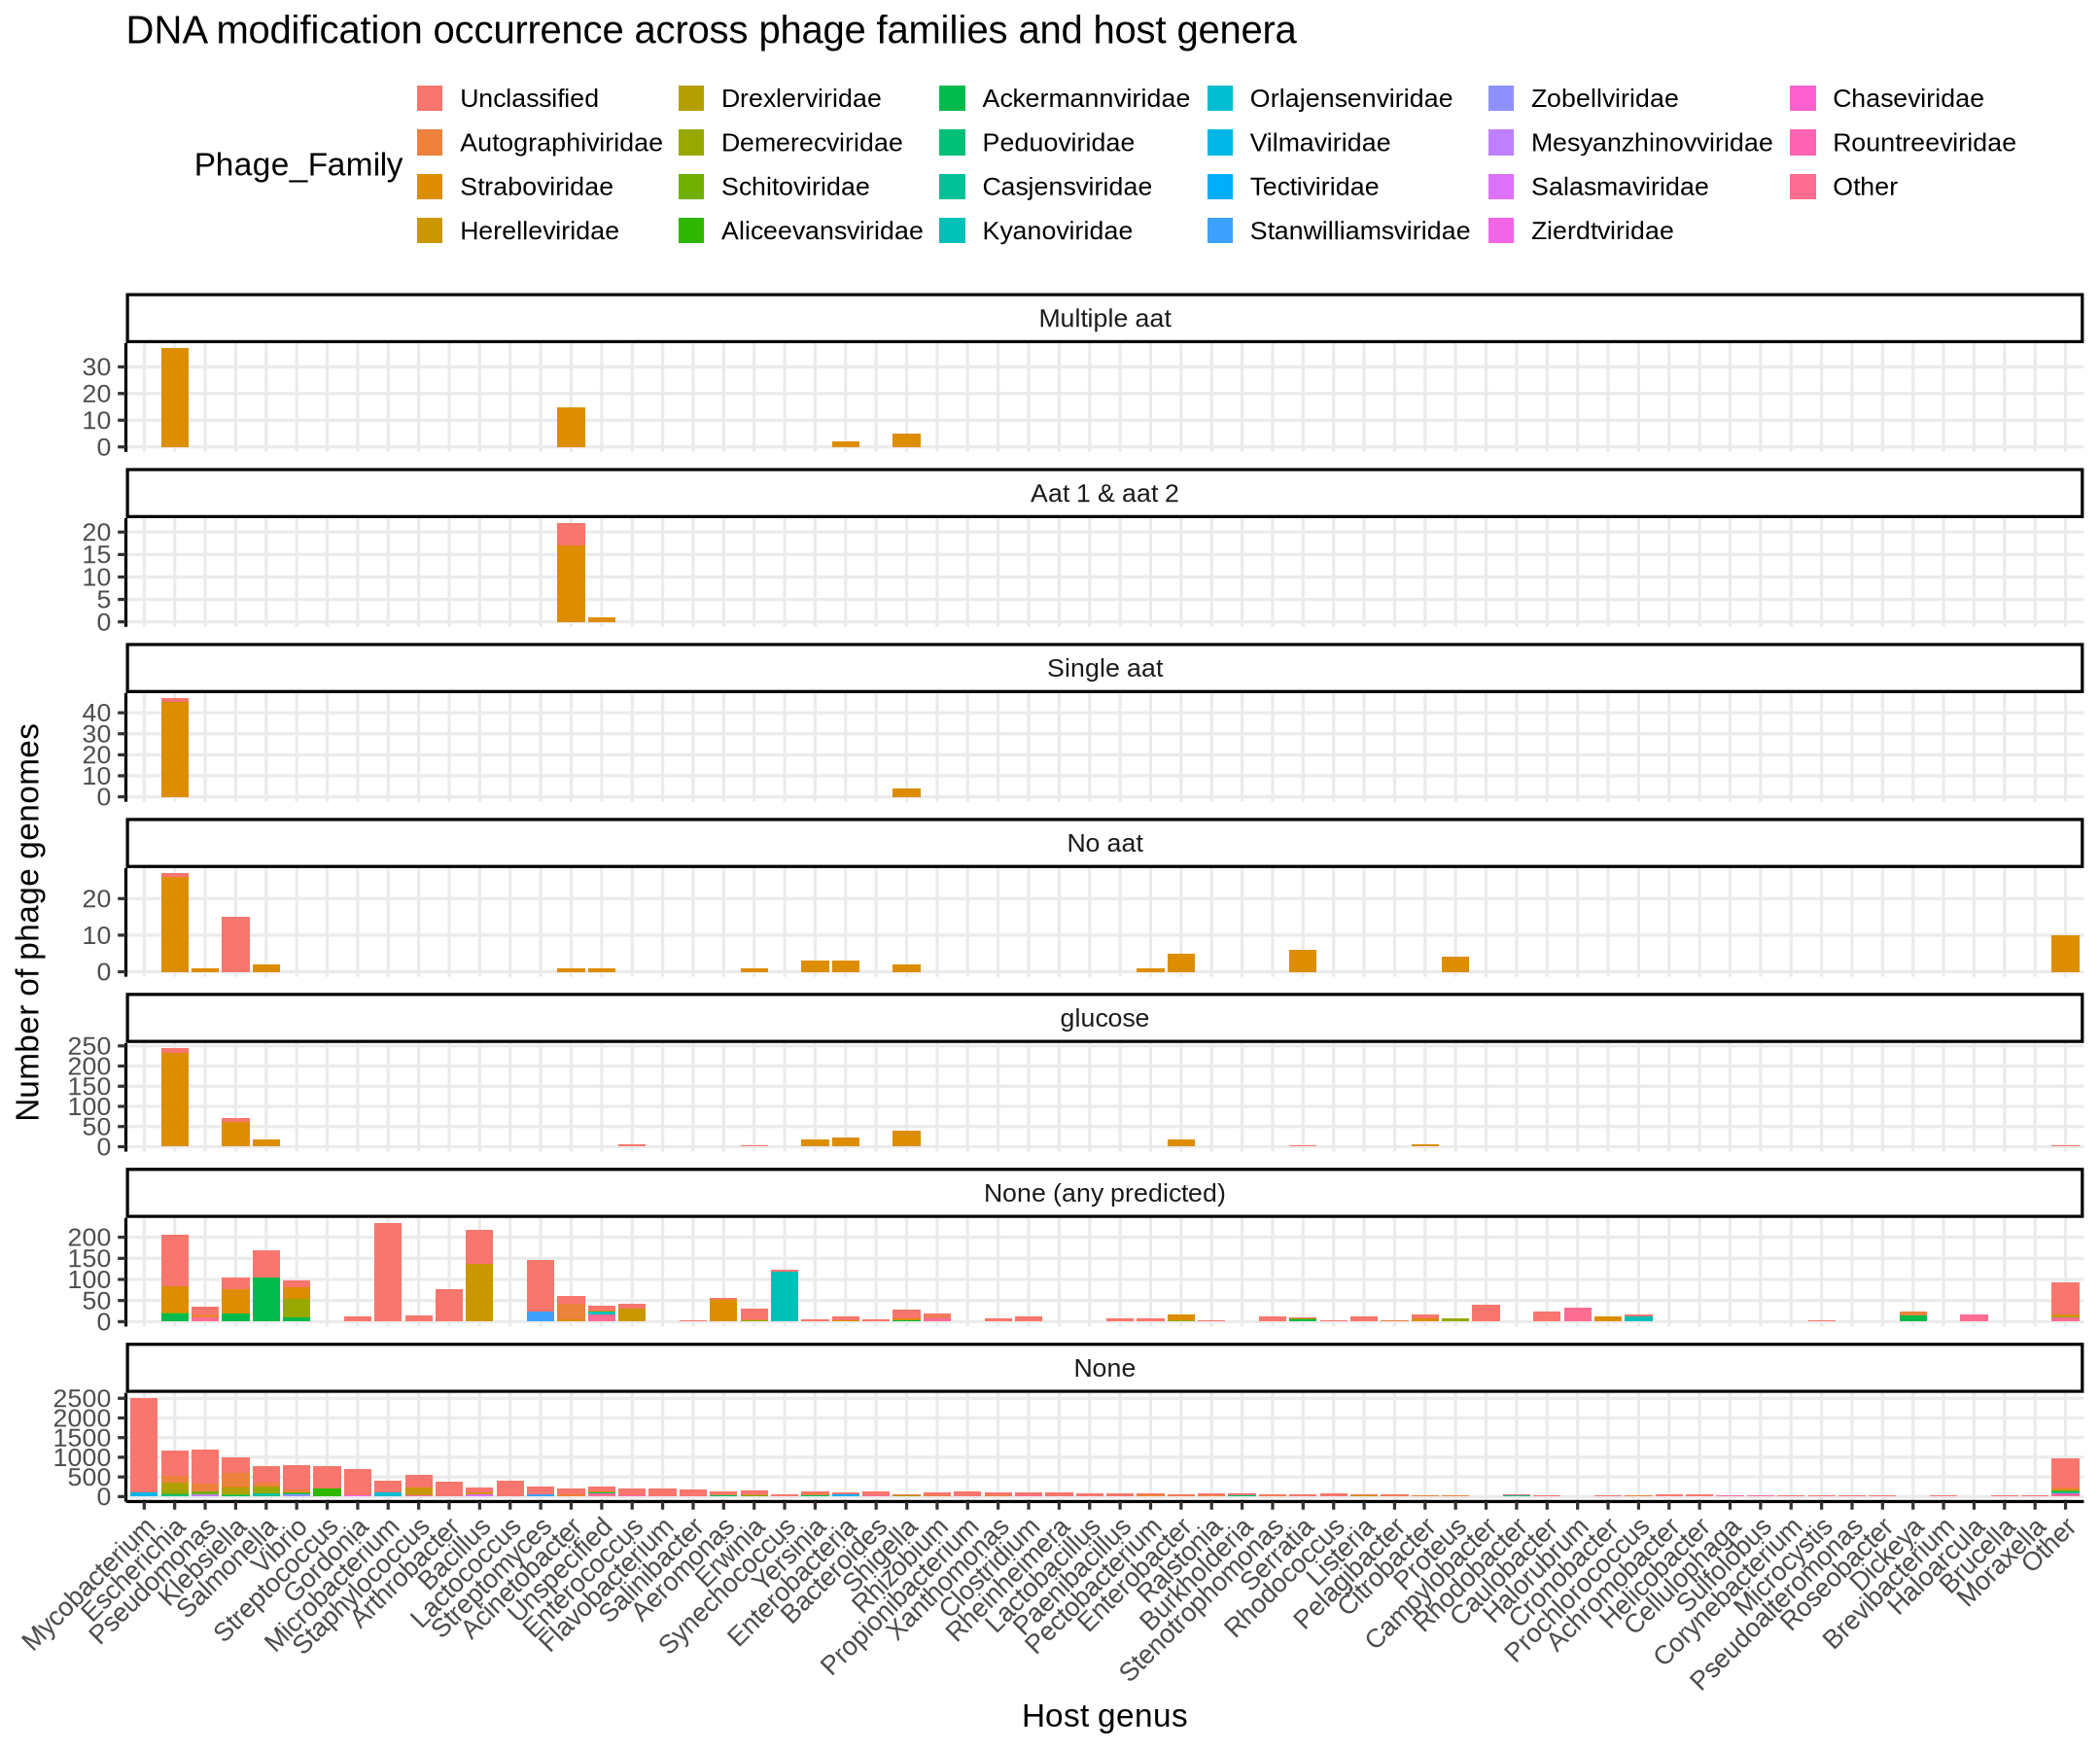

In [158]:
# Representativeness of data sets
options(repr.plot.width=18, repr.plot.height=15)

## Select
df <- ds$genomes
df$N <- 1

## Summarize
df <- df %>% group_by(set, genus_cleaned, group, Phage_Family) %>% summarize(total = sum(N))

## Create facets
df$facet <- NA
df$facet[df$set %in% c('training')] <- 'in study'
df$facet[df$set %in% c('test','test2','validation')] <- 'NCBI databases'

## Plot
ggplot(df, aes(genus_cleaned, total, fill=Phage_Family)) +
  geom_col() +
  facet_wrap(~group, nrow = 8, scales = 'free_y') +
  #scale_fill_manual(values = cols$modification) +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position='top', nrow = 4)
  ) +
  labs(title='DNA modification occurrence across phage families and host genera', x = 'Host genus', y='Number of phage genomes')

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


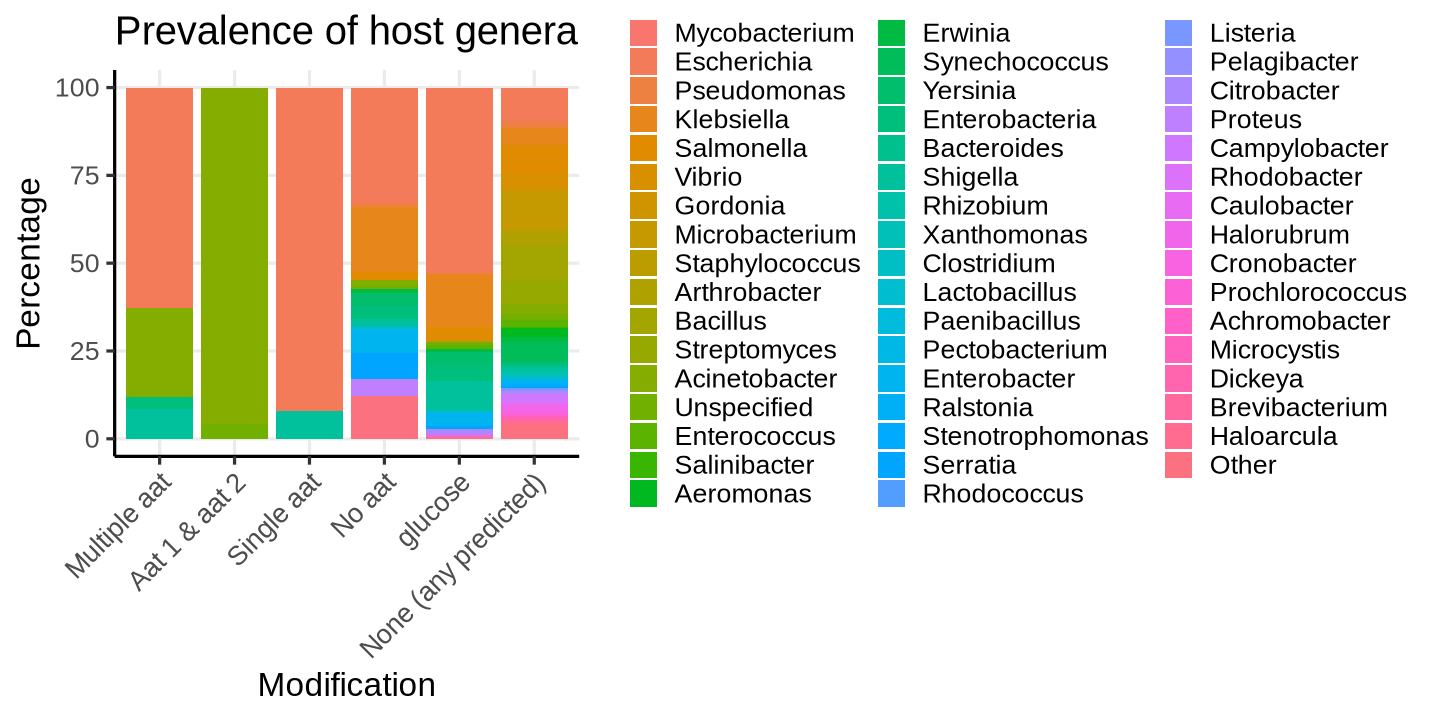

In [159]:
# Quantify host genus across modifications
options(repr.plot.width=12, repr.plot.height=6)

## Format data
df <- ds$genomes %>% mutate(N=1) %>% group_by(group, genus_cleaned) %>% summarize(count=sum(N))
df <- df %>% group_by(group) %>% mutate(total=sum(count), perc=count/total*100)

## Subset
index <- which(df$group != 'None')
df <- df[index,]

## Plot
ggplot(df, aes(group, perc, fill=genus_cleaned)) +
  geom_col() +
  theme_classic(20) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position='right', ncol = 3)
  ) +
  labs(title='Prevalence of host genera', x = 'Modification', y='Percentage', fill=NULL)

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
Warning message:
“ggrepel: 413 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 422 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


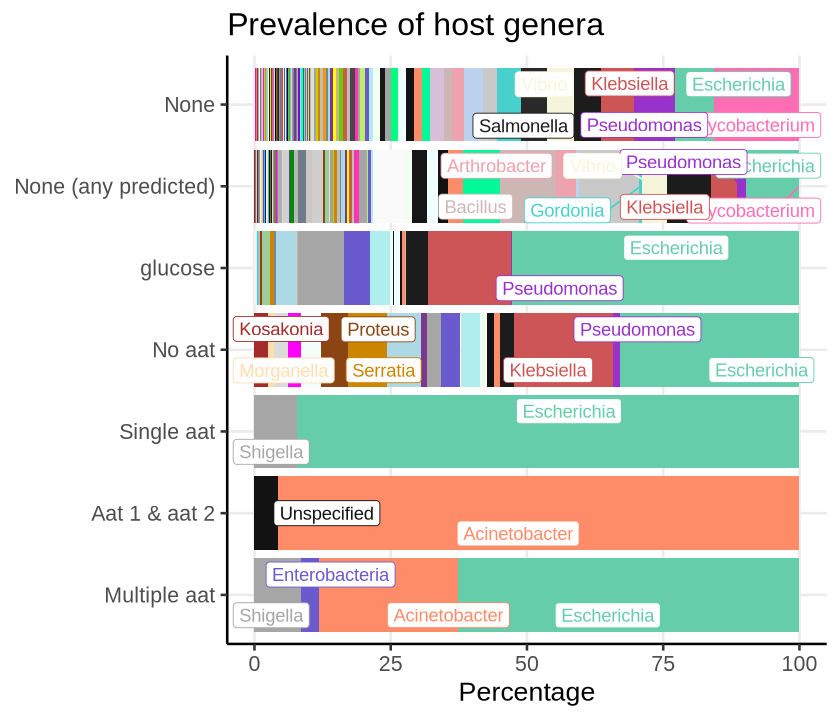

In [160]:
# Quantify host genus across modifications
options(repr.plot.width=7, repr.plot.height=6)
set.seed(50)

## Format data
df <- ds$genomes %>% mutate(N=1) %>% group_by(group, Host_Genus) %>% summarize(count=sum(N))
df <- df %>% group_by(group) %>% mutate(total=sum(count), perc=count/total*100)

## Colors
n_cols <- length(unique(df$Host_Genus))
pl_cols <- sample(colors(), n_cols, replace = FALSE)

## Plot
ggplot(df, aes(perc, group, label=Host_Genus)) +
  geom_col(aes(fill=Host_Genus)) +
  ggrepel::geom_label_repel(aes(col=Host_Genus), position = position_stack(vjust=.5), max.overlaps = 12) +
  scale_fill_manual(values = pl_cols) +
  scale_color_manual(values = pl_cols) +
  theme_classic(16) +
  theme(
      #axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_none(),
      col = guide_none()
  ) +
  labs(title='Prevalence of host genera', y = NULL, x='Percentage', fill=NULL)

## Save
fn <- paste0(out_path,'barplot_host-genus_modification','.png')
ggsave(fn, width = 7, height = 6, bg='white')

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.


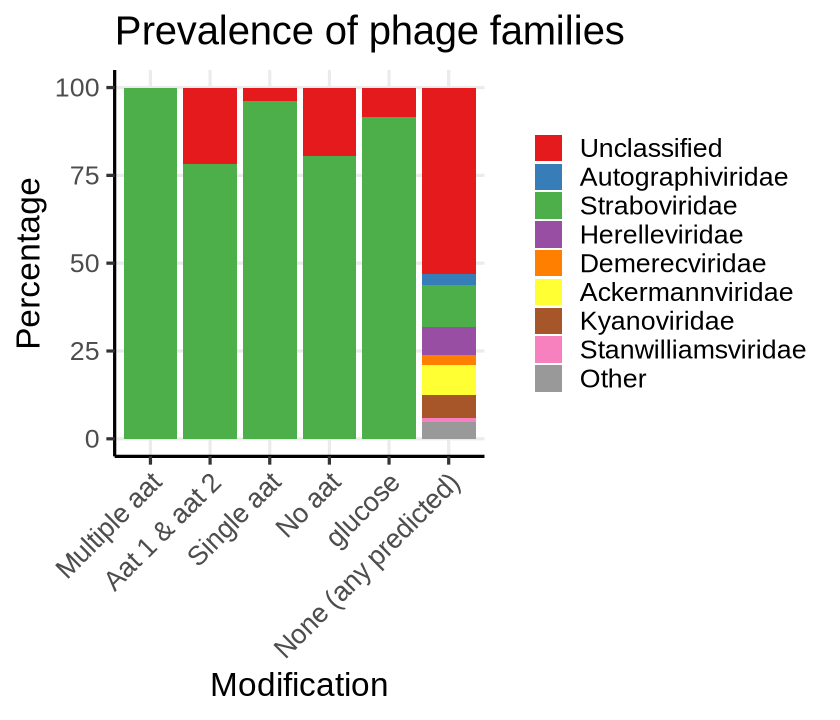

In [161]:
# Quantify host genus across modifications
options(repr.plot.width=7, repr.plot.height=6)

## Format data
df <- ds$genomes %>% mutate(N=1) %>% group_by(group, Phage_Family) %>% summarize(count=sum(N))
df <- df %>% group_by(group) %>% mutate(total=sum(count), perc=count/total*100)

## Subset
index <- which(df$group != 'None')
df <- df[index,]

## Plot
ggplot(df, aes(group, perc, fill=Phage_Family)) +
  geom_col() +
  theme_classic(20) +
  scale_fill_brewer(palette = 'Set1', direction = 1) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      fill = guide_legend(position='right')
  ) +
  labs(title='Prevalence of phage families', x = 'Modification', y='Percentage', fill=NULL)

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
Warning message:
“ggrepel: 1378 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1381 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


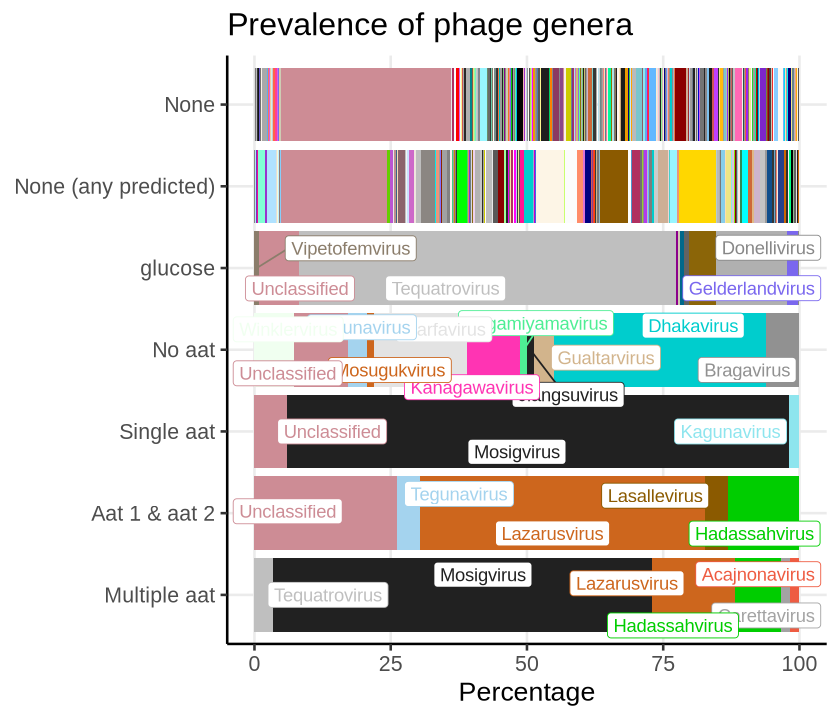

In [162]:
# Quantify host genus across modifications
options(repr.plot.width=7, repr.plot.height=6)
set.seed(51)

## Format data
df <- ds$genomes %>% mutate(N=1) %>% group_by(group, Phage_Genus) %>% summarize(count=sum(N))
df <- df %>% group_by(group) %>% mutate(total=sum(count), perc=count/total*100)

## Colors
n_cols <- length(unique(df$Phage_Genus))
pl_cols <- sample(colors(), n_cols, replace = TRUE)

## Plot
ggplot(df, aes(perc, group, label=Phage_Genus)) +
  geom_col(aes(fill=Phage_Genus)) +
  ggrepel::geom_label_repel(aes(col=Phage_Genus), position=position_stack(vjust = .5), max.overlaps = 10) +
  scale_fill_manual(values = pl_cols) +
  scale_color_manual(values = pl_cols) +
  theme_classic(16) +
  #scale_fill_brewer(palette = 'Set1', direction = 1) +
  theme(
      #axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line(),
      panel.grid.major.x = element_line()
  ) +
  guides(
      #fill = guide_legend(position='')
      fill = guide_none(),
      col = guide_none()
  ) +
  labs(title='Prevalence of phage genera', y = NULL, x='Percentage', fill=NULL)

## Save
fn <- paste0(out_path,'barplot_phage-genus_modification','.png')
ggsave(fn, width = 7, height = 6, bg='white')

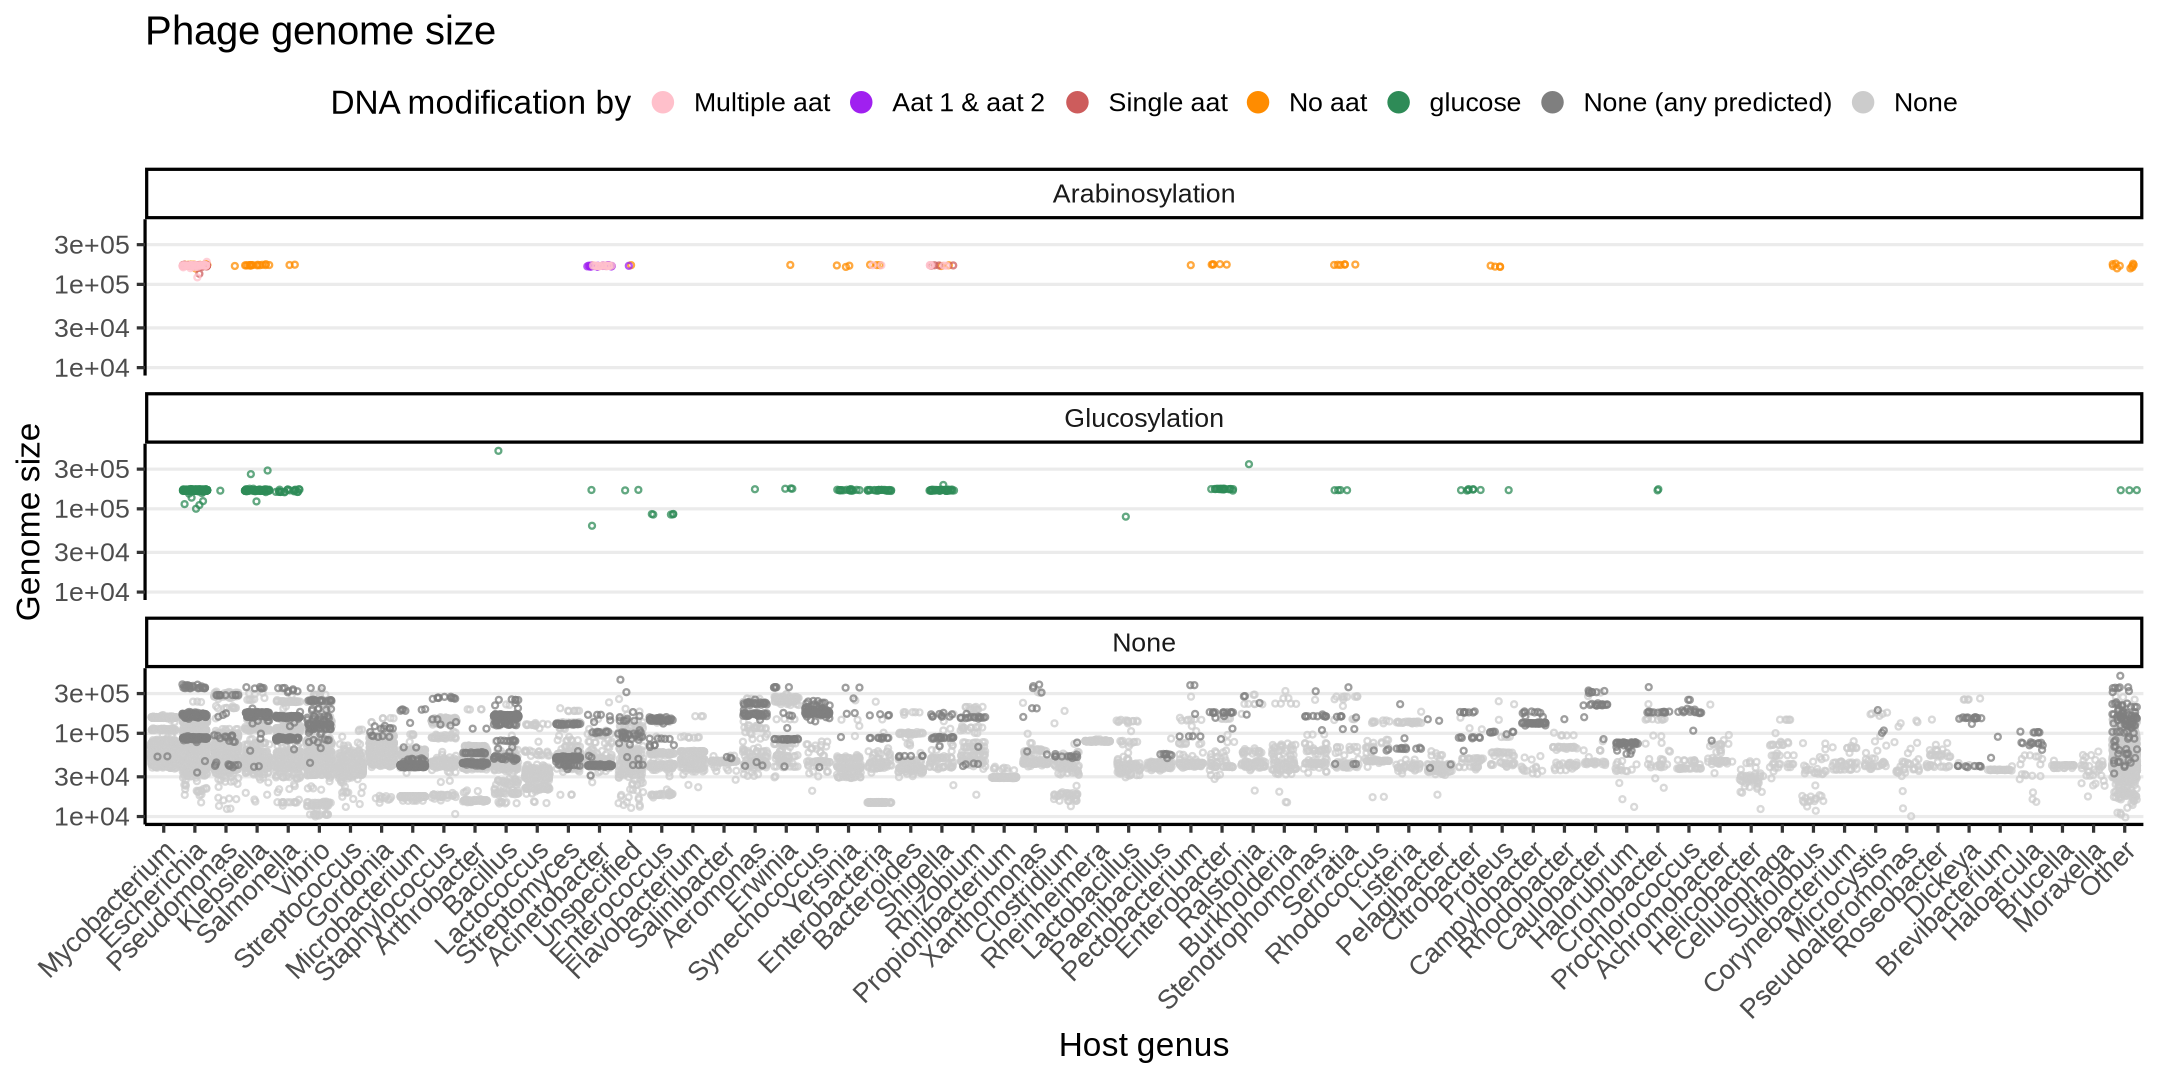

In [163]:
# Phage genome size by group
options(repr.plot.width=18, repr.plot.height=9)

## Select
df <- ds$genomes

## Order
df <- df[order(df$group, decreasing = TRUE), ]

## Plot
ggplot(df, aes(genus_cleaned, Length, col=group)) +
  #geom_boxplot(fill='grey20') +
  geom_point(position = 'jitter', shape=21, size=1, stroke=1, alpha=.75) +
  #geom_violin(col='black', scale = 'width', fill=NA) +
  theme_classic(20) +
  facet_wrap(~modification, ncol=1) +
  scale_y_continuous(trans='log10') +
  scale_color_manual(values = cols$group) +
  theme(
      axis.text.x = element_text(angle=45,hjust=1,vjust=1),
      panel.grid.major.y = element_line()
  ) +
  guides(
      fill = guide_none(),
      col = guide_legend(position='top', nrow=1, override.aes = list(size=5, shape=19, alpha=1))
  ) +
  labs(title='Phage genome size', x = 'Host genus', y='Genome size', col='DNA modification by')

In [164]:
dim(ds$genomes)
dim(ds$features)
table(ds$features$annotation)

[1] 18893    60

[1] 3420754      76


                         aat                        aat 1 
                         140                           55 
                       aat 2   alpha-glucosyl-transferase 
                          53                          640 
         arabinose isomerase    beta-glucosyl-transferase 
                         239                          127 
            dCMP hydroxylase        dCMP hydroxymethylase 
                         439                         1482 
                     dCTPase               DNA polymerase 
                        1425                         2797 
                 dNMP kinase              NTP transferase 
                        2924                          340 
               peptidase U32     phosphoheptose isomerase 
                         206                          358 
putative glycosyltransferase           thymidylate kinase 
                         347                          361 

In [165]:
# Export summary table
names(ds$genomes)

## Select columns
smry_cols <- c('Accession','Virus.Name','set','group','modification',
               'Host_Genus','Phage_Class','Phage_Family','Phage_Genus','Virus.Taxonomic.ID')
smry <- ds$genomes[order(ds$genomes$modification, ds$genomes$group, ds$genomes$set, decreasing = c(FALSE, TRUE, TRUE), method = 'radix'),smry_cols]

## Add genes

### For each genome
smry$gene_annotation <- character(length = nrow(smry))
for (i in smry$Accession) {
    index <- which(smry$Accession == i)
    ind <- which(ds$features$Accession == i)
    # Select annotated genes
    sub <- ds$features[ind, ]
    sub <- sub[which(!is.na(sub$annotation)), ]
    # Add annotation to protein accession (in tag=value pairs) 
    smry$gene_annotation[[index]] <- paste(sub$annotation, sub$Gene.CDS.Protein.FASTA.Accession, collapse = ';', sep='=')
}

## View
head(smry, 10)
dim(smry)

[1] "Accession"                          "BioProjects"                       
 [3] "BioSample.accession"                "Completeness"                      
 [5] "Gene.count"                         "Geographic.Location"               
 [7] "Geographic.Region"                  "Geographic.State"                  
 [9] "Host.Common.Name"                   "Host.Infraspecific.Names.Breed"    
[11] "Host.Infraspecific.Names.Cultivar"  "Host.Infraspecific.Names.Ecotype"  
[13] "Host.Infraspecific.Names.Isolate"   "Host.Infraspecific.Names.Sex"      
[15] "Host.Infraspecific.Names.Strain"    "Host.Name"                         
[17] "Host.Pangolin.Classification"       "Host.Taxonomic.ID"                 
[19] "Is.Annotated"                       "Is.Complete"                       
[21] "Is.Lab.Host"                        "Is.Vaccine.Strain"                 
[23] "Isolate.Collection.date"            "Isolate.Lineage"                   
[25] "Isolate.Lineage.source"             "Lab.Host"                          
[27] "Length"                             "Mature.peptide.count"              
[29] "Molecule.type"                      "Nucleotide.completeness"           
[31] "Protein.count"                      "Purpose.of.Sampling"               
[33] "Release.date"                       "Source.database"                   
[35] "SRA.Accessions"                     "Submitter.Affiliation"             
[37] "Submitter.Country"                  "Submitter.Names"                   
[39] "Update.date"                        "Virus.Common.Name"                 
[41] "Virus.Infraspecific.Names.Breed"    "Virus.Infraspecific.Names.Cultivar"
[43] "Virus.Infraspecific.Names.Ecotype"  "Virus.Infraspecific.Names.Isolate" 
[45] "Virus.Infraspecific.Names.Sex"      "Virus.Infraspecific.Names.Strain"  
[47] "Virus.Name"                         "Virus.Pangolin.Classification"     
[49] "Virus.Taxonomic.ID"                 "set"                               
[51] "millard"                            "genus"                             
[53] "genus_cleaned"                      "Host_Genus"                        
[55] "Phage_Genus"                        "Phage_Family"                      
[57] "Phage_Class"                        "is_unique"                         
[59] "group"                              "modification"

Accession   Virus.Name                  set      group  modification   
11 MZ348424.1  Kosakonia phage Kc304       training No aat Arabinosylation
15 NC_014260.1 Escherichia phage IME08     training No aat Arabinosylation
21 NC_028683.1 Edwardsiella phage PEi20    training No aat Arabinosylation
22 NC_028820.1 Yersinia phage vB_YenM_TG1  training No aat Arabinosylation
24 NC_041996.1 Serratia phage CHI14        training No aat Arabinosylation
27 NC_055721.1 Escherichia phage EcS1      training No aat Arabinosylation
28 NC_055727.1 Proteus phage PM2           training No aat Arabinosylation
29 NC_055728.1 Serratia phage X20          training No aat Arabinosylation
32 OL770309.1  Erwinia phage Virsaitis27   training No aat Arabinosylation
33 OP617331.1  Serratia phage vB_SspM_LC53 training No aat Arabinosylation
   Host_Genus   Phage_Class    Phage_Family  Phage_Genus     Virus.Taxonomic.ID
11 Kosakonia    Caudoviricetes Straboviridae Winklervirus    2863196           
15 Escherichia  Caudoviricetes Straboviridae Dhakavirus       698728           
21 Edwardsiella Caudoviricetes Straboviridae Kanagawavirus   1608310           
22 Yersinia     Caudoviricetes Straboviridae Tegunavirus     1589265           
24 Serratia     Caudoviricetes Straboviridae Winklervirus    2006941           
27 Escherichia  Caudoviricetes Straboviridae Kagamiyamavirus 2083276           
28 Proteus      Caudoviricetes Straboviridae Bragavirus      2025809           
29 Serratia     Caudoviricetes Straboviridae Winklervirus    2006942           
32 Erwinia      Caudoviricetes Straboviridae Winklervirus    2910775           
33 Serratia     Caudoviricetes Straboviridae Winklervirus    2989509           
   gene_annotation                                                                                                                                                                                                                                                                                                                     
11 dCTPase=QYN80470.1;thymidylate kinase=QYN80481.1;putative glycosyltransferase=QYN80482.1;dCMP hydroxylase=QYN80483.1;peptidase U32=QYN80485.1;phosphoheptose isomerase=QYN80486.1;NTP transferase=QYN80487.1;arabinose isomerase=QYN80489.1;DNA polymerase=QYN80491.1;dNMP kinase=QYN80595.1                                        
15 dCTPase=YP_003734175.1;DNA polymerase=YP_003734196.1;dNMP kinase=YP_003734286.1;putative glycosyltransferase=YP_003734189.1;dCMP hydroxylase=YP_003734190.1;thymidylate kinase=YP_003734191.1;phosphoheptose isomerase=YP_003734192.1;NTP transferase=YP_003734193.1                                                                
21 dCTPase=YP_009190185.1;dCMP hydroxylase=YP_009190200.1;DNA polymerase=YP_009190209.1;dNMP kinase=YP_009190321.1;thymidylate kinase=YP_009190198.1;putative glycosyltransferase=YP_009190199.1;peptidase U32=YP_009190202.1;phosphoheptose isomerase=YP_009190204.1;NTP transferase=YP_009190205.1;arabinose isomerase=YP_009190207.1
22 dCTPase=YP_009200293.1;thymidylate kinase=YP_009200308.1;putative glycosyltransferase=YP_009200309.1;dCMP hydroxylase=YP_009200310.1;peptidase U32=YP_009200313.1;phosphoheptose isomerase=YP_009200314.1;NTP transferase=YP_009200315.1;arabinose isomerase=YP_009200317.1;DNA polymerase=YP_009200318.1;dNMP kinase=YP_009200405.1
24 dCTPase=YP_009609350.1;thymidylate kinase=YP_009609361.1;putative glycosyltransferase=YP_009609362.1;dCMP hydroxylase=YP_009609363.1;peptidase U32=YP_009609365.1;phosphoheptose isomerase=YP_009609367.1;NTP transferase=YP_009609368.1;arabinose isomerase=YP_009609370.1;DNA polymerase=YP_009609372.1;dNMP kinase=YP_009609476.1
27 dCTPase=YP_010090720.1;thymidylate kinase=YP_010090730.1;putative glycosyltransferase=YP_010090731.1;dCMP hydroxylase=YP_010090732.1;peptidase U32=YP_010090734.1;phosphoheptose isomerase=YP_010090735.1;NTP transferase=YP_010090736.1;arabinose isomerase=YP_010090738.1;DNA polymerase=YP_010090740.1;dNMP kinase=YP_010090860.1
28

[1] 18893    11

In [166]:
## Export
fn <- paste0(out_path,'predicted-genomes_annotation-summary.csv')
write.table(smry, fn, sep = ',')

In [167]:
table(ds$genomes$set, ds$genomes$modification)

          
           Arabinosylation Glucosylation  None
  test                  78           221  5857
  test2                108           237 12357
  training              29             6     0

In [168]:
sessionInfo()

R version 4.4.2 (2024-10-31)
Platform: x86_64-conda-linux-gnu
Running under: Ubuntu 22.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/dieol22p/miniconda3/envs/arabinosylation-anti-crispr/lib/libopenblasp-r0.3.28.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] pheatmap_1.0.12     ape_5.8-1           msa_1.38.0         
 [4] Biostrings_2.74.0   GenomeInfoDb_1.42.0 XVector_0.46.0     
 [7] IRanges_2.40.0      S4Vectors_0.44.0    BiocGenerics_0.52.0
[10] ggtree_3.14.0       gggenes_0.5.1       cowplot_1.1.3      
